# The Goal of this Project
In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

## Camera Caliberation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

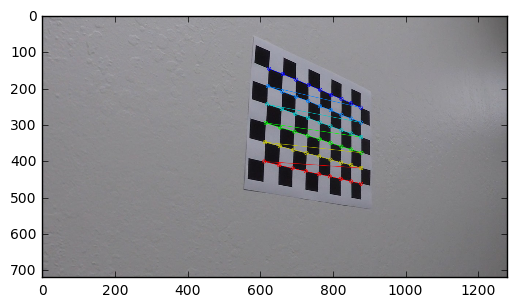

In [2]:
# read in caliberation images
images = glob.glob('camera_cal/calibration*.jpg')

obj_points = []
img_points = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)

    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)

        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)

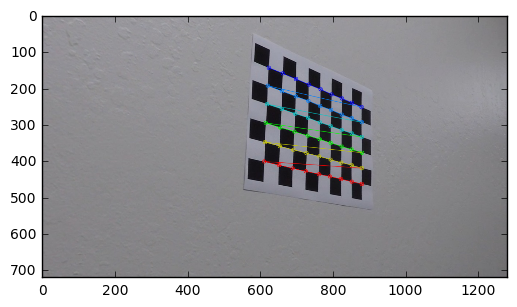

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)
plt.savefig('output_images/chessboard_undistort.jpg')

In [4]:
# threshholding
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_magxy = np.uint8(255*magxy/np.max(magxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_magxy)
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_magxy >= mag_thresh[0]) & (scaled_magxy <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(sobely, sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_gradient)
    # 6) Return this mask as your binary_output image
    dir_binary[(dir_gradient > thresh[0]) & (dir_gradient < thresh[1])] = 1
    return dir_binary

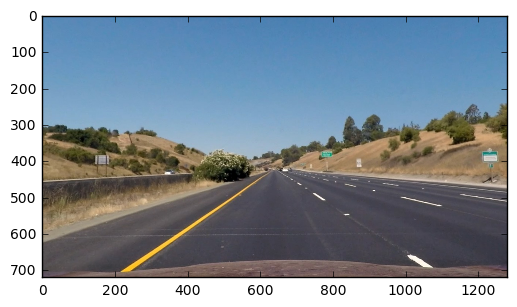

In [25]:
# apply to test images
img = mpimg.imread('test_images/straight_lines1.jpg')

# undistort
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
# print distortion-corrected image
dst = undistort(img)
plt.imshow(dst)
plt.savefig('output_images/undistort.jpg')

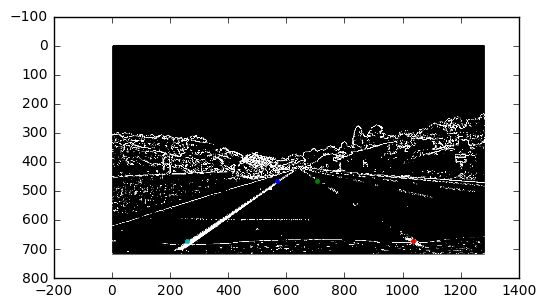

In [40]:
def apply_gradient_threshold(dst):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(dst, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(dst, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(dst, sobel_kernel=ksize, thresh=(0, np.pi/2))
    # apply thresholds
    sxbinary = np.zeros_like(gradx)
    sxbinary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #plt.imshow(sxbinary)
    # Threshold color channel
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # s channel and gradient
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

combined_binary = apply_gradient_threshold(dst)
plt.imshow(combined_binary,cmap='gray')
plt.savefig('output_images/combined_binary.jpg')
# select four points
plt.plot(567, 465, '.')
plt.plot(567+140, 465,'.')
plt.plot(1035, 672,'.')
plt.plot(260, 672,'.')

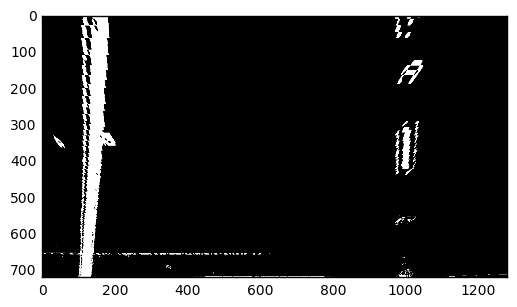

In [39]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # source points
    src = np.float32(
        [[567,465],
         [567+140,465],
         [1035,672],
         [260,672]]
        )
    # destination points
    dst = np.float32(
        [[100,0],
         [1000,0],
         [1000,720],
         [100,720]])
    
    # perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return (warped,M,Minv)

warped, M, Minv = warp(combined_binary)
plt.imshow(warped,cmap='gray')
plt.savefig('output_images/perspective_transform.jpg')

In [41]:
def detect_lane_pixels(warped):
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((warped, warped, warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # fit a polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return (left_fit, right_fit)

In [42]:
def find_lane_pixels_from_last_frame(warped,left_fit, right_fit):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

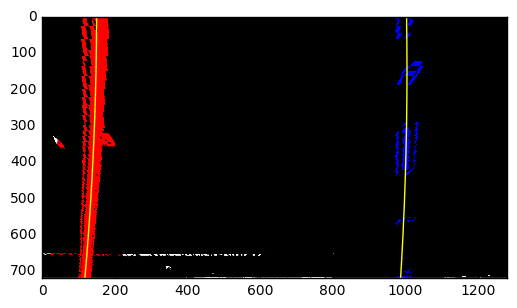

In [43]:
# Generate x and y values for plotting
left_fit,right_fit = detect_lane_pixels(warped)
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin))) 
out_img = np.dstack((warped, warped, warped))*255
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/detect_lanes.jpg')

In [44]:
def calculate_curvature(left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

def draw_lanes(warped, undist, Minv, left_fit, right_fit):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

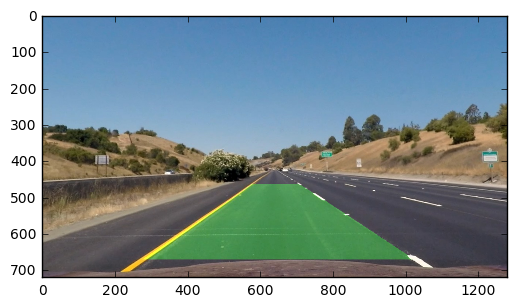

In [47]:
result = draw_lanes(warped,dst,Minv,left_fit,right_fit)
plt.imshow(result)
plt.savefig('output_images/lanes_painted.jpg')

In [48]:
# put together pipeline
def process_image(image):
    undistorted = undistort(image)
    binary = apply_gradient_threshold(undistorted)
    warped, M, Minv = warp(binary)
    left_fit, right_fit = detect_lane_pixels(warped)
    left_curve, right_curve = calculate_curvature(left_fit, right_fit)
    output = draw_lanes(warped, undistorted, Minv, left_fit, right_fit)
    return output

## test on test images

1971.41566251 m 433.632430502 m


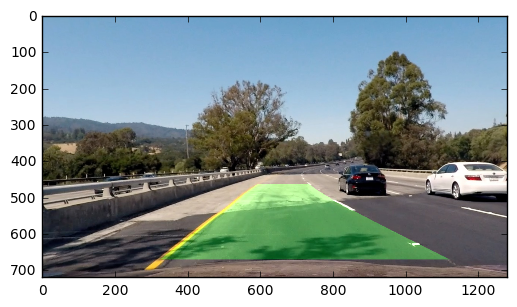

In [51]:
import glob
img = mpimg.imread('test_images/test4.jpg')
output = process_image(img)
plt.imshow(output)

## Test on videos

In [52]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [53]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False 
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.recent_fits = None

In [54]:
# insert sanity checks and smoothing into pipeline
left = Line()
right = Line()
def process_image(image):
    undistorted = undistort(image)
    binary = apply_gradient_threshold(undistorted)
    warped, M, Minv = warp(binary)
    # find left and right lanes using window search if no previous frame, else margin search
    if left.current_fit != None:
        left_fit, right_fit = find_lane_pixels_from_last_frame(warped,left.current_fit, right.current_fit)
    else:
        left_fit, right_fit = detect_lane_pixels(warped)
    left_curverad, right_curverad = calculate_curvature(left_fit, right_fit)
    if (left_curverad < 100 or right_curverad < 100): 
        # too small - bad detection
        next
    elif (abs(left_curverad - right_curverad) < 600) or ((left_curverad > 3000) and (right_curverad > 3000)):
        # either valid curves or straight - save current fit
        print('valid')
        left.current_fit = left_fit
        right.current_fit = right_fit
        if left.recent_fits == None:
            left.recent_fits = left_fit.reshape([1,3])
            right.recent_fits = right_fit.reshape([1,3])
        else:
            left.recent_fits = np.append(left.recent_fits,left_fit.reshape([1,3]),axis=0)
            right.recent_fits = np.append(right.recent_fits,right_fit.reshape([1,3]),axis=0)
        # only keep the 5 most recent fits
        left.recent_fits = left.recent_fits[-5:,:]
        right.recent_fits = right.recent_fits[-5:,:]
    print(left.recent_fits)
    print(right.recent_fits)
    # plot the average of the 5 most recent valid fits
    left_fit = np.mean(left.recent_fits,axis=0)
    right_fit = np.mean(right.recent_fits,axis=0)
    output = draw_lanes(warped, undistorted, Minv, left_fit, right_fit)
    return output

In [55]:
output = 'lanes.mp4'
clip = VideoFileClip('project_video.mp4', audio=False)
clip_w_lanes = clip.fl_image(process_image)
clip_w_lanes.write_videofile(output, audio=False)

552.6202271 m 884.438925228 m
valid
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]]
[MoviePy] >>>> Building video lanes.mp4
[MoviePy] Writing video lanes.mp4


  0%|          | 1/1261 [00:00<07:45,  2.71it/s]

548.57314093 m 3361.74857669 m
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]]


  0%|          | 2/1261 [00:00<07:45,  2.70it/s]

520.10830547 m 877.147801171 m
valid
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]
 [ -3.15885463e-04   3.23349031e-01   1.08334299e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]
 [ -1.87228147e-04   2.72027389e-01   9.85466055e+02]]


  0%|          | 3/1261 [00:01<07:25,  2.82it/s]

470.956031322 m 923.518182159 m
valid
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]
 [ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]
 [ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]]


  0%|          | 4/1261 [00:01<07:15,  2.88it/s]

457.281244106 m 1004.77235593 m
valid
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]
 [ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]
 [ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]]


  0%|          | 5/1261 [00:01<07:00,  2.99it/s]

454.889633172 m 1887.1322984 m
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]
 [ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]
 [ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]]


  0%|          | 6/1261 [00:02<07:16,  2.87it/s]

467.175863522 m 725.983735179 m
valid
[[ -2.97283263e-04   3.06521413e-01   1.09899257e+02]
 [ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]]
[[ -1.85685538e-04   2.52890849e-01   9.98535399e+02]
 [ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]]


  1%|          | 7/1261 [00:02<07:31,  2.78it/s]

485.281103717 m 766.816438078 m
valid
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 8/1261 [00:02<07:19,  2.85it/s]

493.485458432 m 4371.19754543 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 9/1261 [00:03<07:37,  2.74it/s]

494.304180839 m 2063.93064979 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 10/1261 [00:03<07:49,  2.67it/s]

502.468206729 m 39402.2355572 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 11/1261 [00:03<07:44,  2.69it/s]

500.954315081 m 3986.12362295 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 12/1261 [00:04<07:16,  2.86it/s]

507.262078525 m 3063.76129373 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 13/1261 [00:04<07:00,  2.97it/s]

522.68532115 m 1702.68043458 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 14/1261 [00:04<06:53,  3.01it/s]

553.284319553 m 2714.17153498 m
[[ -3.15885463e-04   3.23349031e-01   1.08334299e+02]
 [ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]]
[[ -1.87228147e-04   2.72027389e-01   9.85466055e+02]
 [ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]]


  1%|          | 15/1261 [00:05<06:48,  3.05it/s]

553.388842202 m 927.420890769 m
valid
[[ -3.48898643e-04   3.51725466e-01   1.03889170e+02]
 [ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]
 [ -2.96794982e-04   3.62660084e-01   7.91415528e+01]]
[[ -1.77834364e-04   2.96347418e-01   9.66416901e+02]
 [ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]
 [ -1.77124988e-04   3.58472995e-01   9.24824478e+02]]


  1%|▏         | 16/1261 [00:05<06:35,  3.15it/s]

522.494843764 m 797.635180278 m
valid
[[ -3.59340691e-04   3.63548482e-01   1.02176961e+02]
 [ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]
 [ -2.96794982e-04   3.62660084e-01   7.91415528e+01]
 [ -3.14356308e-04   3.76168687e-01   7.74285159e+01]]
[[ -1.63465196e-04   3.03528814e-01   9.55517330e+02]
 [ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]
 [ -1.77124988e-04   3.58472995e-01   9.24824478e+02]
 [ -2.05931961e-04   3.85763006e-01   9.13030297e+02]]


  1%|▏         | 17/1261 [00:05<06:25,  3.23it/s]

588.317462929 m 665.546774345 m
valid
[[ -3.51694937e-04   3.66683720e-01   9.93365296e+01]
 [ -3.38544680e-04   3.61159970e-01   9.84276215e+01]
 [ -2.96794982e-04   3.62660084e-01   7.91415528e+01]
 [ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]]
[[ -2.26229042e-04   3.80055513e-01   9.32062097e+02]
 [ -2.14188836e-04   3.73089724e-01   9.34054414e+02]
 [ -1.77124988e-04   3.58472995e-01   9.24824478e+02]
 [ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]]


  1%|▏         | 18/1261 [00:06<06:21,  3.26it/s]

631.501178381 m 544.135807965 m
valid
[[ -3.38544680e-04   3.61159970e-01   9.84276215e+01]
 [ -2.96794982e-04   3.62660084e-01   7.91415528e+01]
 [ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]]
[[ -2.14188836e-04   3.73089724e-01   9.34054414e+02]
 [ -1.77124988e-04   3.58472995e-01   9.24824478e+02]
 [ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]]


  2%|▏         | 19/1261 [00:06<06:39,  3.11it/s]

686.579264574 m 794.145127152 m
valid
[[ -2.96794982e-04   3.62660084e-01   7.91415528e+01]
 [ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]]
[[ -1.77124988e-04   3.58472995e-01   9.24824478e+02]
 [ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]]


  2%|▏         | 20/1261 [00:06<06:48,  3.04it/s]

788.559245442 m 1131.90955168 m
valid
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 21/1261 [00:07<06:40,  3.10it/s]

746.981866389 m 4069.12376878 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 22/1261 [00:07<06:41,  3.09it/s]

863.649442954 m 12192.5940645 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 23/1261 [00:07<06:54,  2.99it/s]

1008.0758955 m 6240.79920044 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 24/1261 [00:08<07:01,  2.93it/s]

886.889859889 m 5490.33183411 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 25/1261 [00:08<06:49,  3.02it/s]

893.313128681 m 14445.9015463 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 26/1261 [00:08<06:59,  2.95it/s]

904.389998756 m 1765.18242783 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 27/1261 [00:09<07:00,  2.94it/s]

869.221070161 m 3032.90537545 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 28/1261 [00:09<07:00,  2.94it/s]

955.626815249 m 2429.07097929 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 29/1261 [00:09<06:56,  2.96it/s]

928.466275627 m 1647.56146518 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 30/1261 [00:10<06:52,  2.98it/s]

796.496107034 m 1853.79970195 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  2%|▏         | 31/1261 [00:10<06:56,  2.95it/s]

722.822356263 m 1647.49678672 m
[[ -3.14356308e-04   3.76168687e-01   7.74285159e+01]
 [ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]]
[[ -2.05931961e-04   3.85763006e-01   9.13030297e+02]
 [ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]]


  3%|▎         | 32/1261 [00:10<07:00,  2.92it/s]

668.071120913 m 697.082910741 m
valid
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 33/1261 [00:11<06:50,  2.99it/s]

638.569271902 m 1759.87498093 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 34/1261 [00:11<06:41,  3.05it/s]

643.664574795 m 3095.21621131 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 35/1261 [00:11<06:53,  2.96it/s]

623.613127945 m 2883.28174088 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 36/1261 [00:12<06:40,  3.06it/s]

568.666961835 m 9448.11103919 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 37/1261 [00:12<06:39,  3.06it/s]

523.831394723 m 1368.59414264 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 38/1261 [00:12<06:32,  3.12it/s]

502.187258668 m 1174.60123399 m
[[ -2.79164763e-04   3.49296115e-01   8.00015360e+01]
 [ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]]
[[ -2.46790058e-04   4.32040290e-01   8.98437281e+02]
 [ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]]


  3%|▎         | 39/1261 [00:13<06:40,  3.05it/s]

468.838754152 m 544.150601394 m
valid
[[ -2.60068268e-04   3.32895785e-01   8.27016774e+01]
 [ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]
 [ -3.50423893e-04   3.75300829e-01   8.34139959e+01]]
[[ -3.01834575e-04   4.89679706e-01   8.83530318e+02]
 [ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]
 [ -3.01823309e-04   4.85751760e-01   8.85949411e+02]]


  3%|▎         | 40/1261 [00:13<06:44,  3.02it/s]

458.913204812 m 581.048023663 m
valid
[[ -2.39198215e-04   3.22614287e-01   7.95087946e+01]
 [ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]
 [ -3.50423893e-04   3.75300829e-01   8.34139959e+01]
 [ -3.57997724e-04   3.88585790e-01   7.86393189e+01]]
[[ -2.06846592e-04   3.97246132e-01   9.06491389e+02]
 [ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]
 [ -3.01823309e-04   4.85751760e-01   8.85949411e+02]
 [ -2.82651556e-04   4.49661112e-01   8.97526082e+02]]


  3%|▎         | 41/1261 [00:13<06:54,  2.94it/s]

443.853236354 m 719.442290955 m
valid
[[ -2.08261812e-04   3.03052061e-01   7.80900703e+01]
 [ -2.45836659e-04   3.04187328e-01   8.43524561e+01]
 [ -3.50423893e-04   3.75300829e-01   8.34139959e+01]
 [ -3.57997724e-04   3.88585790e-01   7.86393189e+01]
 [ -3.70155261e-04   4.01429467e-01   7.56305869e+01]]
[[ -1.45191473e-04   3.80488082e-01   9.04504029e+02]
 [ -2.35623352e-04   4.13802211e-01   9.10405518e+02]
 [ -3.01823309e-04   4.85751760e-01   8.85949411e+02]
 [ -2.82651556e-04   4.49661112e-01   8.97526082e+02]
 [ -2.28297800e-04   3.99965628e-01   9.07168176e+02]]


  3%|▎         | 42/1261 [00:14<07:04,  2.87it/s]

434.1540965 m 625.469618505 m
valid
[[ -2.45836659e-04   3.04187328e-01   8.43524561e+01]
 [ -3.50423893e-04   3.75300829e-01   8.34139959e+01]
 [ -3.57997724e-04   3.88585790e-01   7.86393189e+01]
 [ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]]
[[ -2.35623352e-04   4.13802211e-01   9.10405518e+02]
 [ -3.01823309e-04   4.85751760e-01   8.85949411e+02]
 [ -2.82651556e-04   4.49661112e-01   8.97526082e+02]
 [ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]]


  3%|▎         | 43/1261 [00:14<07:11,  2.82it/s]

447.670474159 m 557.126465454 m
valid
[[ -3.50423893e-04   3.75300829e-01   8.34139959e+01]
 [ -3.57997724e-04   3.88585790e-01   7.86393189e+01]
 [ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]]
[[ -3.01823309e-04   4.85751760e-01   8.85949411e+02]
 [ -2.82651556e-04   4.49661112e-01   8.97526082e+02]
 [ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]]


  3%|▎         | 44/1261 [00:14<07:14,  2.80it/s]

480.013640813 m 639.049058939 m
valid
[[ -3.57997724e-04   3.88585790e-01   7.86393189e+01]
 [ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]]
[[ -2.82651556e-04   4.49661112e-01   8.97526082e+02]
 [ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]]


  4%|▎         | 45/1261 [00:15<07:17,  2.78it/s]

459.270939272 m 724.614467263 m
valid
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▎         | 46/1261 [00:15<07:08,  2.84it/s]

447.412210324 m 1350.99040182 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▎         | 47/1261 [00:15<07:16,  2.78it/s]

484.290226632 m 1223.48946445 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▍         | 48/1261 [00:16<07:11,  2.81it/s]

472.695380701 m 1392.64544616 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▍         | 49/1261 [00:16<07:18,  2.77it/s]

492.979468264 m 2135.22725364 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▍         | 50/1261 [00:17<07:36,  2.66it/s]

492.526205958 m 3898.74322783 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▍         | 51/1261 [00:17<07:33,  2.67it/s]

524.781619478 m 1784.35918459 m
[[ -3.70155261e-04   4.01429467e-01   7.56305869e+01]
 [ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]]
[[ -2.28297800e-04   3.99965628e-01   9.07168176e+02]
 [ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]]


  4%|▍         | 52/1261 [00:17<07:28,  2.70it/s]

546.56059229 m 576.034551834 m
valid
[[ -3.78427470e-04   4.12149203e-01   7.34236125e+01]
 [ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]
 [ -3.00479627e-04   4.01970512e-01   4.87839387e+01]]
[[ -2.62577210e-04   4.20616971e-01   9.07193682e+02]
 [ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]
 [ -2.85107865e-04   4.46390941e-01   9.05371762e+02]]


  4%|▍         | 53/1261 [00:18<07:39,  2.63it/s]

563.116630424 m 546.31323221 m
valid
[[ -3.66974323e-04   4.07968715e-01   7.23332073e+01]
 [ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]
 [ -3.00479627e-04   4.01970512e-01   4.87839387e+01]
 [ -2.91643917e-04   3.92746179e-01   5.07537763e+01]]
[[ -2.94780626e-04   4.53013861e-01   9.02535214e+02]
 [ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]
 [ -2.85107865e-04   4.46390941e-01   9.05371762e+02]
 [ -3.00614175e-04   4.58738782e-01   9.00458019e+02]]


  4%|▍         | 54/1261 [00:18<07:32,  2.67it/s]

630.602619636 m 605.307746853 m
valid
[[ -3.42204685e-04   3.96546485e-01   6.94713107e+01]
 [ -3.57663881e-04   4.16545928e-01   6.29941183e+01]
 [ -3.00479627e-04   4.01970512e-01   4.87839387e+01]
 [ -2.91643917e-04   3.92746179e-01   5.07537763e+01]
 [ -2.60428382e-04   3.69650943e-01   5.23989341e+01]]
[[ -2.57004871e-04   4.24578306e-01   9.09160585e+02]
 [ -2.26676233e-04   4.07179082e-01   9.13167685e+02]
 [ -2.85107865e-04   4.46390941e-01   9.05371762e+02]
 [ -3.00614175e-04   4.58738782e-01   9.00458019e+02]
 [ -2.71325187e-04   4.36499255e-01   9.01825942e+02]]


  4%|▍         | 55/1261 [00:18<07:34,  2.66it/s]

713.498927973 m 570.174256787 m
valid
[[ -3.57663881e-04   4.16545928e-01   6.29941183e+01]
 [ -3.00479627e-04   4.01970512e-01   4.87839387e+01]
 [ -2.91643917e-04   3.92746179e-01   5.07537763e+01]
 [ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]]
[[ -2.26676233e-04   4.07179082e-01   9.13167685e+02]
 [ -2.85107865e-04   4.46390941e-01   9.05371762e+02]
 [ -3.00614175e-04   4.58738782e-01   9.00458019e+02]
 [ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]]


  4%|▍         | 56/1261 [00:19<07:17,  2.76it/s]

798.762537517 m 622.448552543 m
valid
[[ -3.00479627e-04   4.01970512e-01   4.87839387e+01]
 [ -2.91643917e-04   3.92746179e-01   5.07537763e+01]
 [ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]]
[[ -2.85107865e-04   4.46390941e-01   9.05371762e+02]
 [ -3.00614175e-04   4.58738782e-01   9.00458019e+02]
 [ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]]


  5%|▍         | 57/1261 [00:19<07:08,  2.81it/s]

818.940262792 m 487.830856595 m
valid
[[ -2.91643917e-04   3.92746179e-01   5.07537763e+01]
 [ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]]
[[ -3.00614175e-04   4.58738782e-01   9.00458019e+02]
 [ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]]


  5%|▍         | 58/1261 [00:20<07:10,  2.79it/s]

858.560789088 m 1580.57351402 m
[[ -2.91643917e-04   3.92746179e-01   5.07537763e+01]
 [ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]]
[[ -3.00614175e-04   4.58738782e-01   9.00458019e+02]
 [ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]]


  5%|▍         | 59/1261 [00:20<06:50,  2.93it/s]

866.810163566 m 1036.12238188 m
valid
[[ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]
 [ -1.89465127e-04   3.02462687e-01   6.34969003e+01]]
[[ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]
 [ -1.58687691e-04   4.48898036e-01   8.73950680e+02]]


  5%|▍         | 60/1261 [00:20<06:38,  3.02it/s]

851.124903834 m 1916.81586224 m
[[ -2.60428382e-04   3.69650943e-01   5.23989341e+01]
 [ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]
 [ -1.89465127e-04   3.02462687e-01   6.34969003e+01]]
[[ -2.71325187e-04   4.36499255e-01   9.01825942e+02]
 [ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]
 [ -1.58687691e-04   4.48898036e-01   8.73950680e+02]]


  5%|▍         | 61/1261 [00:20<06:31,  3.06it/s]

844.099280598 m 771.794196645 m
valid
[[ -2.30172894e-04   3.49690306e-01   5.25143992e+01]
 [ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]
 [ -1.89465127e-04   3.02462687e-01   6.34969003e+01]
 [ -1.94558959e-04   2.89174385e-01   7.23733012e+01]]
[[ -2.88039855e-04   4.53695457e-01   8.98249510e+02]
 [ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]
 [ -1.58687691e-04   4.48898036e-01   8.73950680e+02]
 [ -2.12959752e-04   4.90332525e-01   8.58153318e+02]]


  5%|▍         | 62/1261 [00:21<06:31,  3.06it/s]

747.261289785 m 508.782613792 m
valid
[[ -2.05607386e-04   3.30279417e-01   5.40605026e+01]
 [ -2.00541796e-04   3.23979728e-01   5.50493654e+01]
 [ -1.89465127e-04   3.02462687e-01   6.34969003e+01]
 [ -1.94558959e-04   2.89174385e-01   7.23733012e+01]
 [ -2.19772413e-04   3.02842536e-01   7.32885517e+01]]
[[ -2.63859956e-04   4.35630032e-01   9.02445634e+02]
 [ -3.36670049e-04   5.37548385e-01   8.71931715e+02]
 [ -1.58687691e-04   4.48898036e-01   8.73950680e+02]
 [ -2.12959752e-04   4.90332525e-01   8.58153318e+02]
 [ -3.22868165e-04   5.68408579e-01   8.40142469e+02]]


  5%|▍         | 63/1261 [00:21<07:27,  2.68it/s]

727.965251458 m 586.155002032 m
valid
[[ -2.00541796e-04   3.23979728e-01   5.50493654e+01]
 [ -1.89465127e-04   3.02462687e-01   6.34969003e+01]
 [ -1.94558959e-04   2.89174385e-01   7.23733012e+01]
 [ -2.19772413e-04   3.02842536e-01   7.32885517e+01]
 [ -2.25598657e-04   3.06607218e-01   7.16823103e+01]]
[[ -3.36670049e-04   5.37548385e-01   8.71931715e+02]
 [ -1.58687691e-04   4.48898036e-01   8.73950680e+02]
 [ -2.12959752e-04   4.90332525e-01   8.58153318e+02]
 [ -3.22868165e-04   5.68408579e-01   8.40142469e+02]
 [ -2.80242893e-04   5.02232403e-01   8.59180730e+02]]


  5%|▌         | 64/1261 [00:22<07:40,  2.60it/s]

694.553334479 m 511.985913848 m
valid
[[ -1.89465127e-04   3.02462687e-01   6.34969003e+01]
 [ -1.94558959e-04   2.89174385e-01   7.23733012e+01]
 [ -2.19772413e-04   3.02842536e-01   7.32885517e+01]
 [ -2.25598657e-04   3.06607218e-01   7.16823103e+01]
 [ -2.36455673e-04   3.06899535e-01   7.52070782e+01]]
[[ -1.58687691e-04   4.48898036e-01   8.73950680e+02]
 [ -2.12959752e-04   4.90332525e-01   8.58153318e+02]
 [ -3.22868165e-04   5.68408579e-01   8.40142469e+02]
 [ -2.80242893e-04   5.02232403e-01   8.59180730e+02]
 [ -3.20792505e-04   5.21813541e-01   8.57278043e+02]]


  5%|▌         | 65/1261 [00:22<07:29,  2.66it/s]

662.494763255 m 789.94848944 m
valid
[[ -1.94558959e-04   2.89174385e-01   7.23733012e+01]
 [ -2.19772413e-04   3.02842536e-01   7.32885517e+01]
 [ -2.25598657e-04   3.06607218e-01   7.16823103e+01]
 [ -2.36455673e-04   3.06899535e-01   7.52070782e+01]
 [ -2.47899938e-04   3.18615192e-01   7.11513584e+01]]
[[ -2.12959752e-04   4.90332525e-01   8.58153318e+02]
 [ -3.22868165e-04   5.68408579e-01   8.40142469e+02]
 [ -2.80242893e-04   5.02232403e-01   8.59180730e+02]
 [ -3.20792505e-04   5.21813541e-01   8.57278043e+02]
 [ -2.07958917e-04   4.11466788e-01   8.81198054e+02]]


  5%|▌         | 66/1261 [00:22<07:19,  2.72it/s]

654.526475937 m 669.608862548 m
valid
[[ -2.19772413e-04   3.02842536e-01   7.32885517e+01]
 [ -2.25598657e-04   3.06607218e-01   7.16823103e+01]
 [ -2.36455673e-04   3.06899535e-01   7.52070782e+01]
 [ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]]
[[ -3.22868165e-04   5.68408579e-01   8.40142469e+02]
 [ -2.80242893e-04   5.02232403e-01   8.59180730e+02]
 [ -3.20792505e-04   5.21813541e-01   8.57278043e+02]
 [ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]]


  5%|▌         | 67/1261 [00:23<06:58,  2.85it/s]

634.484483894 m 558.396138567 m
valid
[[ -2.25598657e-04   3.06607218e-01   7.16823103e+01]
 [ -2.36455673e-04   3.06899535e-01   7.52070782e+01]
 [ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]]
[[ -2.80242893e-04   5.02232403e-01   8.59180730e+02]
 [ -3.20792505e-04   5.21813541e-01   8.57278043e+02]
 [ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]]


  5%|▌         | 68/1261 [00:23<06:40,  2.98it/s]

657.702280799 m 571.153557164 m
valid
[[ -2.36455673e-04   3.06899535e-01   7.52070782e+01]
 [ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]]
[[ -3.20792505e-04   5.21813541e-01   8.57278043e+02]
 [ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]]


  5%|▌         | 69/1261 [00:23<06:26,  3.08it/s]

620.369656809 m 622.250032397 m
valid
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 70/1261 [00:24<06:24,  3.09it/s]

615.381682305 m 3865.59793074 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 71/1261 [00:24<06:20,  3.13it/s]

681.296831682 m 9258.06111089 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 72/1261 [00:24<06:12,  3.19it/s]

747.117259705 m 4900.85944145 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 73/1261 [00:25<06:12,  3.19it/s]

820.582767329 m 9987.31626253 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 74/1261 [00:25<06:16,  3.15it/s]

901.296646008 m 2058.6414482 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 75/1261 [00:25<06:15,  3.16it/s]

1052.66575841 m 2132.14336718 m
[[ -2.47899938e-04   3.18615192e-01   7.11513584e+01]
 [ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]]
[[ -2.07958917e-04   4.11466788e-01   8.81198054e+02]
 [ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]]


  6%|▌         | 76/1261 [00:26<06:46,  2.91it/s]

1136.64402579 m 677.904090293 m
valid
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  6%|▌         | 77/1261 [00:26<06:47,  2.91it/s]

1521.6187811 m 663.40868136 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  6%|▌         | 78/1261 [00:26<06:55,  2.85it/s]

1999.00313354 m 680.171082465 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  6%|▋         | 79/1261 [00:27<06:44,  2.92it/s]

2512.22771061 m 965.074491842 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  6%|▋         | 80/1261 [00:27<06:40,  2.95it/s]

2719.32836425 m 936.132756305 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  6%|▋         | 81/1261 [00:27<06:38,  2.96it/s]

4031.95327551 m 674.618171172 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  7%|▋         | 82/1261 [00:28<06:44,  2.91it/s]

3781.73518219 m 698.980416814 m
[[ -2.50924249e-04   3.11013117e-01   7.63602568e+01]
 [ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]]
[[ -2.45300291e-04   4.37562701e-01   8.75477900e+02]
 [ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]]


  7%|▋         | 83/1261 [00:28<06:52,  2.85it/s]

4021.28011935 m 11489.5984281 m
valid
[[ -2.58851124e-04   3.21267267e-01   7.28217315e+01]
 [ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]]
[[ -2.94127336e-04   4.79870416e-01   8.66871104e+02]
 [ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]]


  7%|▋         | 84/1261 [00:28<06:41,  2.93it/s]

6046.07139271 m 7021.21114092 m
valid
[[ -2.49707019e-04   3.19693890e-01   6.90917115e+01]
 [ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]]
[[ -2.87563396e-04   4.77302514e-01   8.67535158e+02]
 [ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]]


  7%|▋         | 85/1261 [00:29<06:31,  3.00it/s]

4395.59511624 m 80757.9088752 m
valid
[[ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]]
[[ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]]


  7%|▋         | 86/1261 [00:29<06:42,  2.92it/s]

3213.34767041 m 1868.83942207 m
[[ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]]
[[ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]]


  7%|▋         | 87/1261 [00:29<07:18,  2.68it/s]

2117.49655939 m 3207.01012671 m
[[ -2.64742513e-04   3.26851323e-01   7.07583703e+01]
 [ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]]
[[ -2.63982202e-04   4.75173090e-01   8.63720141e+02]
 [ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]]


  7%|▋         | 88/1261 [00:31<11:17,  1.73it/s]

1489.92558412 m 923.861286538 m
valid
[[ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]
 [ -1.10225968e-04   1.79591120e-01   8.18229656e+01]]
[[ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]
 [ -1.77820462e-04   3.73183497e-01   9.01112205e+02]]


  7%|▋         | 89/1261 [00:31<11:27,  1.71it/s]

1113.93685631 m 466.750549516 m
[[ -1.44492568e-04   2.57722198e-01   6.40919227e+01]
 [ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]
 [ -1.10225968e-04   1.79591120e-01   8.18229656e+01]]
[[ -2.42277154e-04   4.07707451e-01   8.88197762e+02]
 [  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]
 [ -1.77820462e-04   3.73183497e-01   9.01112205e+02]]


  7%|▋         | 90/1261 [00:32<13:36,  1.43it/s]

863.606283669 m 454.182128829 m
valid
[[ -4.08524239e-05   1.73617403e-01   6.44295192e+01]
 [ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]
 [ -1.10225968e-04   1.79591120e-01   8.18229656e+01]
 [ -1.90176531e-04   2.20988950e-01   9.15327927e+01]]
[[  1.43205742e-05   2.59417043e-01   9.12566506e+02]
 [  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]
 [ -1.77820462e-04   3.73183497e-01   9.01112205e+02]
 [ -3.61591645e-04   4.99040486e-01   8.75691878e+02]]


  7%|▋         | 91/1261 [00:33<14:09,  1.38it/s]

887.928950193 m 550.24143441 m
valid
[[ -2.71732108e-05   1.66572412e-01   5.80856557e+01]
 [ -3.73730420e-05   1.66083682e-01   5.98922679e+01]
 [ -1.10225968e-04   1.79591120e-01   8.18229656e+01]
 [ -1.90176531e-04   2.20988950e-01   9.15327927e+01]
 [ -1.84963264e-04   2.22453415e-01   8.98880376e+01]]
[[  2.34296626e-05   2.31027779e-01   9.31497493e+02]
 [  2.03657291e-06   2.44441832e-01   9.32118157e+02]
 [ -1.77820462e-04   3.73183497e-01   9.01112205e+02]
 [ -3.61591645e-04   4.99040486e-01   8.75691878e+02]
 [ -2.98463059e-04   4.31129147e-01   8.91042049e+02]]


  7%|▋         | 92/1261 [00:34<14:18,  1.36it/s]

859.807658033 m 465.804442535 m
valid
[[ -3.73730420e-05   1.66083682e-01   5.98922679e+01]
 [ -1.10225968e-04   1.79591120e-01   8.18229656e+01]
 [ -1.90176531e-04   2.20988950e-01   9.15327927e+01]
 [ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]]
[[  2.03657291e-06   2.44441832e-01   9.32118157e+02]
 [ -1.77820462e-04   3.73183497e-01   9.01112205e+02]
 [ -3.61591645e-04   4.99040486e-01   8.75691878e+02]
 [ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]]


  7%|▋         | 93/1261 [00:35<16:54,  1.15it/s]

794.993861815 m 492.715603258 m
valid
[[ -1.10225968e-04   1.79591120e-01   8.18229656e+01]
 [ -1.90176531e-04   2.20988950e-01   9.15327927e+01]
 [ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]]
[[ -1.77820462e-04   3.73183497e-01   9.01112205e+02]
 [ -3.61591645e-04   4.99040486e-01   8.75691878e+02]
 [ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]]


  7%|▋         | 94/1261 [00:36<16:30,  1.18it/s]

771.800163891 m 540.984552471 m
valid
[[ -1.90176531e-04   2.20988950e-01   9.15327927e+01]
 [ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]]
[[ -3.61591645e-04   4.99040486e-01   8.75691878e+02]
 [ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]]


  8%|▊         | 95/1261 [00:36<15:56,  1.22it/s]

737.023326556 m 1027.13318035 m
valid
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 96/1261 [00:37<14:36,  1.33it/s]

730.177730689 m 4013.36611176 m
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 97/1261 [00:38<14:25,  1.34it/s]

736.905218506 m 3686.27012639 m
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 98/1261 [00:38<12:38,  1.53it/s]

793.418123545 m 19127.0942874 m
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 99/1261 [00:39<12:26,  1.56it/s]

798.384889359 m 2705.42555434 m
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 100/1261 [00:39<12:20,  1.57it/s]

796.705620814 m 2778.4497947 m
[[ -1.84963264e-04   2.22453415e-01   8.98880376e+01]
 [ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]]
[[ -2.98463059e-04   4.31129147e-01   8.91042049e+02]
 [ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]]


  8%|▊         | 101/1261 [00:40<11:54,  1.62it/s]

793.144810749 m 867.165754313 m
valid
[[ -1.91012333e-04   2.32238081e-01   8.71439104e+01]
 [ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]
 [ -2.07066921e-04   2.54769574e-01   8.58817541e+01]]
[[ -3.52569898e-04   4.85115228e-01   8.78292525e+02]
 [ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]
 [ -1.89409142e-04   3.47529725e-01   9.04705179e+02]]


  8%|▊         | 102/1261 [00:41<11:49,  1.63it/s]

810.700093901 m 490.606287927 m
valid
[[ -2.06592258e-04   2.40145602e-01   8.98184363e+01]
 [ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]
 [ -2.07066921e-04   2.54769574e-01   8.58817541e+01]
 [ -2.02581872e-04   2.51082825e-01   8.83933575e+01]]
[[ -3.33309483e-04   4.75527532e-01   8.77357703e+02]
 [ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]
 [ -1.89409142e-04   3.47529725e-01   9.04705179e+02]
 [ -3.34748835e-04   4.53151663e-01   8.87304680e+02]]


  8%|▊         | 103/1261 [00:41<10:07,  1.90it/s]

827.649978468 m 546.920737123 m
valid
[[ -2.12803476e-04   2.44435431e-01   9.12709192e+01]
 [ -2.22844303e-04   2.59509004e-01   8.58454115e+01]
 [ -2.07066921e-04   2.54769574e-01   8.58817541e+01]
 [ -2.02581872e-04   2.51082825e-01   8.83933575e+01]
 [ -1.98431932e-04   2.48242780e-01   8.93035171e+01]]
[[ -3.03576646e-04   4.66465514e-01   8.74701108e+02]
 [ -1.59953208e-04   3.59545642e-01   8.94888483e+02]
 [ -1.89409142e-04   3.47529725e-01   9.04705179e+02]
 [ -3.34748835e-04   4.53151663e-01   8.87304680e+02]
 [ -3.00280847e-04   4.03861428e-01   9.04288726e+02]]


  8%|▊         | 104/1261 [00:41<08:59,  2.15it/s]

827.530310222 m 544.200210831 m
valid
[[ -2.22844303e-04   2.59509004e-01   8.58454115e+01]
 [ -2.07066921e-04   2.54769574e-01   8.58817541e+01]
 [ -2.02581872e-04   2.51082825e-01   8.83933575e+01]
 [ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]]
[[ -1.59953208e-04   3.59545642e-01   8.94888483e+02]
 [ -1.89409142e-04   3.47529725e-01   9.04705179e+02]
 [ -3.34748835e-04   4.53151663e-01   8.87304680e+02]
 [ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]]


  8%|▊         | 105/1261 [00:42<08:09,  2.36it/s]

857.004286703 m 705.542674196 m
valid
[[ -2.07066921e-04   2.54769574e-01   8.58817541e+01]
 [ -2.02581872e-04   2.51082825e-01   8.83933575e+01]
 [ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]]
[[ -1.89409142e-04   3.47529725e-01   9.04705179e+02]
 [ -3.34748835e-04   4.53151663e-01   8.87304680e+02]
 [ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]]


  8%|▊         | 106/1261 [00:42<07:38,  2.52it/s]

872.531440171 m 834.031719943 m
valid
[[ -2.02581872e-04   2.51082825e-01   8.83933575e+01]
 [ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]]
[[ -3.34748835e-04   4.53151663e-01   8.87304680e+02]
 [ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]]


  8%|▊         | 107/1261 [00:42<07:18,  2.63it/s]

878.803768421 m 1050.19722475 m
valid
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▊         | 108/1261 [00:43<07:04,  2.72it/s]

790.143249497 m 3859.87762802 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▊         | 109/1261 [00:43<06:52,  2.79it/s]

761.944196695 m 3000.59412311 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▊         | 110/1261 [00:43<06:46,  2.83it/s]

782.544063795 m 2477.46633014 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▉         | 111/1261 [00:44<06:41,  2.86it/s]

729.296202581 m 11799.3554194 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▉         | 112/1261 [00:44<06:41,  2.87it/s]

736.281135109 m 4346.22517407 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▉         | 113/1261 [00:44<06:44,  2.84it/s]

683.719694105 m 13957.1640331 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▉         | 114/1261 [00:45<06:49,  2.80it/s]

650.48300727 m 1916.58952685 m
[[ -1.98431932e-04   2.48242780e-01   8.93035171e+01]
 [ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]]
[[ -3.00280847e-04   4.03861428e-01   9.04288726e+02]
 [ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]]


  9%|▉         | 115/1261 [00:45<06:57,  2.74it/s]

588.231062975 m 554.172170105 m
valid
[[ -1.98460724e-04   2.48010997e-01   9.08153850e+01]
 [ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]
 [ -2.79256797e-04   3.00129970e-01   9.37651755e+01]]
[[ -3.01786241e-04   3.97030373e-01   9.09753336e+02]
 [ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]
 [ -2.96346771e-04   4.16023680e-01   9.14496518e+02]]


  9%|▉         | 116/1261 [00:45<06:56,  2.75it/s]

602.812655665 m 594.959037959 m
valid
[[ -1.91632415e-04   2.47719245e-01   8.74155833e+01]
 [ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]
 [ -2.79256797e-04   3.00129970e-01   9.37651755e+01]
 [ -2.72494809e-04   2.95772967e-01   9.58343759e+01]]
[[ -2.32766814e-04   3.27730143e-01   9.30516460e+02]
 [ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]
 [ -2.96346771e-04   4.16023680e-01   9.14496518e+02]
 [ -2.76030392e-04   3.93390983e-01   9.19231862e+02]]


  9%|▉         | 117/1261 [00:46<08:02,  2.37it/s]

591.551292148 m 629.283779215 m
valid
[[ -1.88221362e-04   2.46423507e-01   8.63678608e+01]
 [ -1.86877234e-04   2.48077676e-01   8.44177021e+01]
 [ -2.79256797e-04   3.00129970e-01   9.37651755e+01]
 [ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]]
[[ -1.96908951e-04   3.03145249e-01   9.37174284e+02]
 [ -1.56384211e-04   2.68485100e-01   9.49628976e+02]
 [ -2.96346771e-04   4.16023680e-01   9.14496518e+02]
 [ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]]


  9%|▉         | 118/1261 [00:46<08:02,  2.37it/s]

595.785817247 m 507.874128516 m
valid
[[ -1.86877234e-04   2.48077676e-01   8.44177021e+01]
 [ -2.79256797e-04   3.00129970e-01   9.37651755e+01]
 [ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]]
[[ -1.56384211e-04   2.68485100e-01   9.49628976e+02]
 [ -2.96346771e-04   4.16023680e-01   9.14496518e+02]
 [ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]]


  9%|▉         | 119/1261 [00:47<07:39,  2.49it/s]

573.215161316 m 487.578297866 m
valid
[[ -2.79256797e-04   3.00129970e-01   9.37651755e+01]
 [ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]]
[[ -2.96346771e-04   4.16023680e-01   9.14496518e+02]
 [ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]]


 10%|▉         | 120/1261 [00:47<07:22,  2.58it/s]

527.529430999 m 536.634969605 m
valid
[[ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]]
[[ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]]


 10%|▉         | 121/1261 [00:47<06:58,  2.72it/s]

537.068625846 m 1176.78039143 m
[[ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]]
[[ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]]


 10%|▉         | 122/1261 [00:48<06:38,  2.86it/s]

528.855916595 m 1407.75839009 m
[[ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]]
[[ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]]


 10%|▉         | 123/1261 [00:48<06:33,  2.89it/s]

508.285049374 m 1143.99522713 m
[[ -2.72494809e-04   2.95772967e-01   9.58343759e+01]
 [ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]]
[[ -2.76030392e-04   3.93390983e-01   9.19231862e+02]
 [ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]]


 10%|▉         | 124/1261 [00:48<06:29,  2.92it/s]

498.395914598 m 943.760146215 m
valid
[[ -2.77680839e-04   3.04366955e-01   9.32551586e+01]
 [ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]
 [ -3.29640110e-04   3.46414756e-01   9.36919382e+01]]
[[ -2.60974311e-04   3.68653422e-01   9.28541034e+02]
 [ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]
 [ -1.74103466e-04   3.96943250e-01   8.98140804e+02]]


 10%|▉         | 125/1261 [00:49<06:23,  2.96it/s]

497.235523267 m 776.581240833 m
valid
[[ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]
 [ -3.29640110e-04   3.46414756e-01   9.36919382e+01]
 [ -3.30404627e-04   3.49874933e-01   9.37430053e+01]]
[[ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]
 [ -1.74103466e-04   3.96943250e-01   8.98140804e+02]
 [ -2.11547752e-04   4.24415534e-01   8.92212935e+02]]


 10%|▉         | 126/1261 [00:49<06:48,  2.78it/s]

529.459363584 m 1506.50332327 m
[[ -2.75705281e-04   3.03083949e-01   9.41036881e+01]
 [ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]
 [ -3.29640110e-04   3.46414756e-01   9.36919382e+01]
 [ -3.30404627e-04   3.49874933e-01   9.37430053e+01]]
[[ -3.23367813e-04   4.35632357e-01   9.12627974e+02]
 [ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]
 [ -1.74103466e-04   3.96943250e-01   8.98140804e+02]
 [ -2.11547752e-04   4.24415534e-01   8.92212935e+02]]


 10%|█         | 127/1261 [00:49<06:37,  2.85it/s]

509.680609082 m 601.858712374 m
valid
[[ -2.86566911e-04   3.14473693e-01   9.21110091e+01]
 [ -3.11415266e-04   3.31116072e-01   9.31476597e+01]
 [ -3.29640110e-04   3.46414756e-01   9.36919382e+01]
 [ -3.30404627e-04   3.49874933e-01   9.37430053e+01]
 [ -3.22311309e-04   3.52198619e-01   8.98516819e+01]]
[[ -3.36825922e-04   4.60357095e-01   9.05380652e+02]
 [ -3.06034331e-04   4.62524217e-01   8.98165266e+02]
 [ -1.74103466e-04   3.96943250e-01   8.98140804e+02]
 [ -2.11547752e-04   4.24415534e-01   8.92212935e+02]
 [ -2.72889650e-04   4.52446351e-01   8.93725341e+02]]


 10%|█         | 128/1261 [00:50<06:32,  2.88it/s]

520.153888233 m 684.061331606 m
valid
[[ -3.11415266e-04   3.31116072e-01   9.31476597e+01]
 [ -3.29640110e-04   3.46414756e-01   9.36919382e+01]
 [ -3.30404627e-04   3.49874933e-01   9.37430053e+01]
 [ -3.22311309e-04   3.52198619e-01   8.98516819e+01]
 [ -3.15807580e-04   3.51431381e-01   8.81530722e+01]]
[[ -3.06034331e-04   4.62524217e-01   8.98165266e+02]
 [ -1.74103466e-04   3.96943250e-01   8.98140804e+02]
 [ -2.11547752e-04   4.24415534e-01   8.92212935e+02]
 [ -2.72889650e-04   4.52446351e-01   8.93725341e+02]
 [ -2.40095087e-04   4.02605422e-01   9.10230086e+02]]


 10%|█         | 129/1261 [00:50<07:00,  2.69it/s]

497.824125773 m 505.359043104 m
valid
[[ -3.29640110e-04   3.46414756e-01   9.36919382e+01]
 [ -3.30404627e-04   3.49874933e-01   9.37430053e+01]
 [ -3.22311309e-04   3.52198619e-01   8.98516819e+01]
 [ -3.15807580e-04   3.51431381e-01   8.81530722e+01]
 [ -3.29995059e-04   3.59155882e-01   9.06082441e+01]]
[[ -1.74103466e-04   3.96943250e-01   8.98140804e+02]
 [ -2.11547752e-04   4.24415534e-01   8.92212935e+02]
 [ -2.72889650e-04   4.52446351e-01   8.93725341e+02]
 [ -2.40095087e-04   4.02605422e-01   9.10230086e+02]
 [ -3.24971649e-04   4.79964992e-01   8.91355584e+02]]


 10%|█         | 130/1261 [00:51<06:53,  2.73it/s]

521.466804948 m 478.781325378 m
valid
[[ -3.30404627e-04   3.49874933e-01   9.37430053e+01]
 [ -3.22311309e-04   3.52198619e-01   8.98516819e+01]
 [ -3.15807580e-04   3.51431381e-01   8.81530722e+01]
 [ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]]
[[ -2.11547752e-04   4.24415534e-01   8.92212935e+02]
 [ -2.72889650e-04   4.52446351e-01   8.93725341e+02]
 [ -2.40095087e-04   4.02605422e-01   9.10230086e+02]
 [ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]]


 10%|█         | 131/1261 [00:51<07:02,  2.68it/s]

513.633927893 m 459.815184509 m
valid
[[ -3.22311309e-04   3.52198619e-01   8.98516819e+01]
 [ -3.15807580e-04   3.51431381e-01   8.81530722e+01]
 [ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]]
[[ -2.72889650e-04   4.52446351e-01   8.93725341e+02]
 [ -2.40095087e-04   4.02605422e-01   9.10230086e+02]
 [ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]]


 10%|█         | 132/1261 [00:51<06:57,  2.70it/s]

512.298734293 m 492.352590622 m
valid
[[ -3.15807580e-04   3.51431381e-01   8.81530722e+01]
 [ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]]
[[ -2.40095087e-04   4.02605422e-01   9.10230086e+02]
 [ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]]


 11%|█         | 133/1261 [00:52<06:55,  2.72it/s]

513.845896706 m 511.949105948 m
valid
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 134/1261 [00:52<06:59,  2.69it/s]

520.452692061 m 1283.47428402 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 135/1261 [00:52<06:42,  2.80it/s]

536.662233868 m 1666.24125978 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 136/1261 [00:53<06:32,  2.86it/s]

524.814659549 m 3313.07524232 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 137/1261 [00:53<06:43,  2.78it/s]

573.397072189 m 2246.7112171 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 138/1261 [00:53<06:43,  2.78it/s]

570.610939163 m 4977.10780354 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 139/1261 [00:54<06:48,  2.75it/s]

566.069721187 m 3635.02298434 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 140/1261 [00:54<06:56,  2.69it/s]

646.221016931 m 1395.3913589 m
[[ -3.29995059e-04   3.59155882e-01   9.06082441e+01]
 [ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]]
[[ -3.24971649e-04   4.79964992e-01   8.91355584e+02]
 [ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]]


 11%|█         | 141/1261 [00:54<06:35,  2.83it/s]

633.583918902 m 1180.56668809 m
valid
[[ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]]
[[ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]]


 11%|█▏        | 142/1261 [00:55<06:24,  2.91it/s]

647.920861661 m 1881.46701761 m
[[ -3.15007186e-04   3.53714925e-01   8.86377938e+01]
 [ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]]
[[ -3.43009890e-04   4.92404773e-01   8.89807409e+02]
 [ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]]


 11%|█▏        | 143/1261 [00:55<06:16,  2.97it/s]

634.108751218 m 815.287414096 m
valid
[[ -3.19813677e-04   3.58908013e-01   8.77076791e+01]
 [ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]]
[[ -3.57158300e-04   5.18172167e-01   8.81568609e+02]
 [ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]]


 11%|█▏        | 144/1261 [00:56<06:30,  2.86it/s]

621.691470129 m 719.565681833 m
valid
[[ -3.20650186e-04   3.58219201e-01   8.99349423e+01]
 [ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]]
[[ -3.33561919e-04   5.08723306e-01   8.80353771e+02]
 [ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]]


 11%|█▏        | 145/1261 [00:56<06:21,  2.92it/s]

641.726259037 m 1168.51710015 m
valid
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 146/1261 [00:56<06:22,  2.92it/s]

637.383222997 m 6206.26504718 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 147/1261 [00:57<06:17,  2.95it/s]

659.266026267 m 7893.70325458 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 148/1261 [00:57<06:21,  2.92it/s]

646.046869694 m 8886.50435496 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 149/1261 [00:57<06:34,  2.82it/s]

639.852667843 m 6769.41000982 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 150/1261 [00:58<06:41,  2.77it/s]

692.370455851 m 3222.52777419 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 151/1261 [00:58<06:29,  2.85it/s]

741.318279178 m 1476.74838722 m
[[ -3.19679566e-04   3.60126631e-01   8.92238980e+01]
 [ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]]
[[ -3.20813503e-04   5.19597321e-01   8.76400610e+02]
 [ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]]


 12%|█▏        | 152/1261 [00:58<06:19,  2.92it/s]

751.679076796 m 880.295833426 m
valid
[[ -2.59220077e-04   3.20213542e-01   8.64849324e+01]
 [ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]
 [ -2.18491490e-04   2.67196825e-01   1.01275953e+02]]
[[ -1.39145809e-04   3.05656602e-01   9.38830285e+02]
 [ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]
 [ -1.86590133e-04   3.52041068e-01   9.25410024e+02]]


 12%|█▏        | 153/1261 [00:59<06:10,  2.99it/s]

752.445464713 m 749.093793339 m
valid
[[ -2.59012469e-04   3.10241364e-01   9.21026616e+01]
 [ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]
 [ -2.18491490e-04   2.67196825e-01   1.01275953e+02]
 [ -2.18271829e-04   2.61387723e-01   1.04882688e+02]]
[[ -2.01456938e-04   3.58153925e-01   9.27496978e+02]
 [ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]
 [ -1.86590133e-04   3.52041068e-01   9.25410024e+02]
 [ -2.19248727e-04   3.68275890e-01   9.23122968e+02]]


 12%|█▏        | 154/1261 [00:59<06:08,  3.00it/s]

744.413939025 m 967.861028143 m
valid
[[ -2.64188718e-04   3.14139057e-01   9.11513894e+01]
 [ -2.55938078e-04   3.05593966e-01   9.25331383e+01]
 [ -2.18491490e-04   2.67196825e-01   1.01275953e+02]
 [ -2.18271829e-04   2.61387723e-01   1.04882688e+02]
 [ -2.20623461e-04   2.71080275e-01   9.83309359e+01]]
[[ -2.28250370e-04   3.88505963e-01   9.19212520e+02]
 [ -1.40586436e-04   3.15504009e-01   9.33779968e+02]
 [ -1.86590133e-04   3.52041068e-01   9.25410024e+02]
 [ -2.19248727e-04   3.68275890e-01   9.23122968e+02]
 [ -1.69701106e-04   3.15694319e-01   9.37443535e+02]]


 12%|█▏        | 155/1261 [00:59<06:03,  3.04it/s]

815.051881493 m 994.882323787 m
valid
[[ -2.55938078e-04   3.05593966e-01   9.25331383e+01]
 [ -2.18491490e-04   2.67196825e-01   1.01275953e+02]
 [ -2.18271829e-04   2.61387723e-01   1.04882688e+02]
 [ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]]
[[ -1.40586436e-04   3.15504009e-01   9.33779968e+02]
 [ -1.86590133e-04   3.52041068e-01   9.25410024e+02]
 [ -2.19248727e-04   3.68275890e-01   9.23122968e+02]
 [ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]]


 12%|█▏        | 156/1261 [01:00<05:59,  3.08it/s]

807.60810724 m 680.378800607 m
valid
[[ -2.18491490e-04   2.67196825e-01   1.01275953e+02]
 [ -2.18271829e-04   2.61387723e-01   1.04882688e+02]
 [ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]]
[[ -1.86590133e-04   3.52041068e-01   9.25410024e+02]
 [ -2.19248727e-04   3.68275890e-01   9.23122968e+02]
 [ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]]


 12%|█▏        | 157/1261 [01:00<05:54,  3.11it/s]

740.729513672 m 569.965109629 m
valid
[[ -2.18271829e-04   2.61387723e-01   1.04882688e+02]
 [ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]]
[[ -2.19248727e-04   3.68275890e-01   9.23122968e+02]
 [ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]]


 13%|█▎        | 158/1261 [01:00<05:49,  3.15it/s]

676.467924898 m 668.484703673 m
valid
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 159/1261 [01:00<05:47,  3.17it/s]

759.78718893 m 3029.83866155 m
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 160/1261 [01:01<05:49,  3.15it/s]

702.431881091 m 17610.0688394 m
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 161/1261 [01:01<05:55,  3.09it/s]

711.72532751 m 8894.96408357 m
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 162/1261 [01:02<06:07,  2.99it/s]

703.880550804 m 10323.1951989 m
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 163/1261 [01:02<06:57,  2.63it/s]

723.358173702 m 8731.55447297 m
[[ -2.20623461e-04   2.71080275e-01   9.83309359e+01]
 [ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]]
[[ -1.69701106e-04   3.15694319e-01   9.37443535e+02]
 [ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]]


 13%|█▎        | 164/1261 [01:02<07:34,  2.41it/s]

713.585654376 m 1063.7470614 m
valid
[[ -2.01496211e-04   2.61611967e-01   9.56192359e+01]
 [ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]
 [ -2.30146011e-04   3.07579191e-01   7.15713595e+01]]
[[ -1.65087276e-04   3.00297489e-01   9.45093289e+02]
 [ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]
 [ -1.54449246e-04   3.53261099e-01   9.13675526e+02]]


 13%|█▎        | 165/1261 [01:03<07:55,  2.31it/s]

700.413470369 m 784.039260365 m
valid
[[ -2.03353863e-04   2.62700787e-01   9.45681593e+01]
 [ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]
 [ -2.30146011e-04   3.07579191e-01   7.15713595e+01]
 [ -2.34477608e-04   3.03306516e-01   7.54223949e+01]]
[[ -2.41381095e-04   3.78282529e-01   9.26341998e+02]
 [ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]
 [ -1.54449246e-04   3.53261099e-01   9.13675526e+02]
 [ -2.09506332e-04   3.94506543e-01   9.01561908e+02]]


 13%|█▎        | 166/1261 [01:03<08:06,  2.25it/s]

686.271717944 m 957.674562056 m
valid
[[ -2.21716675e-04   2.82064109e-01   8.86098684e+01]
 [ -2.42789617e-04   2.92617670e-01   9.01212441e+01]
 [ -2.30146011e-04   3.07579191e-01   7.15713595e+01]
 [ -2.34477608e-04   3.03306516e-01   7.54223949e+01]
 [ -2.39308234e-04   3.13384631e-01   7.02209767e+01]]
[[ -2.88136159e-04   4.28817013e-01   9.14919934e+02]
 [ -2.45718941e-04   4.44062521e-01   8.95907683e+02]
 [ -1.54449246e-04   3.53261099e-01   9.13675526e+02]
 [ -2.09506332e-04   3.94506543e-01   9.01561908e+02]
 [ -1.71525684e-04   3.45910727e-01   9.13404584e+02]]


 13%|█▎        | 167/1261 [01:04<08:09,  2.23it/s]

681.094536739 m 637.067280588 m
valid
[[ -2.42789617e-04   2.92617670e-01   9.01212441e+01]
 [ -2.30146011e-04   3.07579191e-01   7.15713595e+01]
 [ -2.34477608e-04   3.03306516e-01   7.54223949e+01]
 [ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]]
[[ -2.45718941e-04   4.44062521e-01   8.95907683e+02]
 [ -1.54449246e-04   3.53261099e-01   9.13675526e+02]
 [ -2.09506332e-04   3.94506543e-01   9.01561908e+02]
 [ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]]


 13%|█▎        | 168/1261 [01:04<07:21,  2.47it/s]

687.711701022 m 683.945799967 m
valid
[[ -2.30146011e-04   3.07579191e-01   7.15713595e+01]
 [ -2.34477608e-04   3.03306516e-01   7.54223949e+01]
 [ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]]
[[ -1.54449246e-04   3.53261099e-01   9.13675526e+02]
 [ -2.09506332e-04   3.94506543e-01   9.01561908e+02]
 [ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]]


 13%|█▎        | 169/1261 [01:05<07:00,  2.60it/s]

679.510039018 m 795.98196571 m
valid
[[ -2.34477608e-04   3.03306516e-01   7.54223949e+01]
 [ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]]
[[ -2.09506332e-04   3.94506543e-01   9.01561908e+02]
 [ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]]


 13%|█▎        | 170/1261 [01:05<06:47,  2.68it/s]

789.2206805 m 827.867816306 m
valid
[[ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]]
[[ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]]


 14%|█▎        | 171/1261 [01:05<07:01,  2.59it/s]

805.136038991 m 25148.3453543 m
[[ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]]
[[ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]]


 14%|█▎        | 172/1261 [01:06<06:56,  2.61it/s]

852.976483445 m 7229.36572944 m
[[ -2.39308234e-04   3.13384631e-01   7.02209767e+01]
 [ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]]
[[ -1.71525684e-04   3.45910727e-01   9.13404584e+02]
 [ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]]


 14%|█▎        | 173/1261 [01:06<06:43,  2.70it/s]

957.657063492 m 1514.16195828 m
valid
[[ -2.41129728e-04   3.09791197e-01   7.36941732e+01]
 [ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]]
[[ -2.57804581e-04   4.26053098e-01   8.94230164e+02]
 [ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]]


 14%|█▍        | 174/1261 [01:06<07:10,  2.53it/s]

1045.60500561 m 1441.85770472 m
valid
[[ -2.38804538e-04   3.21233325e-01   6.45478058e+01]
 [ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]]
[[ -2.40135648e-04   4.02670487e-01   9.04176550e+02]
 [ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]]


 14%|█▍        | 175/1261 [01:07<07:21,  2.46it/s]

1041.18835191 m 522.829460469 m
valid
[[ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]]
[[ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]]


 14%|█▍        | 176/1261 [01:07<06:57,  2.60it/s]

1116.59852135 m 380.583679193 m
[[ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]]
[[ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]]


 14%|█▍        | 177/1261 [01:08<06:39,  2.71it/s]

1172.25011769 m 424.285336575 m
[[ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]]
[[ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]]


 14%|█▍        | 178/1261 [01:08<06:29,  2.78it/s]

1248.01285948 m 510.37150885 m
[[ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]]
[[ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]]


 14%|█▍        | 179/1261 [01:08<06:17,  2.86it/s]

1167.33765068 m 500.117172246 m
[[ -2.41685288e-04   3.32878542e-01   5.75444622e+01]
 [ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]]
[[ -2.06343338e-04   3.65675067e-01   9.16002034e+02]
 [ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]]


 14%|█▍        | 180/1261 [01:09<06:35,  2.73it/s]

1115.78749625 m 517.622156109 m
valid
[[ -2.08088343e-04   3.14274655e-01   5.40396767e+01]
 [ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]
 [ -1.47192239e-04   2.58057578e-01   5.77404158e+01]]
[[ -1.98414489e-04   3.78258115e-01   9.10974176e+02]
 [ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]
 [ -3.17272027e-04   4.47480755e-01   9.03738080e+02]]


 14%|█▍        | 181/1261 [01:09<06:39,  2.71it/s]

907.529483784 m 395.909483753 m
valid
[[ -1.71495294e-04   2.88488395e-01   5.40183790e+01]
 [ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]
 [ -1.47192239e-04   2.58057578e-01   5.77404158e+01]
 [ -1.80960845e-04   2.72270701e-01   6.14745894e+01]]
[[ -1.08543891e-04   3.34569114e-01   9.11115224e+02]
 [ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]
 [ -3.17272027e-04   4.47480755e-01   9.03738080e+02]
 [ -4.14822097e-04   5.60034018e-01   8.76189301e+02]]


 14%|█▍        | 182/1261 [01:09<06:48,  2.64it/s]

858.353241806 m 461.500553878 m
valid
[[ -1.57070646e-04   2.68268000e-01   6.08971071e+01]
 [ -1.57735671e-04   2.65127622e-01   6.29716662e+01]
 [ -1.47192239e-04   2.58057578e-01   5.77404158e+01]
 [ -1.80960845e-04   2.72270701e-01   6.14745894e+01]
 [ -1.91327827e-04   2.80937691e-01   5.85195370e+01]]
[[ -1.13987232e-04   3.42635433e-01   9.03642429e+02]
 [ -3.14130978e-04   5.02451556e-01   8.70181483e+02]
 [ -3.17272027e-04   4.47480755e-01   9.03738080e+02]
 [ -4.14822097e-04   5.60034018e-01   8.76189301e+02]
 [ -3.55854016e-04   5.06727115e-01   8.91308217e+02]]


 15%|█▍        | 183/1261 [01:10<07:06,  2.53it/s]

735.348179128 m 699.854611964 m
valid
[[ -1.57735671e-04   2.65127622e-01   6.29716662e+01]
 [ -1.47192239e-04   2.58057578e-01   5.77404158e+01]
 [ -1.80960845e-04   2.72270701e-01   6.14745894e+01]
 [ -1.91327827e-04   2.80937691e-01   5.85195370e+01]
 [ -2.23335524e-04   2.95331463e-01   6.24982171e+01]]
[[ -3.14130978e-04   5.02451556e-01   8.70181483e+02]
 [ -3.17272027e-04   4.47480755e-01   9.03738080e+02]
 [ -4.14822097e-04   5.60034018e-01   8.76189301e+02]
 [ -3.55854016e-04   5.06727115e-01   8.91308217e+02]
 [ -2.34780572e-04   4.84500941e-01   8.79130182e+02]]


 15%|█▍        | 184/1261 [01:10<07:19,  2.45it/s]

658.044678308 m 1373.76226544 m
[[ -1.57735671e-04   2.65127622e-01   6.29716662e+01]
 [ -1.47192239e-04   2.58057578e-01   5.77404158e+01]
 [ -1.80960845e-04   2.72270701e-01   6.14745894e+01]
 [ -1.91327827e-04   2.80937691e-01   5.85195370e+01]
 [ -2.23335524e-04   2.95331463e-01   6.24982171e+01]]
[[ -3.14130978e-04   5.02451556e-01   8.70181483e+02]
 [ -3.17272027e-04   4.47480755e-01   9.03738080e+02]
 [ -4.14822097e-04   5.60034018e-01   8.76189301e+02]
 [ -3.55854016e-04   5.06727115e-01   8.91308217e+02]
 [ -2.34780572e-04   4.84500941e-01   8.79130182e+02]]


 15%|█▍        | 185/1261 [01:11<06:55,  2.59it/s]

600.655212662 m 1027.89265952 m
valid
[[ -1.47192239e-04   2.58057578e-01   5.77404158e+01]
 [ -1.80960845e-04   2.72270701e-01   6.14745894e+01]
 [ -1.91327827e-04   2.80937691e-01   5.85195370e+01]
 [ -2.23335524e-04   2.95331463e-01   6.24982171e+01]
 [ -2.73448548e-04   3.19457926e-01   6.87985892e+01]]
[[ -3.17272027e-04   4.47480755e-01   9.03738080e+02]
 [ -4.14822097e-04   5.60034018e-01   8.76189301e+02]
 [ -3.55854016e-04   5.06727115e-01   8.91308217e+02]
 [ -2.34780572e-04   4.84500941e-01   8.79130182e+02]
 [ -1.59979877e-04   4.63132635e-01   8.67771112e+02]]


 15%|█▍        | 186/1261 [01:11<07:05,  2.52it/s]

504.612372723 m 570.749785896 m
valid
[[ -1.80960845e-04   2.72270701e-01   6.14745894e+01]
 [ -1.91327827e-04   2.80937691e-01   5.85195370e+01]
 [ -2.23335524e-04   2.95331463e-01   6.24982171e+01]
 [ -2.73448548e-04   3.19457926e-01   6.87985892e+01]
 [ -3.25559191e-04   3.50939941e-01   7.32003874e+01]]
[[ -4.14822097e-04   5.60034018e-01   8.76189301e+02]
 [ -3.55854016e-04   5.06727115e-01   8.91308217e+02]
 [ -2.34780572e-04   4.84500941e-01   8.79130182e+02]
 [ -1.59979877e-04   4.63132635e-01   8.67771112e+02]
 [ -2.87933789e-04   5.81688967e-01   8.33111600e+02]]


 15%|█▍        | 187/1261 [01:11<07:01,  2.55it/s]

501.866434128 m 495.73585779 m
valid
[[ -1.91327827e-04   2.80937691e-01   5.85195370e+01]
 [ -2.23335524e-04   2.95331463e-01   6.24982171e+01]
 [ -2.73448548e-04   3.19457926e-01   6.87985892e+01]
 [ -3.25559191e-04   3.50939941e-01   7.32003874e+01]
 [ -3.27338711e-04   3.54453774e-01   7.36625720e+01]]
[[ -3.55854016e-04   5.06727115e-01   8.91308217e+02]
 [ -2.34780572e-04   4.84500941e-01   8.79130182e+02]
 [ -1.59979877e-04   4.63132635e-01   8.67771112e+02]
 [ -2.87933789e-04   5.81688967e-01   8.33111600e+02]
 [ -3.31407904e-04   6.03674593e-01   8.28685619e+02]]


 15%|█▍        | 188/1261 [01:12<06:34,  2.72it/s]

497.486927658 m 496.661648447 m
valid
[[ -2.23335524e-04   2.95331463e-01   6.24982171e+01]
 [ -2.73448548e-04   3.19457926e-01   6.87985892e+01]
 [ -3.25559191e-04   3.50939941e-01   7.32003874e+01]
 [ -3.27338711e-04   3.54453774e-01   7.36625720e+01]
 [ -3.30228173e-04   3.54466039e-01   7.71625631e+01]]
[[ -2.34780572e-04   4.84500941e-01   8.79130182e+02]
 [ -1.59979877e-04   4.63132635e-01   8.67771112e+02]
 [ -2.87933789e-04   5.81688967e-01   8.33111600e+02]
 [ -3.31407904e-04   6.03674593e-01   8.28685619e+02]
 [ -3.30773149e-04   5.94087768e-01   8.28964120e+02]]


 15%|█▍        | 189/1261 [01:12<06:56,  2.58it/s]

486.735309611 m 442.990784679 m
valid
[[ -2.73448548e-04   3.19457926e-01   6.87985892e+01]
 [ -3.25559191e-04   3.50939941e-01   7.32003874e+01]
 [ -3.27338711e-04   3.54453774e-01   7.36625720e+01]
 [ -3.30228173e-04   3.54466039e-01   7.71625631e+01]
 [ -3.37523795e-04   3.64382715e-01   7.57794595e+01]]
[[ -1.59979877e-04   4.63132635e-01   8.67771112e+02]
 [ -2.87933789e-04   5.81688967e-01   8.33111600e+02]
 [ -3.31407904e-04   6.03674593e-01   8.28685619e+02]
 [ -3.30773149e-04   5.94087768e-01   8.28964120e+02]
 [ -3.70774936e-04   6.09595886e-01   8.28374982e+02]]


 15%|█▌        | 190/1261 [01:13<06:56,  2.57it/s]

488.427725412 m 383.033144718 m
valid
[[ -3.25559191e-04   3.50939941e-01   7.32003874e+01]
 [ -3.27338711e-04   3.54453774e-01   7.36625720e+01]
 [ -3.30228173e-04   3.54466039e-01   7.71625631e+01]
 [ -3.37523795e-04   3.64382715e-01   7.57794595e+01]
 [ -3.36349240e-04   3.65279763e-01   7.62075720e+01]]
[[ -2.87933789e-04   5.81688967e-01   8.33111600e+02]
 [ -3.31407904e-04   6.03674593e-01   8.28685619e+02]
 [ -3.30773149e-04   5.94087768e-01   8.28964120e+02]
 [ -3.70774936e-04   6.09595886e-01   8.28374982e+02]
 [ -4.28763239e-04   6.47543395e-01   8.22735365e+02]]


 15%|█▌        | 191/1261 [01:13<06:39,  2.68it/s]

461.088534519 m 325.324466816 m
valid
[[ -3.27338711e-04   3.54453774e-01   7.36625720e+01]
 [ -3.30228173e-04   3.54466039e-01   7.71625631e+01]
 [ -3.37523795e-04   3.64382715e-01   7.57794595e+01]
 [ -3.36349240e-04   3.65279763e-01   7.62075720e+01]
 [ -3.56322961e-04   3.79795210e-01   7.70280600e+01]]
[[ -3.31407904e-04   6.03674593e-01   8.28685619e+02]
 [ -3.30773149e-04   5.94087768e-01   8.28964120e+02]
 [ -3.70774936e-04   6.09595886e-01   8.28374982e+02]
 [ -4.28763239e-04   6.47543395e-01   8.22735365e+02]
 [ -5.04810533e-04   7.14790856e-01   8.08191296e+02]]


 15%|█▌        | 192/1261 [01:13<06:24,  2.78it/s]

473.435296712 m 348.188858017 m
valid
[[ -3.30228173e-04   3.54466039e-01   7.71625631e+01]
 [ -3.37523795e-04   3.64382715e-01   7.57794595e+01]
 [ -3.36349240e-04   3.65279763e-01   7.62075720e+01]
 [ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]]
[[ -3.30773149e-04   5.94087768e-01   8.28964120e+02]
 [ -3.70774936e-04   6.09595886e-01   8.28374982e+02]
 [ -4.28763239e-04   6.47543395e-01   8.22735365e+02]
 [ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]]


 15%|█▌        | 193/1261 [01:14<06:14,  2.85it/s]

461.473052552 m 375.785106837 m
valid
[[ -3.37523795e-04   3.64382715e-01   7.57794595e+01]
 [ -3.36349240e-04   3.65279763e-01   7.62075720e+01]
 [ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]]
[[ -3.70774936e-04   6.09595886e-01   8.28374982e+02]
 [ -4.28763239e-04   6.47543395e-01   8.22735365e+02]
 [ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]]


 15%|█▌        | 194/1261 [01:14<06:06,  2.91it/s]

464.282402175 m 411.2521127 m
valid
[[ -3.36349240e-04   3.65279763e-01   7.62075720e+01]
 [ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]]
[[ -4.28763239e-04   6.47543395e-01   8.22735365e+02]
 [ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]]


 15%|█▌        | 195/1261 [01:14<05:58,  2.97it/s]

491.748986033 m 916.094033131 m
valid
[[ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]]
[[ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]]


 16%|█▌        | 196/1261 [01:15<06:12,  2.86it/s]

552.201296839 m 2118527.81082 m
[[ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]]
[[ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]]


 16%|█▌        | 197/1261 [01:15<06:25,  2.76it/s]

595.902358272 m 6114.49682642 m
[[ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]]
[[ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]]


 16%|█▌        | 198/1261 [01:15<06:41,  2.65it/s]

711.117396336 m 4163.15088594 m
[[ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]]
[[ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]]


 16%|█▌        | 199/1261 [01:16<06:30,  2.72it/s]

811.115743324 m 3386.25567871 m
[[ -3.56322961e-04   3.79795210e-01   7.70280600e+01]
 [ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]]
[[ -5.04810533e-04   7.14790856e-01   8.08191296e+02]
 [ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]]


 16%|█▌        | 200/1261 [01:16<06:50,  2.58it/s]

820.141071842 m 1406.03288365 m
valid
[[ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]]
[[ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]]


 16%|█▌        | 201/1261 [01:17<06:36,  2.67it/s]

940.565012673 m 1544.55671362 m
[[ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]]
[[ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]]


 16%|█▌        | 202/1261 [01:17<06:47,  2.60it/s]

969.094181398 m 6146.56356941 m
[[ -3.47001847e-04   3.79931219e-01   7.45734465e+01]
 [ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]]
[[ -4.71661391e-04   6.89639030e-01   8.13634501e+02]
 [ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]]


 16%|█▌        | 203/1261 [01:17<06:35,  2.68it/s]

1047.38551226 m 676.783518605 m
valid
[[ -3.56009098e-04   3.87009034e-01   7.57040310e+01]
 [ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]
 [ -1.56811303e-04   2.87333467e-01   4.65848684e+01]]
[[ -4.37040604e-04   6.69339535e-01   8.14675438e+02]
 [ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]
 [ -2.42672102e-04   3.98561030e-01   9.13613971e+02]]


 16%|█▌        | 204/1261 [01:18<06:29,  2.71it/s]

922.841837987 m 677.705465759 m
valid
[[ -3.53843226e-04   3.89493437e-01   7.44838825e+01]
 [ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]
 [ -1.56811303e-04   2.87333467e-01   4.65848684e+01]
 [ -1.77966549e-04   3.01537033e-01   4.40343731e+01]]
[[ -3.99374915e-04   6.39883228e-01   8.20757182e+02]
 [ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]
 [ -2.42672102e-04   3.98561030e-01   9.13613971e+02]
 [ -2.42336934e-04   3.88465018e-01   9.18650622e+02]]


 16%|█▋        | 205/1261 [01:18<06:34,  2.67it/s]

952.440691892 m 473.282320924 m
valid
[[ -3.34052157e-04   3.76120780e-01   7.55272343e+01]
 [ -2.00253466e-04   3.36568493e-01   3.70672795e+01]
 [ -1.56811303e-04   2.87333467e-01   4.65848684e+01]
 [ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]]
[[ -1.79541199e-04   5.09219068e-01   8.36319268e+02]
 [  1.17126593e-04   1.71064061e-01   9.38574127e+02]
 [ -2.42672102e-04   3.98561030e-01   9.13613971e+02]
 [ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]]


 16%|█▋        | 206/1261 [01:18<06:33,  2.68it/s]

846.071167703 m 522.275904687 m
valid
[[ -2.00253466e-04   3.36568493e-01   3.70672795e+01]
 [ -1.56811303e-04   2.87333467e-01   4.65848684e+01]
 [ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]]
[[  1.17126593e-04   1.71064061e-01   9.38574127e+02]
 [ -2.42672102e-04   3.98561030e-01   9.13613971e+02]
 [ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]]


 16%|█▋        | 207/1261 [01:19<06:32,  2.69it/s]

764.648364584 m 484.189509065 m
valid
[[ -1.56811303e-04   2.87333467e-01   4.65848684e+01]
 [ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]]
[[ -2.42672102e-04   3.98561030e-01   9.13613971e+02]
 [ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]]


 16%|█▋        | 208/1261 [01:19<06:40,  2.63it/s]

691.163199268 m 1038.70259203 m
valid
[[ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]]
[[ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]]


 17%|█▋        | 209/1261 [01:19<06:22,  2.75it/s]

731.7442683 m 1782.27076091 m
[[ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]]
[[ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]]


 17%|█▋        | 210/1261 [01:20<06:12,  2.82it/s]

723.635825578 m 2168.97362689 m
[[ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]]
[[ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]]


 17%|█▋        | 211/1261 [01:20<06:04,  2.88it/s]

789.844743564 m 8343.6765275 m
[[ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]]
[[ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]]


 17%|█▋        | 212/1261 [01:21<06:14,  2.80it/s]

725.278492709 m 2450.00596558 m
[[ -1.77966549e-04   3.01537033e-01   4.40343731e+01]
 [ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]]
[[ -2.42336934e-04   3.88465018e-01   9.18650622e+02]
 [ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]]


 17%|█▋        | 213/1261 [01:21<06:34,  2.66it/s]

688.389745811 m 1124.41105075 m
valid
[[ -1.72433496e-04   2.86705049e-01   5.16201673e+01]
 [ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]
 [ -2.38566605e-04   3.38624473e-01   4.65942563e+01]]
[[ -3.46995273e-04   4.99544517e-01   8.90249159e+02]
 [ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]
 [ -1.46148688e-04   3.72490834e-01   8.99439139e+02]]


 17%|█▋        | 214/1261 [01:21<06:23,  2.73it/s]

651.100466564 m 520.873167068 m
valid
[[ -1.94107458e-04   3.01568782e-01   5.15969702e+01]
 [ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]
 [ -2.38566605e-04   3.38624473e-01   4.65942563e+01]
 [ -2.52230826e-04   3.47796644e-01   4.55577788e+01]]
[[ -3.14450875e-04   4.81416008e-01   8.90759132e+02]
 [ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]
 [ -1.46148688e-04   3.72490834e-01   8.99439139e+02]
 [ -3.15304536e-04   4.95265626e-01   8.78105002e+02]]


 17%|█▋        | 215/1261 [01:22<06:17,  2.77it/s]

622.903542499 m 492.54634434 m
valid
[[ -2.14774248e-04   3.05268404e-01   5.98278725e+01]
 [ -2.37612218e-04   3.18703426e-01   6.19071213e+01]
 [ -2.38566605e-04   3.38624473e-01   4.65942563e+01]
 [ -2.52230826e-04   3.47796644e-01   4.55577788e+01]
 [ -2.63650233e-04   3.57021841e-01   4.36963686e+01]]
[[ -3.39240944e-04   5.75078766e-01   8.51641751e+02]
 [ -1.58391840e-04   5.00649702e-01   8.47566048e+02]
 [ -1.46148688e-04   3.72490834e-01   8.99439139e+02]
 [ -3.15304536e-04   4.95265626e-01   8.78105002e+02]
 [ -3.33427849e-04   5.01597732e-01   8.76729953e+02]]


 17%|█▋        | 216/1261 [01:22<06:07,  2.84it/s]

635.525370078 m 503.53527348 m
valid
[[ -2.37612218e-04   3.18703426e-01   6.19071213e+01]
 [ -2.38566605e-04   3.38624473e-01   4.65942563e+01]
 [ -2.52230826e-04   3.47796644e-01   4.55577788e+01]
 [ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]]
[[ -1.58391840e-04   5.00649702e-01   8.47566048e+02]
 [ -1.46148688e-04   3.72490834e-01   8.99439139e+02]
 [ -3.15304536e-04   4.95265626e-01   8.78105002e+02]
 [ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]]


 17%|█▋        | 217/1261 [01:22<06:27,  2.69it/s]

616.721284513 m 422.574661144 m
valid
[[ -2.38566605e-04   3.38624473e-01   4.65942563e+01]
 [ -2.52230826e-04   3.47796644e-01   4.55577788e+01]
 [ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]]
[[ -1.46148688e-04   3.72490834e-01   8.99439139e+02]
 [ -3.15304536e-04   4.95265626e-01   8.78105002e+02]
 [ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]]


 17%|█▋        | 218/1261 [01:23<06:37,  2.62it/s]

646.413739292 m 504.762455391 m
valid
[[ -2.52230826e-04   3.47796644e-01   4.55577788e+01]
 [ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]]
[[ -3.15304536e-04   4.95265626e-01   8.78105002e+02]
 [ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]]


 17%|█▋        | 219/1261 [01:23<06:19,  2.75it/s]

603.106521373 m 450.288728134 m
valid
[[ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]]
[[ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]]


 17%|█▋        | 220/1261 [01:23<06:08,  2.83it/s]

655.496422975 m 2041.27186011 m
[[ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]]
[[ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]]


 18%|█▊        | 221/1261 [01:24<06:02,  2.87it/s]

692.544883167 m 3539.57621555 m
[[ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]]
[[ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]]


 18%|█▊        | 222/1261 [01:24<06:08,  2.82it/s]

727.380702439 m 9388.50939659 m
[[ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]]
[[ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]]


 18%|█▊        | 223/1261 [01:24<05:54,  2.93it/s]

789.691519157 m 1818.05340976 m
[[ -2.63650233e-04   3.57021841e-01   4.36963686e+01]
 [ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]]
[[ -3.33427849e-04   5.01597732e-01   8.76729953e+02]
 [ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]]


 18%|█▊        | 224/1261 [01:25<05:43,  3.02it/s]

764.966484757 m 641.035481962 m
valid
[[ -2.58412464e-04   3.56114500e-01   4.14637424e+01]
 [ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]
 [ -2.14691300e-04   3.43963542e-01   3.10917212e+01]]
[[ -3.26152310e-04   4.93947990e-01   8.76411766e+02]
 [ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]
 [ -2.56263803e-04   4.77924947e-01   8.60108979e+02]]


 18%|█▊        | 225/1261 [01:25<05:34,  3.10it/s]

798.974341354 m 646.917457162 m
valid
[[ -2.66292356e-04   3.63889356e-01   3.95626549e+01]
 [ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]
 [ -2.14691300e-04   3.43963542e-01   3.10917212e+01]
 [ -2.05556041e-04   3.38430550e-01   2.96548920e+01]]
[[ -3.88633877e-04   5.53777456e-01   8.62261455e+02]
 [ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]
 [ -2.56263803e-04   4.77924947e-01   8.60108979e+02]
 [ -2.53917347e-04   4.61528611e-01   8.63184387e+02]]


 18%|█▊        | 226/1261 [01:25<05:31,  3.12it/s]

779.367602234 m 518.333405688 m
valid
[[ -2.54058232e-04   3.64231611e-01   3.32135885e+01]
 [ -2.72302792e-04   3.76819574e-01   3.34496666e+01]
 [ -2.14691300e-04   3.43963542e-01   3.10917212e+01]
 [ -2.05556041e-04   3.38430550e-01   2.96548920e+01]
 [ -2.10723531e-04   3.36208766e-01   3.28998778e+01]]
[[ -3.25362547e-04   4.99919230e-01   8.72707119e+02]
 [ -3.64740935e-04   5.79527119e-01   8.43697182e+02]
 [ -2.56263803e-04   4.77924947e-01   8.60108979e+02]
 [ -2.53917347e-04   4.61528611e-01   8.63184387e+02]
 [ -3.16851833e-04   5.01010787e-01   8.53947732e+02]]


 18%|█▊        | 227/1261 [01:26<05:31,  3.12it/s]

797.064921418 m 619.369044359 m
valid
[[ -2.72302792e-04   3.76819574e-01   3.34496666e+01]
 [ -2.14691300e-04   3.43963542e-01   3.10917212e+01]
 [ -2.05556041e-04   3.38430550e-01   2.96548920e+01]
 [ -2.10723531e-04   3.36208766e-01   3.28998778e+01]
 [ -2.06048011e-04   3.38061945e-01   2.88612364e+01]]
[[ -3.64740935e-04   5.79527119e-01   8.43697182e+02]
 [ -2.56263803e-04   4.77924947e-01   8.60108979e+02]
 [ -2.53917347e-04   4.61528611e-01   8.63184387e+02]
 [ -3.16851833e-04   5.01010787e-01   8.53947732e+02]
 [ -2.65186310e-04   4.54920004e-01   8.60878536e+02]]


 18%|█▊        | 228/1261 [01:26<05:27,  3.16it/s]

860.841399005 m 895.030278528 m
valid
[[ -2.14691300e-04   3.43963542e-01   3.10917212e+01]
 [ -2.05556041e-04   3.38430550e-01   2.96548920e+01]
 [ -2.10723531e-04   3.36208766e-01   3.28998778e+01]
 [ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]]
[[ -2.56263803e-04   4.77924947e-01   8.60108979e+02]
 [ -2.53917347e-04   4.61528611e-01   8.63184387e+02]
 [ -3.16851833e-04   5.01010787e-01   8.53947732e+02]
 [ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]]


 18%|█▊        | 229/1261 [01:26<05:23,  3.19it/s]

887.08539676 m 642.59117879 m
valid
[[ -2.05556041e-04   3.38430550e-01   2.96548920e+01]
 [ -2.10723531e-04   3.36208766e-01   3.28998778e+01]
 [ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]]
[[ -2.53917347e-04   4.61528611e-01   8.63184387e+02]
 [ -3.16851833e-04   5.01010787e-01   8.53947732e+02]
 [ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]]


 18%|█▊        | 230/1261 [01:27<05:21,  3.21it/s]

995.870552071 m 848.146540094 m
valid
[[ -2.10723531e-04   3.36208766e-01   3.28998778e+01]
 [ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]]
[[ -3.16851833e-04   5.01010787e-01   8.53947732e+02]
 [ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]]


 18%|█▊        | 231/1261 [01:27<05:20,  3.21it/s]

1010.49298467 m 656.922586331 m
valid
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 18%|█▊        | 232/1261 [01:27<05:15,  3.26it/s]

1214.20760583 m 12222.9651769 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 18%|█▊        | 233/1261 [01:28<05:15,  3.26it/s]

1402.12809483 m 2400.05317594 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▊        | 234/1261 [01:28<05:13,  3.28it/s]

1705.60195331 m 3235.14860909 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▊        | 235/1261 [01:28<05:16,  3.24it/s]

2002.25131936 m 18309.0867947 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▊        | 236/1261 [01:28<05:14,  3.26it/s]

1656.55017345 m 1040.4325054 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 237/1261 [01:29<05:13,  3.26it/s]

1849.33490207 m 655.362062624 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 238/1261 [01:29<05:13,  3.26it/s]

1726.06195156 m 391.783717582 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 239/1261 [01:29<05:14,  3.25it/s]

1690.50879635 m 408.496312631 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 240/1261 [01:30<05:13,  3.26it/s]

1825.10028147 m 346.226626159 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 241/1261 [01:30<05:14,  3.24it/s]

1562.01982294 m 321.217574083 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 242/1261 [01:30<05:12,  3.26it/s]

2139.96516982 m 392.801489618 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 243/1261 [01:31<05:11,  3.26it/s]

1449.08606218 m 404.564645279 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 244/1261 [01:31<05:12,  3.25it/s]

1478.52430631 m 732.162176249 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 19%|█▉        | 245/1261 [01:31<05:15,  3.22it/s]

1427.55825076 m 4747.6337035 m
[[ -2.06048011e-04   3.38061945e-01   2.88612364e+01]
 [ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]]
[[ -2.65186310e-04   4.54920004e-01   8.60878536e+02]
 [ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]]


 20%|█▉        | 246/1261 [01:32<05:18,  3.19it/s]

1279.00428054 m 1696.98555628 m
valid
[[ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]
 [ -1.28419716e-04   2.60236548e-01   2.90652595e+01]]
[[ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]
 [ -9.69969054e-05   4.47239748e-01   8.26806201e+02]]


 20%|█▉        | 247/1261 [01:32<05:18,  3.19it/s]

1286.52298741 m 13864.2595766 m
[[ -1.90788038e-04   3.28247512e-01   2.68553051e+01]
 [ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]
 [ -1.28419716e-04   2.60236548e-01   2.90652595e+01]]
[[ -1.83530885e-04   3.63065997e-01   8.83641089e+02]
 [ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]
 [ -9.69969054e-05   4.47239748e-01   8.26806201e+02]]


 20%|█▉        | 248/1261 [01:32<05:20,  3.17it/s]

1154.88488591 m 957.524173947 m
valid
[[ -1.85145901e-04   3.24590878e-01   2.56724417e+01]
 [ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]
 [ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]]
[[ -2.55593325e-04   4.29645786e-01   8.68368091e+02]
 [ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]
 [ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]]


 20%|█▉        | 249/1261 [01:32<05:18,  3.18it/s]

1156.03572309 m 953.451647686 m
valid
[[ -1.64933196e-04   3.17196560e-01   1.98187440e+01]
 [ -1.62545851e-04   3.12699145e-01   2.05636700e+01]
 [ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]]
[[ -1.93663624e-04   3.63135847e-01   8.86779984e+02]
 [ -2.50034316e-04   4.41250923e-01   8.64431949e+02]
 [ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]]


 20%|█▉        | 250/1261 [01:33<05:15,  3.20it/s]

1164.68372578 m 655.902830093 m
valid
[[ -1.62545851e-04   3.12699145e-01   2.05636700e+01]
 [ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]]
[[ -2.50034316e-04   4.41250923e-01   8.64431949e+02]
 [ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]]


 20%|█▉        | 251/1261 [01:33<05:17,  3.18it/s]

1190.23314631 m 622.698126678 m
valid
[[ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]]
[[ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]]


 20%|█▉        | 252/1261 [01:33<05:13,  3.22it/s]

1280.35433123 m 621.164077334 m
[[ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]]
[[ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]]


 20%|██        | 253/1261 [01:34<05:10,  3.25it/s]

1211.38070555 m 530.24303024 m
[[ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]]
[[ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]]


 20%|██        | 254/1261 [01:34<05:10,  3.25it/s]

1364.36549175 m 590.624809172 m
[[ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]]
[[ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]]


 20%|██        | 255/1261 [01:34<05:12,  3.22it/s]

1240.68704839 m 564.889365001 m
[[ -1.28419716e-04   2.60236548e-01   2.90652595e+01]
 [ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]]
[[ -9.69969054e-05   4.47239748e-01   8.26806201e+02]
 [ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]]


 20%|██        | 256/1261 [01:35<05:10,  3.23it/s]

1438.09330226 m 1085.37541812 m
valid
[[ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]]
[[ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]]


 20%|██        | 257/1261 [01:35<05:10,  3.24it/s]

1519.91147587 m 86014.1878561 m
[[ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]]
[[ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]]


 20%|██        | 258/1261 [01:35<05:13,  3.19it/s]

1401.01260234 m 2997.17235323 m
[[ -1.42212194e-04   2.59489290e-01   3.28060162e+01]
 [ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]]
[[ -1.71732122e-04   4.77594457e-01   8.19044907e+02]
 [ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]]


 21%|██        | 259/1261 [01:36<05:13,  3.19it/s]

1578.75162734 m 2111.62976095 m
valid
[[ -1.42072412e-04   2.63846052e-01   2.83026213e+01]
 [ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]]
[[ -1.72392537e-04   4.36628863e-01   8.33207210e+02]
 [ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]]


 21%|██        | 260/1261 [01:36<05:18,  3.15it/s]

1524.40130753 m 1450.7987643 m
valid
[[ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]]
[[ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]]


 21%|██        | 261/1261 [01:36<05:18,  3.14it/s]

1689.36853685 m 968.020331197 m
[[ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]]
[[ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]]


 21%|██        | 262/1261 [01:37<05:15,  3.17it/s]

1689.30256 m 3245.50278102 m
[[ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]]
[[ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]]


 21%|██        | 263/1261 [01:37<05:09,  3.22it/s]

1724.90133723 m 2652.04681376 m
[[ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]]
[[ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]]


 21%|██        | 264/1261 [01:37<05:06,  3.25it/s]

1737.05994397 m 2446.88083588 m
[[ -1.41016433e-04   2.59644686e-01   3.08225801e+01]
 [ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]]
[[ -2.50456042e-04   4.70304501e-01   8.30501500e+02]
 [ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]]


 21%|██        | 265/1261 [01:37<05:09,  3.22it/s]

1520.64332489 m 1345.58447271 m
valid
[[ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]]
[[ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]]


 21%|██        | 266/1261 [01:38<05:09,  3.21it/s]

1816.65386191 m 1182.65104414 m
[[ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]]
[[ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]]


 21%|██        | 267/1261 [01:38<05:09,  3.22it/s]

1406.70151999 m 608.897251345 m
[[ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]]
[[ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]]


 21%|██▏       | 268/1261 [01:38<05:08,  3.22it/s]

1417.25760557 m 746.2462074 m
[[ -1.37991233e-04   2.59968604e-01   2.85622015e+01]
 [ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]]
[[ -2.63766145e-04   4.50248306e-01   8.41770137e+02]
 [ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]]


 21%|██▏       | 269/1261 [01:39<05:07,  3.23it/s]

1563.42239593 m 2107.0758689 m
valid
[[ -1.14209674e-04   2.30562264e-01   3.81687570e+01]
 [ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]]
[[ -1.51391152e-04   3.67955319e-01   8.59341227e+02]
 [  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]]


 21%|██▏       | 270/1261 [01:39<05:15,  3.14it/s]

1580.39674368 m 1868.07671983 m
valid
[[ -1.04030917e-04   2.05192503e-01   5.16925472e+01]
 [ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]]
[[  7.79996421e-05   2.35588099e-01   8.73912726e+02]
 [  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]]


 21%|██▏       | 271/1261 [01:39<05:11,  3.18it/s]

1493.04306047 m 1674.08022716 m
valid
[[ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]]
[[  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]]


 22%|██▏       | 272/1261 [01:40<05:08,  3.20it/s]

1240.47439714 m 151686.347648 m
[[ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]]
[[  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]]


 22%|██▏       | 273/1261 [01:40<05:04,  3.25it/s]

1199.6477153 m 2627.76155086 m
[[ -1.07737236e-04   2.00008118e-01   5.84606260e+01]
 [ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]]
[[  1.13566416e-04   2.04053181e-01   8.79878751e+02]
 [ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]]


 22%|██▏       | 274/1261 [01:40<05:05,  3.23it/s]

1175.57965125 m 819.110299112 m
valid
[[ -1.08001884e-04   1.92950313e-01   6.31969407e+01]
 [ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]
 [ -1.39700138e-04   1.78920558e-01   8.93440386e+01]]
[[ -1.22074998e-04   2.70166464e-01   9.04894786e+02]
 [ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]
 [ -2.00552544e-04   3.98345714e-01   8.78727935e+02]]


 22%|██▏       | 275/1261 [01:41<05:08,  3.20it/s]

1164.93098395 m 788.222489753 m
valid
[[ -1.05047455e-04   1.92525330e-01   6.06204784e+01]
 [ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]
 [ -1.39700138e-04   1.78920558e-01   8.93440386e+01]
 [ -1.40976334e-04   1.87059174e-01   8.73259604e+01]]
[[ -7.79816219e-05   2.59818328e-01   9.14744454e+02]
 [  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]
 [ -2.00552544e-04   3.98345714e-01   8.78727935e+02]
 [ -2.08378259e-04   3.73638694e-01   8.90039559e+02]]


 22%|██▏       | 276/1261 [01:41<05:07,  3.21it/s]

1181.87221996 m 836.210177763 m
valid
[[ -1.03918224e-04   1.85983131e-01   6.38689889e+01]
 [ -1.09996256e-04   1.82884717e-01   6.93310931e+01]
 [ -1.39700138e-04   1.78920558e-01   8.93440386e+01]
 [ -1.40976334e-04   1.87059174e-01   8.73259604e+01]
 [ -1.38954886e-04   1.92835938e-01   8.33979565e+01]]
[[  8.81300101e-05   1.93577424e-01   9.19902114e+02]
 [  9.83723068e-05   1.97769801e-01   9.15812878e+02]
 [ -2.00552544e-04   3.98345714e-01   8.78727935e+02]
 [ -2.08378259e-04   3.73638694e-01   8.90039559e+02]
 [ -1.96410487e-04   3.41269792e-01   9.03921276e+02]]


 22%|██▏       | 277/1261 [01:41<05:08,  3.19it/s]

1174.8796251 m 744.21977851 m
valid
[[ -1.09996256e-04   1.82884717e-01   6.93310931e+01]
 [ -1.39700138e-04   1.78920558e-01   8.93440386e+01]
 [ -1.40976334e-04   1.87059174e-01   8.73259604e+01]
 [ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]]
[[  9.83723068e-05   1.97769801e-01   9.15812878e+02]
 [ -2.00552544e-04   3.98345714e-01   8.78727935e+02]
 [ -2.08378259e-04   3.73638694e-01   8.90039559e+02]
 [ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]]


 22%|██▏       | 278/1261 [01:42<05:06,  3.20it/s]

1198.28142702 m 845.579418047 m
valid
[[ -1.39700138e-04   1.78920558e-01   8.93440386e+01]
 [ -1.40976334e-04   1.87059174e-01   8.73259604e+01]
 [ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]]
[[ -2.00552544e-04   3.98345714e-01   8.78727935e+02]
 [ -2.08378259e-04   3.73638694e-01   8.90039559e+02]
 [ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]]


 22%|██▏       | 279/1261 [01:42<05:05,  3.21it/s]

1115.4105364 m 661.552593244 m
valid
[[ -1.40976334e-04   1.87059174e-01   8.73259604e+01]
 [ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]]
[[ -2.08378259e-04   3.73638694e-01   8.90039559e+02]
 [ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]]


 22%|██▏       | 280/1261 [01:42<05:03,  3.23it/s]

1106.04467189 m 1165.7705965 m
valid
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 22%|██▏       | 281/1261 [01:42<05:02,  3.24it/s]

1177.35467382 m 1786.58673881 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 22%|██▏       | 282/1261 [01:43<05:01,  3.24it/s]

1136.31316175 m 3979.56392922 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 22%|██▏       | 283/1261 [01:43<04:58,  3.27it/s]

1203.26786228 m 1883.7886361 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 284/1261 [01:43<04:57,  3.29it/s]

1232.13221663 m 29906.6710667 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 285/1261 [01:44<04:58,  3.28it/s]

1218.13141944 m 1838.07266676 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 286/1261 [01:44<04:56,  3.29it/s]

1350.91702158 m 3401.3484298 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 287/1261 [01:44<04:57,  3.28it/s]

1487.85697832 m 2409.14370642 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 288/1261 [01:45<04:58,  3.26it/s]

1562.68607554 m 24312.2794832 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 289/1261 [01:45<04:59,  3.25it/s]

1536.41133601 m 4071.83563955 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 290/1261 [01:45<04:59,  3.24it/s]

1638.65492285 m 10650.1658815 m
[[ -1.38954886e-04   1.92835938e-01   8.33979565e+01]
 [ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]]
[[ -1.96410487e-04   3.41269792e-01   9.03921276e+02]
 [ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]]


 23%|██▎       | 291/1261 [01:46<04:59,  3.24it/s]

1409.50256003 m 1313.62842646 m
valid
[[ -1.39782015e-04   1.92100336e-01   8.41513896e+01]
 [ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]
 [ -1.16520795e-04   1.18265561e-01   1.33278501e+02]]
[[ -2.20675636e-04   3.50822721e-01   9.06091399e+02]
 [ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]
 [ -1.25025865e-04   2.31989206e-01   9.57298535e+02]]


 23%|██▎       | 292/1261 [01:46<05:02,  3.20it/s]

1571.31964853 m 1583.83812176 m
valid
[[ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]
 [ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]]
[[ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]
 [ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]]


 23%|██▎       | 293/1261 [01:46<05:01,  3.21it/s]

1567.3173531 m 4566.17660455 m
[[ -1.37051938e-04   1.93019836e-01   8.22884424e+01]
 [ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]
 [ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]]
[[ -1.94222962e-04   3.11890337e-01   9.22435133e+02]
 [ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]
 [ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]]


 23%|██▎       | 294/1261 [01:46<05:01,  3.21it/s]

1501.8252016 m 1925.19054628 m
valid
[[ -1.47235699e-04   1.92119748e-01   8.86449783e+01]
 [ -1.48483072e-04   1.90049273e-01   9.16574441e+01]
 [ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]
 [ -1.09357344e-04   1.09906029e-01   1.41566426e+02]]
[[ -2.48246287e-04   3.74723900e-01   9.07209270e+02]
 [ -1.40907290e-04   3.01615615e-01   9.19546115e+02]
 [ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]
 [  8.54359314e-05   1.30096011e-01   9.67914665e+02]]


 23%|██▎       | 295/1261 [01:47<04:59,  3.23it/s]

1717.45501789 m 1400.31151477 m
valid
[[ -1.48483072e-04   1.90049273e-01   9.16574441e+01]
 [ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]
 [ -1.09357344e-04   1.09906029e-01   1.41566426e+02]
 [ -9.56251695e-05   1.01289684e-01   1.41834555e+02]]
[[ -1.40907290e-04   3.01615615e-01   9.19546115e+02]
 [ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]
 [  8.54359314e-05   1.30096011e-01   9.67914665e+02]
 [  1.17482256e-04   9.91618574e-02   9.74585197e+02]]


 23%|██▎       | 296/1261 [01:47<05:03,  3.18it/s]

1642.19560254 m 1575.37506762 m
valid
[[ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]
 [ -1.09357344e-04   1.09906029e-01   1.41566426e+02]
 [ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]]
[[ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]
 [  8.54359314e-05   1.30096011e-01   9.67914665e+02]
 [  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]]


 24%|██▎       | 297/1261 [01:47<05:01,  3.20it/s]

1615.37650034 m 4756.6256172 m
[[ -1.16520795e-04   1.18265561e-01   1.33278501e+02]
 [ -1.04520013e-04   1.06448775e-01   1.39732714e+02]
 [ -1.09357344e-04   1.09906029e-01   1.41566426e+02]
 [ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]]
[[ -1.25025865e-04   2.31989206e-01   9.57298535e+02]
 [ -1.03709844e-04   2.40201997e-01   9.53975495e+02]
 [  8.54359314e-05   1.30096011e-01   9.67914665e+02]
 [  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]]


 24%|██▎       | 298/1261 [01:48<05:01,  3.20it/s]

1683.2745999 m 1744.60714469 m
valid
[[ -1.04520013e-04   1.06448775e-01   1.39732714e+02]
 [ -1.09357344e-04   1.09906029e-01   1.41566426e+02]
 [ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]]
[[ -1.03709844e-04   2.40201997e-01   9.53975495e+02]
 [  8.54359314e-05   1.30096011e-01   9.67914665e+02]
 [  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]]


 24%|██▎       | 299/1261 [01:48<05:01,  3.19it/s]

1683.8652613 m 1293.99823558 m
valid
[[ -1.09357344e-04   1.09906029e-01   1.41566426e+02]
 [ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]]
[[  8.54359314e-05   1.30096011e-01   9.67914665e+02]
 [  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]]


 24%|██▍       | 300/1261 [01:48<04:57,  3.23it/s]

1859.52819825 m 2022.29223907 m
valid
[[ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]]
[[  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]]


 24%|██▍       | 301/1261 [01:49<04:54,  3.26it/s]

1668.25030799 m 984.030768589 m
[[ -9.56251695e-05   1.01289684e-01   1.41834555e+02]
 [ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]]
[[  1.17482256e-04   9.91618574e-02   9.74585197e+02]
 [  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]]


 24%|██▍       | 302/1261 [01:49<04:54,  3.26it/s]

1847.5187031 m 2387.04870001 m
valid
[[ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]]
[[  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]]


 24%|██▍       | 303/1261 [01:49<04:59,  3.20it/s]

1837.71823934 m 844.861125176 m
[[ -1.00008893e-04   1.00498741e-01   1.44659655e+02]
 [ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]]
[[  1.04392385e-04   9.09518834e-02   9.79520823e+02]
 [ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]]


 24%|██▍       | 304/1261 [01:50<05:00,  3.19it/s]

1883.07865408 m 1294.33363122 m
valid
[[ -9.75665043e-05   1.06639916e-01   1.38971262e+02]
 [ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]]
[[ -9.41538475e-05   2.29015089e-01   9.58756612e+02]
 [ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]]


 24%|██▍       | 305/1261 [01:50<04:59,  3.19it/s]

1929.20859681 m 2335.23842677 m
valid
[[ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]]
[[ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]]


 24%|██▍       | 306/1261 [01:50<04:59,  3.19it/s]

2100.78521439 m 1219.84641307 m
[[ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]]
[[ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]]


 24%|██▍       | 307/1261 [01:51<04:59,  3.19it/s]

2159.6702484 m 1071.44749572 m
[[ -9.75316963e-05   1.10501197e-01   1.36041832e+02]
 [ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]]
[[ -1.26921053e-04   2.29873511e-01   9.65675942e+02]
 [ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]]


 24%|██▍       | 308/1261 [01:51<04:57,  3.21it/s]

2140.35138702 m 1731.42775815 m
valid
[[ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]]
[[ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]]


 25%|██▍       | 309/1261 [01:51<04:59,  3.18it/s]

2748.85931082 m 1141.17251967 m
[[ -8.83169951e-05   1.09485669e-01   1.32135952e+02]
 [ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]]
[[ -8.12141484e-05   1.71839070e-01   9.83822738e+02]
 [ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]]


 25%|██▍       | 310/1261 [01:51<04:57,  3.20it/s]

2763.81772489 m 3067.63279084 m
valid
[[ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]]
[[ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]]


 25%|██▍       | 311/1261 [01:52<04:55,  3.22it/s]

2229.47326784 m 37253.0545903 m
[[ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]]
[[ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]]


 25%|██▍       | 312/1261 [01:52<04:58,  3.17it/s]

2437.87646448 m 23903.3068132 m
[[ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]]
[[ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]]


 25%|██▍       | 313/1261 [01:52<04:58,  3.18it/s]

1897.82802073 m 1056.8186142 m
[[ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]]
[[ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]]


 25%|██▍       | 314/1261 [01:53<04:58,  3.18it/s]

1942.02853654 m 1331.09105712 m
[[ -8.88905712e-05   1.19631104e-01   1.23853451e+02]
 [ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]]
[[ -6.88030982e-05   1.48198129e-01   9.93856956e+02]
 [ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]]


 25%|██▍       | 315/1261 [01:53<04:54,  3.22it/s]

2236.90964201 m 2159.43436915 m
valid
[[ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]]
[[ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]]


 25%|██▌       | 316/1261 [01:53<04:55,  3.19it/s]

2758.05260832 m 9401.75407212 m
[[ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]]
[[ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]]


 25%|██▌       | 317/1261 [01:54<04:56,  3.18it/s]

2758.63179945 m 1043.64711994 m
[[ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]]
[[ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]]


 25%|██▌       | 318/1261 [01:54<04:53,  3.21it/s]

3673.36420809 m 952.3542261 m
[[ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]]
[[ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]]


 25%|██▌       | 319/1261 [01:54<04:53,  3.21it/s]

4054.68748716 m 939.095244814 m
[[ -8.72120826e-05   1.14356295e-01   1.25751333e+02]
 [ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]]
[[ -1.26891084e-04   2.39002894e-01   9.67380474e+02]
 [  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]]


 25%|██▌       | 320/1261 [01:55<04:51,  3.23it/s]

3904.44124374 m 9542.56438136 m
valid
[[ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]]
[[  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]]


 25%|██▌       | 321/1261 [01:55<04:52,  3.22it/s]

5483.37506744 m 2119.25551188 m
[[ -8.51265116e-05   1.18169054e-01   1.21714645e+02]
 [ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]]
[[  7.04173901e-05   1.31417270e-01   9.78799179e+02]
 [  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]]


 26%|██▌       | 322/1261 [01:55<04:52,  3.21it/s]

7974.06417595 m 3535.19231325 m
valid
[[ -7.67305768e-05   7.99131474e-02   1.46461572e+02]
 [ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]]
[[  9.50016115e-05   1.20286562e-01   9.72267282e+02]
 [  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]]


 26%|██▌       | 323/1261 [01:56<04:51,  3.22it/s]

7502.8255865 m 6224.55452265 m
valid
[[ -5.94214600e-05   5.63448587e-02   1.57038664e+02]
 [ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]]
[[  5.35849406e-05   1.18866794e-01   9.78642214e+02]
 [ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]]


 26%|██▌       | 324/1261 [01:56<04:53,  3.20it/s]

18595.385644 m 3644.71685733 m
valid
[[ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]]
[[ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]]


 26%|██▌       | 325/1261 [01:56<04:52,  3.20it/s]

12896.5699882 m 2891.45375862 m
[[ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]]
[[ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]]


 26%|██▌       | 326/1261 [01:56<04:53,  3.18it/s]

22397.5379836 m 1900.08550532 m
[[ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]]
[[ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]]


 26%|██▌       | 327/1261 [01:57<04:54,  3.17it/s]

26756.6659587 m 1962.00102673 m
[[ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]]
[[ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]]


 26%|██▌       | 328/1261 [01:57<04:52,  3.19it/s]

36534.1115126 m 2768.78230082 m
[[ -7.34261976e-05   3.27311811e-02   1.81672515e+02]
 [ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]]
[[ -7.60618503e-05   1.86935295e-01   9.72523340e+02]
 [  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]]


 26%|██▌       | 329/1261 [01:57<04:52,  3.19it/s]

51090.0459626 m 5336.0383922 m
valid
[[ -4.20676669e-05  -1.73249241e-02   2.03279935e+02]
 [ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]]
[[  1.72173109e-05   1.08659887e-01   9.88955580e+02]
 [  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]]


 26%|██▌       | 330/1261 [01:58<04:52,  3.19it/s]

156026.872818 m 3498.79303831 m
valid
[[ -2.05968830e-05  -3.01045536e-02   2.03526659e+02]
 [ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]]
[[  4.64721510e-05   5.74833729e-02   1.00753756e+03]
 [  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]]


 26%|██▌       | 331/1261 [01:58<04:50,  3.20it/s]

27810.5610012 m 3386.21552138 m
valid
[[ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]]
[[  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]]


 26%|██▋       | 332/1261 [01:58<04:47,  3.23it/s]

6148.03762662 m 1748.49289027 m
[[ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]]
[[  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]]


 26%|██▋       | 333/1261 [01:59<04:50,  3.19it/s]

4858.14874404 m 1535.90510305 m
[[ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]]
[[  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]]


 26%|██▋       | 334/1261 [01:59<04:53,  3.15it/s]

4451.59254359 m 1902.70889388 m
[[ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]]
[[  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]]


 27%|██▋       | 335/1261 [01:59<04:49,  3.20it/s]

3612.12935398 m 1844.89389055 m
[[ -2.18907231e-05  -3.11518317e-02   2.05166478e+02]
 [ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]]
[[  2.63884033e-05   4.80645590e-02   1.01619247e+03]
 [  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]]


 27%|██▋       | 336/1261 [02:00<04:47,  3.22it/s]

3753.4473441 m 6469.30356341 m
valid
[[ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]]
[[  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]]


 27%|██▋       | 337/1261 [02:00<04:44,  3.24it/s]

4525.3250113 m 2075.96867433 m
[[ -8.83198813e-06  -3.07913011e-02   1.98623793e+02]
 [  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]]
[[  4.50639713e-05   3.85892636e-03   1.03581253e+03]
 [  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]]


 27%|██▋       | 338/1261 [02:00<04:43,  3.26it/s]

3352.55485133 m 3066.20911531 m
valid
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 339/1261 [02:01<04:43,  3.25it/s]

3597.82055682 m 1113.55114169 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 340/1261 [02:01<04:43,  3.25it/s]

3307.82231818 m 2239.65294417 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 341/1261 [02:01<04:40,  3.28it/s]

3957.09125088 m 1490.20656948 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 342/1261 [02:01<04:40,  3.28it/s]

4307.7817303 m 957.03483079 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 343/1261 [02:02<04:45,  3.21it/s]

6068.49367629 m 915.468198253 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 344/1261 [02:02<04:45,  3.22it/s]

7565.68166374 m 682.687704039 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 345/1261 [02:02<04:44,  3.22it/s]

12090.1366971 m 450.793036602 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 27%|██▋       | 346/1261 [02:03<04:42,  3.24it/s]

29280.7118289 m 579.358123427 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 347/1261 [02:03<04:39,  3.27it/s]

25086.7009979 m 1864.96450163 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 348/1261 [02:03<04:38,  3.28it/s]

28498.1684452 m 838.344358766 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 349/1261 [02:04<04:38,  3.28it/s]

12981.1892468 m 942.110383801 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 350/1261 [02:04<04:39,  3.26it/s]

14647.9898412 m 776.273795023 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 351/1261 [02:04<04:40,  3.24it/s]

22392.0729114 m 1043.93413531 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 352/1261 [02:05<04:39,  3.25it/s]

7506.45492232 m 1188.62482639 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 353/1261 [02:05<04:39,  3.25it/s]

5335.80557705 m 737.767881667 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 354/1261 [02:05<04:35,  3.29it/s]

2914.19067633 m 1104.22873152 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 355/1261 [02:05<04:35,  3.29it/s]

2583.15604537 m 1013.10315143 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 356/1261 [02:06<04:34,  3.30it/s]

1759.86593148 m 808.774074225 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 357/1261 [02:06<04:42,  3.20it/s]

1463.42094493 m 666.359352369 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 358/1261 [02:06<04:38,  3.24it/s]

1329.8427439 m 526.371960184 m
[[  3.21450564e-06  -2.98070708e-02   1.89455058e+02]
 [ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]]
[[  3.07790669e-05   9.72969662e-03   1.04856354e+03]
 [ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]]


 28%|██▊       | 359/1261 [02:07<04:38,  3.24it/s]

1390.49154617 m 1445.68811242 m
valid
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▊       | 360/1261 [02:07<04:35,  3.27it/s]

1435.65871145 m 416.475142402 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▊       | 361/1261 [02:07<04:37,  3.25it/s]

1806.78149384 m 460.409099871 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▊       | 362/1261 [02:08<04:35,  3.26it/s]

2149.44688281 m 704.3876483 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 363/1261 [02:08<04:38,  3.22it/s]

2621.48529413 m 643.01302077 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 364/1261 [02:08<04:37,  3.23it/s]

8524.96108463 m 1283.0203676 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 365/1261 [02:09<04:38,  3.21it/s]

12505.2820169 m 755.317923334 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 366/1261 [02:09<04:38,  3.21it/s]

7006.17929361 m 632.999848757 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 367/1261 [02:09<04:40,  3.18it/s]

3673.16206325 m 414.627355003 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 368/1261 [02:09<04:37,  3.22it/s]

2558.1689728 m 379.366855826 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 369/1261 [02:10<04:36,  3.23it/s]

1859.67247822 m 362.874674857 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 370/1261 [02:10<04:36,  3.23it/s]

1621.68096293 m 413.79616011 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 29%|██▉       | 371/1261 [02:10<04:36,  3.21it/s]

1653.2738763 m 586.495090336 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 372/1261 [02:11<04:33,  3.25it/s]

1587.00248206 m 521.114612287 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 373/1261 [02:11<04:34,  3.24it/s]

1531.51210702 m 410.595376599 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 374/1261 [02:11<04:40,  3.16it/s]

1652.15519116 m 665.098445338 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 375/1261 [02:12<04:38,  3.18it/s]

2189.7379688 m 650.74098352 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 376/1261 [02:12<04:38,  3.18it/s]

4727.8771082 m 870.464606983 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 377/1261 [02:12<04:35,  3.21it/s]

7398.75493826 m 643.059737229 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|██▉       | 378/1261 [02:13<04:33,  3.23it/s]

388314.933216 m 460.401273508 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 379/1261 [02:13<04:32,  3.24it/s]

227565.062828 m 427.216809532 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 380/1261 [02:13<04:30,  3.26it/s]

8134.38459561 m 375.937665641 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 381/1261 [02:13<04:33,  3.22it/s]

3973.18723238 m 313.451825677 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 382/1261 [02:14<04:33,  3.22it/s]

3552.51767651 m 351.150106481 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 383/1261 [02:14<04:33,  3.21it/s]

3123.48129416 m 538.285352355 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 30%|███       | 384/1261 [02:14<04:32,  3.22it/s]

2322.66476523 m 587.344166142 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 385/1261 [02:15<04:34,  3.19it/s]

2999.01563216 m 423.566853006 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 386/1261 [02:15<04:34,  3.19it/s]

3143.16507508 m 530.857573934 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 387/1261 [02:15<04:35,  3.17it/s]

3970.59915222 m 443.765297532 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 388/1261 [02:16<04:33,  3.19it/s]

2790.75925812 m 574.610425136 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 389/1261 [02:16<04:35,  3.17it/s]

3675.15200336 m 683.309432898 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 390/1261 [02:16<04:35,  3.16it/s]

4105.75136738 m 802.781970214 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 391/1261 [02:17<04:39,  3.11it/s]

6112.21443477 m 794.85264924 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 392/1261 [02:17<04:35,  3.15it/s]

13113.3619567 m 838.058709432 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 393/1261 [02:17<04:36,  3.14it/s]

5928.20418585 m 357.269876349 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███       | 394/1261 [02:18<04:33,  3.17it/s]

6025.35438187 m 319.518759626 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███▏      | 395/1261 [02:18<04:31,  3.19it/s]

8264.58085971 m 372.530754696 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███▏      | 396/1261 [02:18<04:31,  3.19it/s]

4974.37570558 m 498.051870136 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 31%|███▏      | 397/1261 [02:19<04:32,  3.17it/s]

5928.51461491 m 926.468411075 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 398/1261 [02:19<04:33,  3.15it/s]

3959.48703957 m 613.495744598 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 399/1261 [02:19<04:31,  3.17it/s]

2703.63514764 m 425.657705944 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 400/1261 [02:19<04:28,  3.21it/s]

2537.86400239 m 419.043049067 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 401/1261 [02:20<04:27,  3.22it/s]

2411.0301096 m 369.60981117 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 402/1261 [02:20<04:22,  3.28it/s]

2957.3155855 m 567.159193817 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 403/1261 [02:20<04:23,  3.25it/s]

3996.36943121 m 845.066074302 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 404/1261 [02:21<04:24,  3.25it/s]

4598.96550033 m 862.08965571 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 405/1261 [02:21<04:35,  3.11it/s]

15432.0176117 m 581.673745759 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 406/1261 [02:21<04:36,  3.10it/s]

46087.3337138 m 421.857544448 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 407/1261 [02:22<04:45,  2.99it/s]

7095.45981526 m 362.273661197 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 408/1261 [02:22<05:00,  2.84it/s]

5453.96667358 m 428.167579727 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 32%|███▏      | 409/1261 [02:22<05:04,  2.80it/s]

3588.97300974 m 525.296101076 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 410/1261 [02:23<05:07,  2.77it/s]

3117.92937464 m 955.814126367 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 411/1261 [02:23<05:03,  2.80it/s]

3133.58793561 m 577.840039723 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 412/1261 [02:24<04:53,  2.89it/s]

2706.47500631 m 409.597674758 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 413/1261 [02:24<04:44,  2.98it/s]

3624.62097858 m 411.238317988 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 414/1261 [02:24<04:41,  3.01it/s]

3663.91027971 m 677.06505955 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 415/1261 [02:24<04:35,  3.07it/s]

4488.21510236 m 813.95241824 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 416/1261 [02:25<04:35,  3.07it/s]

6903.18654482 m 1052.5430843 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 417/1261 [02:25<04:33,  3.08it/s]

8543.47850108 m 674.494477159 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 418/1261 [02:25<04:32,  3.09it/s]

10545.4992891 m 457.018756837 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 419/1261 [02:26<04:29,  3.12it/s]

50787.5403161 m 419.334196763 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 420/1261 [02:26<04:28,  3.14it/s]

32163.7743983 m 708.721979588 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 421/1261 [02:26<04:39,  3.01it/s]

384826.806111 m 696.287505972 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 33%|███▎      | 422/1261 [02:27<04:36,  3.04it/s]

6278.31620382 m 518.215277561 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▎      | 423/1261 [02:27<04:32,  3.07it/s]

8952.72932766 m 617.395124661 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▎      | 424/1261 [02:27<04:28,  3.11it/s]

9994.06312131 m 678.322980108 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▎      | 425/1261 [02:28<04:26,  3.14it/s]

39633.2729264 m 436.37042867 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 426/1261 [02:28<04:24,  3.15it/s]

15746.4546727 m 456.796283825 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 427/1261 [02:28<04:23,  3.16it/s]

17936.5437612 m 632.56410597 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 428/1261 [02:29<04:26,  3.13it/s]

6954.65170426 m 1502.97267941 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 429/1261 [02:29<04:25,  3.14it/s]

10221.166964 m 602.176363259 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 430/1261 [02:29<04:21,  3.18it/s]

5663.1973266 m 429.212915253 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 431/1261 [02:30<04:24,  3.13it/s]

2584.63685028 m 436.704827646 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 432/1261 [02:30<04:20,  3.18it/s]

2458.49734849 m 1121.57728146 m
[[ -1.05260005e-06  -4.10049714e-02   1.98239544e+02]
 [ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]]
[[ -4.69381697e-05   7.48540308e-02   1.03778388e+03]
 [ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]]


 34%|███▍      | 433/1261 [02:30<04:18,  3.21it/s]

1668.37724563 m 1077.93103428 m
valid
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 34%|███▍      | 434/1261 [02:31<04:18,  3.20it/s]

2679.96672523 m 649.406822647 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 34%|███▍      | 435/1261 [02:31<04:17,  3.20it/s]

2637.5250523 m 452.818056261 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 436/1261 [02:31<04:17,  3.20it/s]

2646.68848971 m 340.824048277 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 437/1261 [02:31<04:20,  3.17it/s]

2450.44838692 m 243.081968782 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 438/1261 [02:32<04:19,  3.17it/s]

2340.61972719 m 323.178822679 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 439/1261 [02:32<04:18,  3.17it/s]

1849.91347959 m 367.036743803 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 440/1261 [02:32<04:16,  3.20it/s]

1717.87465252 m 403.946752477 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▍      | 441/1261 [02:33<04:16,  3.20it/s]

1517.32070008 m 311.240561051 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▌      | 442/1261 [02:33<04:12,  3.24it/s]

1410.25897921 m 283.645854637 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▌      | 443/1261 [02:33<04:14,  3.22it/s]

1207.72642135 m 309.371470681 m
[[ -5.90560657e-06  -4.53794083e-02   2.03151194e+02]
 [ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]]
[[ -4.84988309e-05   8.36537559e-02   1.03325894e+03]
 [  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]]


 35%|███▌      | 444/1261 [02:34<04:14,  3.21it/s]

1117.98864679 m 520.080920349 m
valid
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 35%|███▌      | 445/1261 [02:34<04:19,  3.14it/s]

1108.47397907 m 508.193745085 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 35%|███▌      | 446/1261 [02:34<04:18,  3.16it/s]

1150.0139506 m 506.172331996 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 35%|███▌      | 447/1261 [02:35<04:17,  3.16it/s]

1116.78455629 m 361.04581303 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 448/1261 [02:35<04:14,  3.20it/s]

1260.36579619 m 313.537413103 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 449/1261 [02:35<04:11,  3.23it/s]

1271.46588058 m 270.013724973 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 450/1261 [02:36<04:07,  3.27it/s]

1284.58616419 m 278.836839282 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 451/1261 [02:36<04:10,  3.23it/s]

1382.09879638 m 350.788569933 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 452/1261 [02:36<04:09,  3.24it/s]

1368.60280006 m 329.238001149 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 453/1261 [02:36<04:14,  3.18it/s]

1435.34856289 m 273.001572281 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 454/1261 [02:37<04:10,  3.22it/s]

1273.44988047 m 244.356614457 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 455/1261 [02:37<04:13,  3.17it/s]

1397.5087125 m 263.072226366 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 456/1261 [02:37<04:11,  3.20it/s]

1411.74851288 m 397.873906854 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▌      | 457/1261 [02:38<04:11,  3.20it/s]

1568.4436015 m 455.841384545 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▋      | 458/1261 [02:38<04:10,  3.21it/s]

1452.8157506 m 350.70908406 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▋      | 459/1261 [02:38<04:11,  3.19it/s]

1971.65053763 m 312.842535184 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 36%|███▋      | 460/1261 [02:39<04:08,  3.22it/s]

2014.99326228 m 314.673734479 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 461/1261 [02:39<04:10,  3.20it/s]

1969.89358106 m 245.106271564 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 462/1261 [02:39<04:11,  3.18it/s]

2155.66607909 m 345.968243883 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 463/1261 [02:40<04:08,  3.20it/s]

2543.33850971 m 416.829650114 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 464/1261 [02:40<04:12,  3.16it/s]

3822.21594821 m 320.524131365 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 465/1261 [02:40<04:09,  3.20it/s]

4617.10673456 m 281.867410802 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 466/1261 [02:41<04:09,  3.18it/s]

34501.0180274 m 247.67850303 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 467/1261 [02:41<04:08,  3.19it/s]

36472.8974914 m 337.983205775 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 468/1261 [02:41<04:10,  3.16it/s]

24772.5333535 m 337.31807692 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 469/1261 [02:41<04:11,  3.15it/s]

16680.0517613 m 394.200102027 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 470/1261 [02:42<04:10,  3.16it/s]

27515.0964533 m 395.874393913 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 471/1261 [02:42<04:06,  3.21it/s]

11608.2312901 m 316.799462598 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 37%|███▋      | 472/1261 [02:42<04:06,  3.20it/s]

8792.41188277 m 306.294765775 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 473/1261 [02:43<04:03,  3.23it/s]

24317.6767651 m 265.808671562 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 474/1261 [02:43<04:04,  3.22it/s]

16436.1534949 m 347.01235008 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 475/1261 [02:43<04:02,  3.25it/s]

7828.32833691 m 474.68335837 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 476/1261 [02:44<04:08,  3.16it/s]

6493.50505442 m 481.021999083 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 477/1261 [02:44<04:07,  3.17it/s]

3358.18771234 m 392.469841767 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 478/1261 [02:44<04:05,  3.19it/s]

2835.77827603 m 323.406558809 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 479/1261 [02:45<04:04,  3.19it/s]

1955.88973533 m 327.713330615 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 480/1261 [02:45<04:03,  3.21it/s]

1747.15149052 m 338.839649213 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 481/1261 [02:45<04:04,  3.19it/s]

1755.76625506 m 752.18052252 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 482/1261 [02:46<04:03,  3.19it/s]

1642.51657152 m 637.858625711 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 483/1261 [02:46<04:05,  3.17it/s]

1626.16835346 m 515.910688598 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 484/1261 [02:46<04:04,  3.18it/s]

1959.99856274 m 362.276933231 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 38%|███▊      | 485/1261 [02:47<04:07,  3.13it/s]

2048.93855843 m 307.022037483 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▊      | 486/1261 [02:47<04:07,  3.13it/s]

2215.46901239 m 501.565599196 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▊      | 487/1261 [02:47<04:06,  3.14it/s]

2015.22877018 m 524.156935421 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▊      | 488/1261 [02:47<04:02,  3.19it/s]

2558.94791058 m 390.991117856 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 489/1261 [02:48<04:02,  3.18it/s]

3312.44096485 m 287.545296369 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 490/1261 [02:48<04:01,  3.19it/s]

3159.06003476 m 259.381347718 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 491/1261 [02:48<04:03,  3.17it/s]

3806.99448123 m 493.540238155 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 492/1261 [02:49<04:01,  3.18it/s]

3227.89678348 m 685.121200316 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 493/1261 [02:49<04:06,  3.11it/s]

3824.33705513 m 547.877413581 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 494/1261 [02:49<04:03,  3.15it/s]

2798.7126117 m 458.363457006 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 495/1261 [02:50<04:03,  3.14it/s]

2098.98000292 m 395.675706953 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 496/1261 [02:50<04:01,  3.16it/s]

2606.23085374 m 421.309672862 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 497/1261 [02:50<03:58,  3.21it/s]

2920.60369901 m 400.737247664 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 39%|███▉      | 498/1261 [02:51<03:55,  3.24it/s]

2970.55932812 m 397.568344365 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 499/1261 [02:51<03:55,  3.23it/s]

2418.67992104 m 513.567949854 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 500/1261 [02:51<04:02,  3.14it/s]

2590.5070722 m 583.67885735 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 501/1261 [02:52<04:03,  3.12it/s]

2471.77483623 m 455.391718518 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 502/1261 [02:52<04:01,  3.14it/s]

2445.62960034 m 427.201777172 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 503/1261 [02:52<04:06,  3.08it/s]

2369.99884563 m 302.205733514 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|███▉      | 504/1261 [02:53<04:03,  3.10it/s]

2317.421636 m 298.710042749 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 505/1261 [02:53<04:03,  3.10it/s]

2552.87927921 m 466.324502537 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 506/1261 [02:53<04:02,  3.11it/s]

3285.3261992 m 548.677759081 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 507/1261 [02:53<04:00,  3.13it/s]

3459.98796189 m 391.785692865 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 508/1261 [02:54<03:58,  3.16it/s]

4689.10456737 m 329.084862147 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 509/1261 [02:54<03:58,  3.15it/s]

5080.47008872 m 289.709612708 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 40%|████      | 510/1261 [02:54<03:59,  3.14it/s]

4704.25322208 m 402.390298506 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 511/1261 [02:55<03:57,  3.16it/s]

4996.16133644 m 516.673918423 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 512/1261 [02:55<03:55,  3.18it/s]

3948.33506603 m 609.607234012 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 513/1261 [02:55<03:57,  3.15it/s]

3379.63419423 m 439.916764512 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 514/1261 [02:56<03:55,  3.18it/s]

2569.26107831 m 364.667095081 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 515/1261 [02:56<03:55,  3.17it/s]

2149.06214867 m 295.915160532 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 516/1261 [02:56<03:53,  3.19it/s]

2367.03324561 m 311.199275122 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 517/1261 [02:57<04:03,  3.06it/s]

2347.07392346 m 506.736568187 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 518/1261 [02:57<04:00,  3.09it/s]

5159.2960865 m 626.473740372 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 519/1261 [02:57<03:57,  3.12it/s]

3877.79920145 m 404.178653616 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████      | 520/1261 [02:58<03:53,  3.17it/s]

2434.05991701 m 308.485588283 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████▏     | 521/1261 [02:58<03:53,  3.16it/s]

1603.17225913 m 321.759657379 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████▏     | 522/1261 [02:58<03:50,  3.20it/s]

1446.7737545 m 410.144148773 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 41%|████▏     | 523/1261 [02:59<03:51,  3.18it/s]

1987.95142148 m 519.357179162 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 524/1261 [02:59<03:56,  3.12it/s]

2958.49644045 m 487.007012072 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 525/1261 [02:59<03:54,  3.14it/s]

3030.39789461 m 457.214765872 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 526/1261 [03:00<03:52,  3.16it/s]

2336.03949329 m 524.10746704 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 527/1261 [03:00<03:56,  3.11it/s]

1664.4268308 m 432.533219895 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 528/1261 [03:00<03:53,  3.14it/s]

2444.62323159 m 383.600958624 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 529/1261 [03:00<03:52,  3.15it/s]

2729.31475156 m 352.803211532 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 530/1261 [03:01<03:49,  3.18it/s]

3857.50908104 m 660.850553831 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 531/1261 [03:01<03:49,  3.18it/s]

4126.98177279 m 747.824942142 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 532/1261 [03:01<03:48,  3.19it/s]

9160.65721759 m 565.516341443 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 533/1261 [03:02<03:47,  3.20it/s]

5962.30102299 m 282.473556925 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 534/1261 [03:02<03:48,  3.19it/s]

3297.13682739 m 250.184102397 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 42%|████▏     | 535/1261 [03:02<03:48,  3.18it/s]

3050.02451783 m 243.210900048 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 536/1261 [03:03<03:46,  3.20it/s]

2795.07862605 m 236.751514547 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 537/1261 [03:03<03:48,  3.17it/s]

2582.03958684 m 231.281208287 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 538/1261 [03:03<03:47,  3.18it/s]

4058.88139086 m 249.044968348 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 539/1261 [03:04<03:48,  3.16it/s]

3021.47530824 m 245.482228717 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 540/1261 [03:04<03:44,  3.21it/s]

7138.96806906 m 349.152035586 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 541/1261 [03:04<03:47,  3.16it/s]

7954.40511255 m 950.31067778 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 542/1261 [03:05<03:43,  3.22it/s]

4287.85121555 m 1653.09014624 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 543/1261 [03:05<03:43,  3.22it/s]

7071.79103453 m 1587.73101809 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 544/1261 [03:05<03:43,  3.21it/s]

19121.0648988 m 717.854718905 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 545/1261 [03:05<03:43,  3.21it/s]

7496.93046445 m 338.882555142 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 546/1261 [03:06<03:43,  3.20it/s]

19856.46049 m 214.581683933 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 547/1261 [03:06<03:42,  3.20it/s]

93377.0336108 m 209.923187904 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 43%|████▎     | 548/1261 [03:06<03:43,  3.18it/s]

4268.45725184 m 221.656883805 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▎     | 549/1261 [03:07<03:42,  3.20it/s]

14947.530547 m 260.852939361 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▎     | 550/1261 [03:07<03:40,  3.22it/s]

14084.9976208 m 310.903644579 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▎     | 551/1261 [03:07<03:45,  3.15it/s]

4681.12804824 m 327.121288366 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 552/1261 [03:08<03:42,  3.19it/s]

2609.63922898 m 389.995915722 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 553/1261 [03:08<03:41,  3.20it/s]

1907.40476896 m 413.885955238 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 554/1261 [03:08<03:38,  3.24it/s]

2528.32487363 m 559.284459911 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 555/1261 [03:09<03:43,  3.16it/s]

2023.51111985 m 834.027569388 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 556/1261 [03:09<03:40,  3.20it/s]

3012.70327972 m 806.595081601 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 557/1261 [03:09<03:39,  3.21it/s]

1386.56291125 m 583.730288402 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 558/1261 [03:10<03:40,  3.19it/s]

1708.3613782 m 421.254775022 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 559/1261 [03:10<03:38,  3.21it/s]

2110.02733132 m 416.175650746 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 560/1261 [03:10<03:38,  3.21it/s]

6424.74498231 m 258.801585477 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 44%|████▍     | 561/1261 [03:10<03:37,  3.21it/s]

2716.56316778 m 271.429920929 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 45%|████▍     | 562/1261 [03:11<03:39,  3.18it/s]

3444.19864128 m 251.772044687 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 45%|████▍     | 563/1261 [03:11<03:39,  3.19it/s]

3658.76660173 m 433.972206316 m
[[ -4.37610535e-05  -2.12373749e-02   2.03661172e+02]
 [ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]]
[[  2.53865482e-05   4.17231314e-03   1.05026243e+03]
 [  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]]


 45%|████▍     | 564/1261 [03:11<03:36,  3.22it/s]

951.597816756 m 457.725467521 m
valid
[[ -4.89942920e-05  -1.55518609e-02   2.02874138e+02]
 [ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]]
[[  5.35621760e-05  -3.77774395e-02   1.06358741e+03]
 [  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]]


 45%|████▍     | 565/1261 [03:12<03:37,  3.20it/s]

921.432694418 m 323.255251828 m
valid
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▍     | 566/1261 [03:12<03:35,  3.22it/s]

1748.81933046 m 512.989919541 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▍     | 567/1261 [03:12<03:34,  3.24it/s]

4365.69848507 m 566.410902391 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 568/1261 [03:13<03:32,  3.27it/s]

7387.57330515 m 482.291635345 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 569/1261 [03:13<03:35,  3.21it/s]

1236.21648004 m 538.112942022 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 570/1261 [03:13<03:33,  3.24it/s]

1917.35231797 m 426.710384458 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 571/1261 [03:14<03:33,  3.23it/s]

2231.37062633 m 450.327039704 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 572/1261 [03:14<03:35,  3.20it/s]

1101.53733513 m 445.505664195 m
[[ -1.18161357e-04   3.17881210e-02   2.02890013e+02]
 [  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]]
[[  1.13607398e-04  -1.03648942e-01   1.08123629e+03]
 [  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]]


 45%|████▌     | 573/1261 [03:14<03:34,  3.21it/s]

706.0527068 m 482.609333878 m
valid
[[  9.84577789e-05  -4.36893864e-02   1.39326355e+02]
 [  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]
 [ -2.32616764e-04   2.77305659e-01   6.17051937e+01]]
[[  1.52353708e-04  -2.15101192e-01   1.10780374e+03]
 [  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]
 [  3.40345942e-04  -4.06279215e-01   1.18216177e+03]]


 46%|████▌     | 574/1261 [03:15<03:32,  3.24it/s]

461.951014747 m 492.326627246 m
valid
[[  1.46934335e-04  -1.05713126e-01   1.50620179e+02]
 [ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]
 [ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]]
[[  3.15859588e-04  -3.46701182e-01   1.12479266e+03]
 [  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]
 [  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]]


 46%|████▌     | 575/1261 [03:15<03:32,  3.23it/s]

406.992950849 m 524.652906055 m
valid
[[ -1.72580001e-04   2.45657394e-01   5.17890836e+01]
 [ -1.78234600e-04   2.22756278e-01   7.09051104e+01]
 [ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]]
[[  3.58827741e-04  -4.48857636e-01   1.19110511e+03]
 [  5.08659660e-04  -5.06762669e-01   1.19232181e+03]
 [  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]]


 46%|████▌     | 576/1261 [03:15<03:35,  3.19it/s]

920.049690653 m 501.480362415 m
valid
[[ -1.78234600e-04   2.22756278e-01   7.09051104e+01]
 [ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]]
[[  5.08659660e-04  -5.06762669e-01   1.19232181e+03]
 [  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]]


 46%|████▌     | 577/1261 [03:15<03:34,  3.19it/s]

522.122015968 m 962.300829184 m
valid
[[ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]]
[[  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]]


 46%|████▌     | 578/1261 [03:16<03:31,  3.23it/s]

609.806630131 m 3694.99678276 m
[[ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]]
[[  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]]


 46%|████▌     | 579/1261 [03:16<03:33,  3.19it/s]

521.932989667 m 1161.73957785 m
[[ -2.32616764e-04   2.77305659e-01   6.17051937e+01]
 [ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]]
[[  3.40345942e-04  -4.06279215e-01   1.18216177e+03]
 [  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]]


 46%|████▌     | 580/1261 [03:16<03:31,  3.23it/s]

580.341771494 m 548.578364159 m
valid
[[ -3.55607811e-04   4.02873915e-01   3.49569860e+01]
 [ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]]
[[  3.33621274e-04  -4.02086476e-01   1.18453199e+03]
 [  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]]


 46%|████▌     | 581/1261 [03:17<03:30,  3.23it/s]

635.860681675 m 273.003375073 m
valid
[[ -4.03700052e-04   4.41748796e-01   3.16734760e+01]
 [  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]]
[[  3.13044094e-04  -3.93407899e-01   1.18837846e+03]
 [  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]]


 46%|████▌     | 582/1261 [03:17<03:32,  3.20it/s]

631.68340741 m 230.198688965 m
valid
[[  1.78502422e-04  -2.89892064e-01   2.61229789e+02]
 [  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]]
[[  3.27533654e-04  -3.91631837e-01   1.18730228e+03]
 [  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]]


 46%|████▌     | 583/1261 [03:17<03:35,  3.14it/s]

796.874493721 m 216.342598758 m
valid
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 46%|████▋     | 584/1261 [03:18<03:34,  3.16it/s]

922.935773363 m 219.677191949 m
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 46%|████▋     | 585/1261 [03:18<03:30,  3.21it/s]

1201.94501304 m 242.469552256 m
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 46%|████▋     | 586/1261 [03:18<03:30,  3.20it/s]

1192.80651954 m 235.78976738 m
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 47%|████▋     | 587/1261 [03:19<03:28,  3.24it/s]

1137.52647025 m 243.492030289 m
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 47%|████▋     | 588/1261 [03:19<03:25,  3.28it/s]

1073.58946486 m 264.229256913 m
[[  3.14537137e-04  -4.55375644e-01   3.12739477e+02]
 [  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]]
[[  1.70660601e-04  -2.40110782e-01   1.15255083e+03]
 [  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]]


 47%|████▋     | 589/1261 [03:19<03:24,  3.28it/s]

774.060752977 m 327.55942196 m
valid
[[  2.82986906e-04  -4.31517517e-01   3.11849928e+02]
 [  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]
 [  2.12192853e-04  -3.82014859e-01   3.10579417e+02]]
[[  2.99629442e-04  -2.40621062e-01   1.11596110e+03]
 [  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]
 [  5.02348807e-04  -4.37265388e-01   1.14720211e+03]]


 47%|████▋     | 590/1261 [03:20<03:29,  3.20it/s]

703.764403524 m 555.943467797 m
valid
[[  2.58285873e-04  -4.13749353e-01   3.11351610e+02]
 [  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]
 [  2.12192853e-04  -3.82014859e-01   3.10579417e+02]
 [  2.33378584e-04  -4.00722219e-01   3.11796635e+02]]
[[  6.04147027e-04  -4.46474288e-01   1.13561318e+03]
 [  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]
 [  5.02348807e-04  -4.37265388e-01   1.14720211e+03]
 [  2.95540047e-04  -2.85776128e-01   1.12714890e+03]]


 47%|████▋     | 591/1261 [03:20<03:28,  3.22it/s]

633.484834258 m 591.949058258 m
valid
[[  2.59992058e-04  -4.12584807e-01   3.09925609e+02]
 [  2.06119696e-04  -3.75496341e-01   3.08669382e+02]
 [  2.12192853e-04  -3.82014859e-01   3.10579417e+02]
 [  2.33378584e-04  -4.00722219e-01   3.11796635e+02]
 [  2.59253821e-04  -4.13724450e-01   3.06253621e+02]]
[[  7.17258869e-04  -5.59057200e-01   1.15536694e+03]
 [  7.62920183e-04  -6.40968422e-01   1.17678409e+03]
 [  5.02348807e-04  -4.37265388e-01   1.14720211e+03]
 [  2.95540047e-04  -2.85776128e-01   1.12714890e+03]
 [  2.77535066e-04  -2.76182741e-01   1.12831330e+03]]


 47%|████▋     | 592/1261 [03:20<03:27,  3.22it/s]

627.52972 m 592.434550386 m
valid
[[  2.06119696e-04  -3.75496341e-01   3.08669382e+02]
 [  2.12192853e-04  -3.82014859e-01   3.10579417e+02]
 [  2.33378584e-04  -4.00722219e-01   3.11796635e+02]
 [  2.59253821e-04  -4.13724450e-01   3.06253621e+02]
 [  2.61714919e-04  -4.18853104e-01   3.07320747e+02]]
[[  7.62920183e-04  -6.40968422e-01   1.17678409e+03]
 [  5.02348807e-04  -4.37265388e-01   1.14720211e+03]
 [  2.95540047e-04  -2.85776128e-01   1.12714890e+03]
 [  2.77535066e-04  -2.76182741e-01   1.12831330e+03]
 [  2.77312724e-04  -2.72804259e-01   1.12395508e+03]]


 47%|████▋     | 593/1261 [03:20<03:27,  3.21it/s]

650.874540124 m 385.95551139 m
valid
[[  2.12192853e-04  -3.82014859e-01   3.10579417e+02]
 [  2.33378584e-04  -4.00722219e-01   3.11796635e+02]
 [  2.59253821e-04  -4.13724450e-01   3.06253621e+02]
 [  2.61714919e-04  -4.18853104e-01   3.07320747e+02]
 [  2.52336847e-04  -4.19909259e-01   3.10198880e+02]]
[[  5.02348807e-04  -4.37265388e-01   1.14720211e+03]
 [  2.95540047e-04  -2.85776128e-01   1.12714890e+03]
 [  2.77535066e-04  -2.76182741e-01   1.12831330e+03]
 [  2.77312724e-04  -2.72804259e-01   1.12395508e+03]
 [  4.26062950e-04  -3.80028980e-01   1.13698119e+03]]


 47%|████▋     | 594/1261 [03:21<03:26,  3.23it/s]

661.940264064 m 314.04952149 m
valid
[[  2.33378584e-04  -4.00722219e-01   3.11796635e+02]
 [  2.59253821e-04  -4.13724450e-01   3.06253621e+02]
 [  2.61714919e-04  -4.18853104e-01   3.07320747e+02]
 [  2.52336847e-04  -4.19909259e-01   3.10198880e+02]
 [  2.48123895e-04  -4.21257819e-01   3.12252422e+02]]
[[  2.95540047e-04  -2.85776128e-01   1.12714890e+03]
 [  2.77535066e-04  -2.76182741e-01   1.12831330e+03]
 [  2.77312724e-04  -2.72804259e-01   1.12395508e+03]
 [  4.26062950e-04  -3.80028980e-01   1.13698119e+03]
 [  5.23910948e-04  -4.75028344e-01   1.15588067e+03]]


 47%|████▋     | 595/1261 [03:21<03:25,  3.24it/s]

608.251698498 m 287.526667391 m
valid
[[  2.59253821e-04  -4.13724450e-01   3.06253621e+02]
 [  2.61714919e-04  -4.18853104e-01   3.07320747e+02]
 [  2.52336847e-04  -4.19909259e-01   3.10198880e+02]
 [  2.48123895e-04  -4.21257819e-01   3.12252422e+02]
 [  2.70014476e-04  -4.38598243e-01   3.14472569e+02]]
[[  2.77535066e-04  -2.76182741e-01   1.12831330e+03]
 [  2.77312724e-04  -2.72804259e-01   1.12395508e+03]
 [  4.26062950e-04  -3.80028980e-01   1.13698119e+03]
 [  5.23910948e-04  -4.75028344e-01   1.15588067e+03]
 [  5.72317984e-04  -5.34541793e-01   1.16767111e+03]]


 47%|████▋     | 596/1261 [03:21<03:22,  3.28it/s]

583.799088907 m 306.97494936 m
valid
[[  2.61714919e-04  -4.18853104e-01   3.07320747e+02]
 [  2.52336847e-04  -4.19909259e-01   3.10198880e+02]
 [  2.48123895e-04  -4.21257819e-01   3.12252422e+02]
 [  2.70014476e-04  -4.38598243e-01   3.14472569e+02]
 [  2.81319755e-04  -4.48003681e-01   3.15600614e+02]]
[[  2.77312724e-04  -2.72804259e-01   1.12395508e+03]
 [  4.26062950e-04  -3.80028980e-01   1.13698119e+03]
 [  5.23910948e-04  -4.75028344e-01   1.15588067e+03]
 [  5.72317984e-04  -5.34541793e-01   1.16767111e+03]
 [  5.35701298e-04  -5.34708610e-01   1.17721760e+03]]


 47%|████▋     | 597/1261 [03:22<03:26,  3.22it/s]

512.7052252 m 396.643161241 m
valid
[[  2.52336847e-04  -4.19909259e-01   3.10198880e+02]
 [  2.48123895e-04  -4.21257819e-01   3.12252422e+02]
 [  2.70014476e-04  -4.38598243e-01   3.14472569e+02]
 [  2.81319755e-04  -4.48003681e-01   3.15600614e+02]
 [  3.20315574e-04  -4.74292636e-01   3.15390396e+02]]
[[  4.26062950e-04  -3.80028980e-01   1.13698119e+03]
 [  5.23910948e-04  -4.75028344e-01   1.15588067e+03]
 [  5.72317984e-04  -5.34541793e-01   1.16767111e+03]
 [  5.35701298e-04  -5.34708610e-01   1.17721760e+03]
 [  4.14247977e-04  -4.51960073e-01   1.17005968e+03]]


 47%|████▋     | 598/1261 [03:22<03:25,  3.23it/s]

402.018423188 m 476.159608968 m
valid
[[  2.48123895e-04  -4.21257819e-01   3.12252422e+02]
 [  2.70014476e-04  -4.38598243e-01   3.14472569e+02]
 [  2.81319755e-04  -4.48003681e-01   3.15600614e+02]
 [  3.20315574e-04  -4.74292636e-01   3.15390396e+02]
 [  4.08528298e-04  -5.39353980e-01   3.18628659e+02]]
[[  5.23910948e-04  -4.75028344e-01   1.15588067e+03]
 [  5.72317984e-04  -5.34541793e-01   1.16767111e+03]
 [  5.35701298e-04  -5.34708610e-01   1.17721760e+03]
 [  4.14247977e-04  -4.51960073e-01   1.17005968e+03]
 [  3.44976366e-04  -3.99358232e-01   1.16466122e+03]]


 48%|████▊     | 599/1261 [03:22<03:24,  3.23it/s]

348.430625149 m 400.737154413 m
valid
[[  2.70014476e-04  -4.38598243e-01   3.14472569e+02]
 [  2.81319755e-04  -4.48003681e-01   3.15600614e+02]
 [  3.20315574e-04  -4.74292636e-01   3.15390396e+02]
 [  4.08528298e-04  -5.39353980e-01   3.18628659e+02]
 [  4.71423243e-04  -5.88671150e-01   3.22247190e+02]]
[[  5.72317984e-04  -5.34541793e-01   1.16767111e+03]
 [  5.35701298e-04  -5.34708610e-01   1.17721760e+03]
 [  4.14247977e-04  -4.51960073e-01   1.17005968e+03]
 [  3.44976366e-04  -3.99358232e-01   1.16466122e+03]
 [  4.09989214e-04  -4.55567984e-01   1.17875828e+03]]


 48%|████▊     | 600/1261 [03:23<03:26,  3.20it/s]

342.411357806 m 321.499368237 m
valid
[[  2.81319755e-04  -4.48003681e-01   3.15600614e+02]
 [  3.20315574e-04  -4.74292636e-01   3.15390396e+02]
 [  4.08528298e-04  -5.39353980e-01   3.18628659e+02]
 [  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]]
[[  5.35701298e-04  -5.34708610e-01   1.17721760e+03]
 [  4.14247977e-04  -4.51960073e-01   1.17005968e+03]
 [  3.44976366e-04  -3.99358232e-01   1.16466122e+03]
 [  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]]


 48%|████▊     | 601/1261 [03:23<03:26,  3.20it/s]

237.786764173 m 388.624847005 m
valid
[[  3.20315574e-04  -4.74292636e-01   3.15390396e+02]
 [  4.08528298e-04  -5.39353980e-01   3.18628659e+02]
 [  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]]
[[  4.14247977e-04  -4.51960073e-01   1.17005968e+03]
 [  3.44976366e-04  -3.99358232e-01   1.16466122e+03]
 [  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]]


 48%|████▊     | 602/1261 [03:23<03:26,  3.20it/s]

291.237434612 m 490.631197212 m
valid
[[  4.08528298e-04  -5.39353980e-01   3.18628659e+02]
 [  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]]
[[  3.44976366e-04  -3.99358232e-01   1.16466122e+03]
 [  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]]


 48%|████▊     | 603/1261 [03:24<03:23,  3.23it/s]

322.877496616 m 974.788737434 m
[[  4.08528298e-04  -5.39353980e-01   3.18628659e+02]
 [  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]]
[[  3.44976366e-04  -3.99358232e-01   1.16466122e+03]
 [  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]]


 48%|████▊     | 604/1261 [03:24<03:28,  3.15it/s]

438.510059003 m 731.311986492 m
valid
[[  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]]
[[  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]]


 48%|████▊     | 605/1261 [03:24<03:27,  3.16it/s]

9907.4586983 m 687.290416898 m
[[  4.71423243e-04  -5.88671150e-01   3.22247190e+02]
 [  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]]
[[  4.09989214e-04  -4.55567984e-01   1.17875828e+03]
 [  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]]


 48%|████▊     | 606/1261 [03:24<03:26,  3.18it/s]

1490.15247221 m 1500.27760952 m
valid
[[  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]]
[[  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]]


 48%|████▊     | 607/1261 [03:25<03:27,  3.16it/s]

1006.72229723 m 7537.31070817 m
[[  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]]
[[  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]]


 48%|████▊     | 608/1261 [03:25<03:25,  3.18it/s]

666.655988814 m 2356.38453262 m
[[  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]]
[[  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]]


 48%|████▊     | 609/1261 [03:25<03:22,  3.22it/s]

555.876457456 m 1219.9260757 m
[[  4.79677101e-04  -6.18462851e-01   3.36584394e+02]
 [  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]]
[[  5.11417745e-04  -5.14363057e-01   1.18835148e+03]
 [  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]]


 48%|████▊     | 610/1261 [03:26<03:21,  3.23it/s]

499.248379731 m 742.667027017 m
valid
[[  6.91703220e-04  -7.43003860e-01   3.26303863e+02]
 [  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]
 [  3.29386331e-04  -2.38717070e-01   1.51058641e+02]]
[[  4.22761669e-04  -4.76042621e-01   1.19497576e+03]
 [  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]
 [  2.21137972e-04  -2.81940829e-01   1.14719860e+03]]


 48%|████▊     | 611/1261 [03:26<03:25,  3.17it/s]

386.347532686 m 395.930819095 m
valid
[[  5.64402777e-04  -6.18087644e-01   2.96305222e+02]
 [  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]
 [  3.29386331e-04  -2.38717070e-01   1.51058641e+02]
 [  4.26013398e-04  -3.10270673e-01   1.54250894e+02]]
[[  3.34759756e-04  -4.16183104e-01   1.19250191e+03]
 [  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]
 [  2.21137972e-04  -2.81940829e-01   1.14719860e+03]
 [  4.15091384e-04  -4.22389393e-01   1.16332984e+03]]


 49%|████▊     | 612/1261 [03:26<03:24,  3.17it/s]

378.649478863 m 262.661198851 m
valid
[[  3.74673553e-04  -4.04585872e-01   2.36645054e+02]
 [  1.10216753e-04  -1.01138185e-01   1.54498544e+02]
 [  3.29386331e-04  -2.38717070e-01   1.51058641e+02]
 [  4.26013398e-04  -3.10270673e-01   1.54250894e+02]
 [  4.34560784e-04  -3.41057928e-01   1.69963907e+02]]
[[  2.24564646e-04  -3.27713370e-01   1.18012471e+03]
 [  1.09477789e-04  -2.29073242e-01   1.15440779e+03]
 [  2.21137972e-04  -2.81940829e-01   1.14719860e+03]
 [  4.15091384e-04  -4.22389393e-01   1.16332984e+03]
 [  6.27334544e-04  -5.29830250e-01   1.16463999e+03]]


 49%|████▊     | 613/1261 [03:27<03:24,  3.16it/s]

370.395500644 m 249.053273531 m
valid
[[  1.10216753e-04  -1.01138185e-01   1.54498544e+02]
 [  3.29386331e-04  -2.38717070e-01   1.51058641e+02]
 [  4.26013398e-04  -3.10270673e-01   1.54250894e+02]
 [  4.34560784e-04  -3.41057928e-01   1.69963907e+02]
 [  4.44203916e-04  -3.61703622e-01   1.78186588e+02]]
[[  1.09477789e-04  -2.29073242e-01   1.15440779e+03]
 [  2.21137972e-04  -2.81940829e-01   1.14719860e+03]
 [  4.15091384e-04  -4.22389393e-01   1.16332984e+03]
 [  6.27334544e-04  -5.29830250e-01   1.16463999e+03]
 [  6.62050343e-04  -5.44421917e-01   1.16370346e+03]]


 49%|████▊     | 614/1261 [03:27<03:25,  3.14it/s]

358.565972206 m 213.177768123 m
valid
[[  3.29386331e-04  -2.38717070e-01   1.51058641e+02]
 [  4.26013398e-04  -3.10270673e-01   1.54250894e+02]
 [  4.34560784e-04  -3.41057928e-01   1.69963907e+02]
 [  4.44203916e-04  -3.61703622e-01   1.78186588e+02]
 [  4.58822592e-04  -3.88686973e-01   1.88417836e+02]]
[[  2.21137972e-04  -2.81940829e-01   1.14719860e+03]
 [  4.15091384e-04  -4.22389393e-01   1.16332984e+03]
 [  6.27334544e-04  -5.29830250e-01   1.16463999e+03]
 [  6.62050343e-04  -5.44421917e-01   1.16370346e+03]
 [  7.74607303e-04  -6.37013563e-01   1.17965782e+03]]


 49%|████▉     | 615/1261 [03:27<03:24,  3.16it/s]

356.926488563 m 235.031766157 m
valid
[[  4.26013398e-04  -3.10270673e-01   1.54250894e+02]
 [  4.34560784e-04  -3.41057928e-01   1.69963907e+02]
 [  4.44203916e-04  -3.61703622e-01   1.78186588e+02]
 [  4.58822592e-04  -3.88686973e-01   1.88417836e+02]
 [  4.60927037e-04  -3.92225023e-01   1.87095341e+02]]
[[  4.15091384e-04  -4.22389393e-01   1.16332984e+03]
 [  6.27334544e-04  -5.29830250e-01   1.16463999e+03]
 [  6.62050343e-04  -5.44421917e-01   1.16370346e+03]
 [  7.74607303e-04  -6.37013563e-01   1.17965782e+03]
 [  7.01529185e-04  -6.02480602e-01   1.17862159e+03]]


 49%|████▉     | 616/1261 [03:28<03:22,  3.19it/s]

346.592364406 m 263.813598636 m
valid
[[  4.34560784e-04  -3.41057928e-01   1.69963907e+02]
 [  4.44203916e-04  -3.61703622e-01   1.78186588e+02]
 [  4.58822592e-04  -3.88686973e-01   1.88417836e+02]
 [  4.60927037e-04  -3.92225023e-01   1.87095341e+02]
 [  4.74548470e-04  -4.32239751e-01   2.05870743e+02]]
[[  6.27334544e-04  -5.29830250e-01   1.16463999e+03]
 [  6.62050343e-04  -5.44421917e-01   1.16370346e+03]
 [  7.74607303e-04  -6.37013563e-01   1.17965782e+03]
 [  7.01529185e-04  -6.02480602e-01   1.17862159e+03]
 [  6.24373897e-04  -5.45791555e-01   1.16621845e+03]]


 49%|████▉     | 617/1261 [03:28<03:22,  3.17it/s]

332.34048412 m 289.198363755 m
valid
[[  4.44203916e-04  -3.61703622e-01   1.78186588e+02]
 [  4.58822592e-04  -3.88686973e-01   1.88417836e+02]
 [  4.60927037e-04  -3.92225023e-01   1.87095341e+02]
 [  4.74548470e-04  -4.32239751e-01   2.05870743e+02]
 [  4.94787651e-04  -4.80691933e-01   2.26966169e+02]]
[[  6.62050343e-04  -5.44421917e-01   1.16370346e+03]
 [  7.74607303e-04  -6.37013563e-01   1.17965782e+03]
 [  7.01529185e-04  -6.02480602e-01   1.17862159e+03]
 [  6.24373897e-04  -5.45791555e-01   1.16621845e+03]
 [  5.69198820e-04  -5.07077964e-01   1.15899860e+03]]


 49%|████▉     | 618/1261 [03:28<03:26,  3.12it/s]

343.333649924 m 302.767050551 m
valid
[[  4.58822592e-04  -3.88686973e-01   1.88417836e+02]
 [  4.60927037e-04  -3.92225023e-01   1.87095341e+02]
 [  4.74548470e-04  -4.32239751e-01   2.05870743e+02]
 [  4.94787651e-04  -4.80691933e-01   2.26966169e+02]
 [  4.78818629e-04  -4.82808342e-01   2.32333009e+02]]
[[  7.74607303e-04  -6.37013563e-01   1.17965782e+03]
 [  7.01529185e-04  -6.02480602e-01   1.17862159e+03]
 [  6.24373897e-04  -5.45791555e-01   1.16621845e+03]
 [  5.69198820e-04  -5.07077964e-01   1.15899860e+03]
 [  5.43441171e-04  -5.02164467e-01   1.16187701e+03]]


 49%|████▉     | 619/1261 [03:29<03:23,  3.15it/s]

330.760608227 m 285.884975713 m
valid
[[  4.60927037e-04  -3.92225023e-01   1.87095341e+02]
 [  4.74548470e-04  -4.32239751e-01   2.05870743e+02]
 [  4.94787651e-04  -4.80691933e-01   2.26966169e+02]
 [  4.78818629e-04  -4.82808342e-01   2.32333009e+02]
 [  4.96845635e-04  -5.47716945e-01   2.66589749e+02]]
[[  7.01529185e-04  -6.02480602e-01   1.17862159e+03]
 [  6.24373897e-04  -5.45791555e-01   1.16621845e+03]
 [  5.69198820e-04  -5.07077964e-01   1.15899860e+03]
 [  5.43441171e-04  -5.02164467e-01   1.16187701e+03]
 [  5.75644834e-04  -5.34332355e-01   1.16623077e+03]]


 49%|████▉     | 620/1261 [03:29<03:21,  3.18it/s]

336.831493405 m 307.795396163 m
valid
[[  4.74548470e-04  -4.32239751e-01   2.05870743e+02]
 [  4.94787651e-04  -4.80691933e-01   2.26966169e+02]
 [  4.78818629e-04  -4.82808342e-01   2.32333009e+02]
 [  4.96845635e-04  -5.47716945e-01   2.66589749e+02]
 [  4.87847477e-04  -5.46186196e-01   2.67752248e+02]]
[[  6.24373897e-04  -5.45791555e-01   1.16621845e+03]
 [  5.69198820e-04  -5.07077964e-01   1.15899860e+03]
 [  5.43441171e-04  -5.02164467e-01   1.16187701e+03]
 [  5.75644834e-04  -5.34332355e-01   1.16623077e+03]
 [  5.34258615e-04  -5.35073863e-01   1.17507235e+03]]


 49%|████▉     | 621/1261 [03:29<03:20,  3.19it/s]

371.273232007 m 350.39763568 m
valid
[[  4.94787651e-04  -4.80691933e-01   2.26966169e+02]
 [  4.78818629e-04  -4.82808342e-01   2.32333009e+02]
 [  4.96845635e-04  -5.47716945e-01   2.66589749e+02]
 [  4.87847477e-04  -5.46186196e-01   2.67752248e+02]
 [  4.42435303e-04  -5.38759114e-01   2.79515805e+02]]
[[  5.69198820e-04  -5.07077964e-01   1.15899860e+03]
 [  5.43441171e-04  -5.02164467e-01   1.16187701e+03]
 [  5.75644834e-04  -5.34332355e-01   1.16623077e+03]
 [  5.34258615e-04  -5.35073863e-01   1.17507235e+03]
 [  4.69089222e-04  -4.85951682e-01   1.16624375e+03]]


 49%|████▉     | 622/1261 [03:30<03:21,  3.18it/s]

391.021757624 m 409.855697457 m
valid
[[  4.78818629e-04  -4.82808342e-01   2.32333009e+02]
 [  4.96845635e-04  -5.47716945e-01   2.66589749e+02]
 [  4.87847477e-04  -5.46186196e-01   2.67752248e+02]
 [  4.42435303e-04  -5.38759114e-01   2.79515805e+02]
 [  4.20077523e-04  -5.13216719e-01   2.71590295e+02]]
[[  5.43441171e-04  -5.02164467e-01   1.16187701e+03]
 [  5.75644834e-04  -5.34332355e-01   1.16623077e+03]
 [  5.34258615e-04  -5.35073863e-01   1.17507235e+03]
 [  4.69089222e-04  -4.85951682e-01   1.16624375e+03]
 [  4.00804473e-04  -4.69497462e-01   1.17410148e+03]]


 49%|████▉     | 623/1261 [03:30<03:22,  3.16it/s]

406.529388808 m 495.980280135 m
valid
[[  4.96845635e-04  -5.47716945e-01   2.66589749e+02]
 [  4.87847477e-04  -5.46186196e-01   2.67752248e+02]
 [  4.42435303e-04  -5.38759114e-01   2.79515805e+02]
 [  4.20077523e-04  -5.13216719e-01   2.71590295e+02]
 [  4.04020616e-04  -5.10797873e-01   2.78428650e+02]]
[[  5.75644834e-04  -5.34332355e-01   1.16623077e+03]
 [  5.34258615e-04  -5.35073863e-01   1.17507235e+03]
 [  4.69089222e-04  -4.85951682e-01   1.16624375e+03]
 [  4.00804473e-04  -4.69497462e-01   1.17410148e+03]
 [  3.31126557e-04  -4.38858241e-01   1.17749581e+03]]


 49%|████▉     | 624/1261 [03:30<03:22,  3.15it/s]

396.234433447 m 592.470132214 m
valid
[[  4.87847477e-04  -5.46186196e-01   2.67752248e+02]
 [  4.42435303e-04  -5.38759114e-01   2.79515805e+02]
 [  4.20077523e-04  -5.13216719e-01   2.71590295e+02]
 [  4.04020616e-04  -5.10797873e-01   2.78428650e+02]
 [  4.14512662e-04  -5.29699268e-01   2.88952834e+02]]
[[  5.34258615e-04  -5.35073863e-01   1.17507235e+03]
 [  4.69089222e-04  -4.85951682e-01   1.16624375e+03]
 [  4.00804473e-04  -4.69497462e-01   1.17410148e+03]
 [  3.31126557e-04  -4.38858241e-01   1.17749581e+03]
 [  2.77190554e-04  -4.08611030e-01   1.17718735e+03]]


 50%|████▉     | 625/1261 [03:31<03:25,  3.09it/s]

393.391810176 m 599.929176316 m
valid
[[  4.42435303e-04  -5.38759114e-01   2.79515805e+02]
 [  4.20077523e-04  -5.13216719e-01   2.71590295e+02]
 [  4.04020616e-04  -5.10797873e-01   2.78428650e+02]
 [  4.14512662e-04  -5.29699268e-01   2.88952834e+02]
 [  4.17463907e-04  -6.06576601e-01   3.45116516e+02]]
[[  4.69089222e-04  -4.85951682e-01   1.16624375e+03]
 [  4.00804473e-04  -4.69497462e-01   1.17410148e+03]
 [  3.31126557e-04  -4.38858241e-01   1.17749581e+03]
 [  2.77190554e-04  -4.08611030e-01   1.17718735e+03]
 [  2.73743589e-04  -3.90505747e-01   1.16668667e+03]]


 50%|████▉     | 626/1261 [03:31<03:23,  3.11it/s]

413.69318905 m 591.693339061 m
valid
[[  4.20077523e-04  -5.13216719e-01   2.71590295e+02]
 [  4.04020616e-04  -5.10797873e-01   2.78428650e+02]
 [  4.14512662e-04  -5.29699268e-01   2.88952834e+02]
 [  4.17463907e-04  -6.06576601e-01   3.45116516e+02]
 [  3.96984494e-04  -5.98622124e-01   3.54131546e+02]]
[[  4.00804473e-04  -4.69497462e-01   1.17410148e+03]
 [  3.31126557e-04  -4.38858241e-01   1.17749581e+03]
 [  2.77190554e-04  -4.08611030e-01   1.17718735e+03]
 [  2.73743589e-04  -3.90505747e-01   1.16668667e+03]
 [  2.77554127e-04  -3.91996848e-01   1.16856062e+03]]


 50%|████▉     | 627/1261 [03:31<03:23,  3.12it/s]

429.567727338 m 537.847934997 m
valid
[[  4.04020616e-04  -5.10797873e-01   2.78428650e+02]
 [  4.14512662e-04  -5.29699268e-01   2.88952834e+02]
 [  4.17463907e-04  -6.06576601e-01   3.45116516e+02]
 [  3.96984494e-04  -5.98622124e-01   3.54131546e+02]
 [  3.82324297e-04  -5.93140006e-01   3.59023487e+02]]
[[  3.31126557e-04  -4.38858241e-01   1.17749581e+03]
 [  2.77190554e-04  -4.08611030e-01   1.17718735e+03]
 [  2.73743589e-04  -3.90505747e-01   1.16668667e+03]
 [  2.77554127e-04  -3.91996848e-01   1.16856062e+03]
 [  3.05350493e-04  -4.02168577e-01   1.17117598e+03]]


 50%|████▉     | 628/1261 [03:31<03:24,  3.09it/s]

457.493654857 m 417.184292956 m
valid
[[  4.14512662e-04  -5.29699268e-01   2.88952834e+02]
 [  4.17463907e-04  -6.06576601e-01   3.45116516e+02]
 [  3.96984494e-04  -5.98622124e-01   3.54131546e+02]
 [  3.82324297e-04  -5.93140006e-01   3.59023487e+02]
 [  3.59060924e-04  -6.18479839e-01   3.89079311e+02]]
[[  2.77190554e-04  -4.08611030e-01   1.17718735e+03]
 [  2.73743589e-04  -3.90505747e-01   1.16668667e+03]
 [  2.77554127e-04  -3.91996848e-01   1.16856062e+03]
 [  3.05350493e-04  -4.02168577e-01   1.17117598e+03]
 [  3.93792703e-04  -4.45943667e-01   1.17465482e+03]]


 50%|████▉     | 629/1261 [03:32<03:21,  3.13it/s]

498.491873041 m 338.461570258 m
valid
[[  4.17463907e-04  -6.06576601e-01   3.45116516e+02]
 [  3.96984494e-04  -5.98622124e-01   3.54131546e+02]
 [  3.82324297e-04  -5.93140006e-01   3.59023487e+02]
 [  3.59060924e-04  -6.18479839e-01   3.89079311e+02]
 [  3.29536594e-04  -5.79924466e-01   3.76804252e+02]]
[[  2.73743589e-04  -3.90505747e-01   1.16668667e+03]
 [  2.77554127e-04  -3.91996848e-01   1.16856062e+03]
 [  3.05350493e-04  -4.02168577e-01   1.17117598e+03]
 [  3.93792703e-04  -4.45943667e-01   1.17465482e+03]
 [  4.85681618e-04  -4.98890184e-01   1.18333558e+03]]


 50%|████▉     | 630/1261 [03:32<03:20,  3.15it/s]

547.490333879 m 370.645835281 m
valid
[[  3.96984494e-04  -5.98622124e-01   3.54131546e+02]
 [  3.82324297e-04  -5.93140006e-01   3.59023487e+02]
 [  3.59060924e-04  -6.18479839e-01   3.89079311e+02]
 [  3.29536594e-04  -5.79924466e-01   3.76804252e+02]
 [  2.99995392e-04  -4.98496296e-01   3.32299689e+02]]
[[  2.77554127e-04  -3.91996848e-01   1.16856062e+03]
 [  3.05350493e-04  -4.02168577e-01   1.17117598e+03]
 [  3.93792703e-04  -4.45943667e-01   1.17465482e+03]
 [  4.85681618e-04  -4.98890184e-01   1.18333558e+03]
 [  4.43322281e-04  -4.87812164e-01   1.19399966e+03]]


 50%|█████     | 631/1261 [03:32<03:20,  3.14it/s]

574.713414297 m 432.802027934 m
valid
[[  3.82324297e-04  -5.93140006e-01   3.59023487e+02]
 [  3.59060924e-04  -6.18479839e-01   3.89079311e+02]
 [  3.29536594e-04  -5.79924466e-01   3.76804252e+02]
 [  2.99995392e-04  -4.98496296e-01   3.32299689e+02]
 [  2.85761754e-04  -4.44190069e-01   2.97749280e+02]]
[[  3.05350493e-04  -4.02168577e-01   1.17117598e+03]
 [  3.93792703e-04  -4.45943667e-01   1.17465482e+03]
 [  4.85681618e-04  -4.98890184e-01   1.18333558e+03]
 [  4.43322281e-04  -4.87812164e-01   1.19399966e+03]
 [  3.79525578e-04  -4.54919067e-01   1.20008843e+03]]


 50%|█████     | 632/1261 [03:33<03:22,  3.10it/s]

577.196194175 m 574.195605941 m
valid
[[  3.59060924e-04  -6.18479839e-01   3.89079311e+02]
 [  3.29536594e-04  -5.79924466e-01   3.76804252e+02]
 [  2.99995392e-04  -4.98496296e-01   3.32299689e+02]
 [  2.85761754e-04  -4.44190069e-01   2.97749280e+02]
 [  2.84525413e-04  -4.17228220e-01   2.76569426e+02]]
[[  3.93792703e-04  -4.45943667e-01   1.17465482e+03]
 [  4.85681618e-04  -4.98890184e-01   1.18333558e+03]
 [  4.43322281e-04  -4.87812164e-01   1.19399966e+03]
 [  3.79525578e-04  -4.54919067e-01   1.20008843e+03]
 [  2.86011814e-04  -4.11226737e-01   1.20752695e+03]]


 50%|█████     | 633/1261 [03:33<03:19,  3.15it/s]

590.860720108 m 698.74472072 m
valid
[[  3.29536594e-04  -5.79924466e-01   3.76804252e+02]
 [  2.99995392e-04  -4.98496296e-01   3.32299689e+02]
 [  2.85761754e-04  -4.44190069e-01   2.97749280e+02]
 [  2.84525413e-04  -4.17228220e-01   2.76569426e+02]
 [  2.77946079e-04  -4.12913243e-01   2.74094596e+02]]
[[  4.85681618e-04  -4.98890184e-01   1.18333558e+03]
 [  4.43322281e-04  -4.87812164e-01   1.19399966e+03]
 [  3.79525578e-04  -4.54919067e-01   1.20008843e+03]
 [  2.86011814e-04  -4.11226737e-01   1.20752695e+03]
 [  2.35040287e-04  -3.78271269e-01   1.20615365e+03]]


 50%|█████     | 634/1261 [03:33<03:16,  3.19it/s]

556.000628297 m 840.072396608 m
valid
[[  2.99995392e-04  -4.98496296e-01   3.32299689e+02]
 [  2.85761754e-04  -4.44190069e-01   2.97749280e+02]
 [  2.84525413e-04  -4.17228220e-01   2.76569426e+02]
 [  2.77946079e-04  -4.12913243e-01   2.74094596e+02]
 [  2.95378999e-04  -4.57236563e-01   2.97037564e+02]]
[[  4.43322281e-04  -4.87812164e-01   1.19399966e+03]
 [  3.79525578e-04  -4.54919067e-01   1.20008843e+03]
 [  2.86011814e-04  -4.11226737e-01   1.20752695e+03]
 [  2.35040287e-04  -3.78271269e-01   1.20615365e+03]
 [  1.95509084e-04  -3.42773104e-01   1.19608508e+03]]


 50%|█████     | 635/1261 [03:34<03:17,  3.17it/s]

553.183577368 m 970.73221559 m
valid
[[  2.85761754e-04  -4.44190069e-01   2.97749280e+02]
 [  2.84525413e-04  -4.17228220e-01   2.76569426e+02]
 [  2.77946079e-04  -4.12913243e-01   2.74094596e+02]
 [  2.95378999e-04  -4.57236563e-01   2.97037564e+02]
 [  2.96921384e-04  -5.06869464e-01   3.34136555e+02]]
[[  3.79525578e-04  -4.54919067e-01   1.20008843e+03]
 [  2.86011814e-04  -4.11226737e-01   1.20752695e+03]
 [  2.35040287e-04  -3.78271269e-01   1.20615365e+03]
 [  1.95509084e-04  -3.42773104e-01   1.19608508e+03]
 [  1.69195063e-04  -3.07565595e-01   1.17965028e+03]]


 50%|█████     | 636/1261 [03:34<03:14,  3.21it/s]

585.56729874 m 854.363817786 m
valid
[[  2.84525413e-04  -4.17228220e-01   2.76569426e+02]
 [  2.77946079e-04  -4.12913243e-01   2.74094596e+02]
 [  2.95378999e-04  -4.57236563e-01   2.97037564e+02]
 [  2.96921384e-04  -5.06869464e-01   3.34136555e+02]
 [  2.80588952e-04  -5.42838693e-01   3.71050099e+02]]
[[  2.86011814e-04  -4.11226737e-01   1.20752695e+03]
 [  2.35040287e-04  -3.78271269e-01   1.20615365e+03]
 [  1.95509084e-04  -3.42773104e-01   1.19608508e+03]
 [  1.69195063e-04  -3.07565595e-01   1.17965028e+03]
 [  1.92230635e-04  -3.21832650e-01   1.17463423e+03]]


 51%|█████     | 637/1261 [03:34<03:12,  3.24it/s]

661.413409975 m 807.750751516 m
valid
[[  2.77946079e-04  -4.12913243e-01   2.74094596e+02]
 [  2.95378999e-04  -4.57236563e-01   2.97037564e+02]
 [  2.96921384e-04  -5.06869464e-01   3.34136555e+02]
 [  2.80588952e-04  -5.42838693e-01   3.71050099e+02]
 [  2.48559786e-04  -5.66943841e-01   4.07645772e+02]]
[[  2.35040287e-04  -3.78271269e-01   1.20615365e+03]
 [  1.95509084e-04  -3.42773104e-01   1.19608508e+03]
 [  1.69195063e-04  -3.07565595e-01   1.17965028e+03]
 [  1.92230635e-04  -3.21832650e-01   1.17463423e+03]
 [  2.03315079e-04  -3.09625779e-01   1.15757057e+03]]


 51%|█████     | 638/1261 [03:35<03:13,  3.22it/s]

732.715204043 m 603.376815909 m
valid
[[  2.95378999e-04  -4.57236563e-01   2.97037564e+02]
 [  2.96921384e-04  -5.06869464e-01   3.34136555e+02]
 [  2.80588952e-04  -5.42838693e-01   3.71050099e+02]
 [  2.48559786e-04  -5.66943841e-01   4.07645772e+02]
 [  2.24409207e-04  -5.48024299e-01   4.10136117e+02]]
[[  1.95509084e-04  -3.42773104e-01   1.19608508e+03]
 [  1.69195063e-04  -3.07565595e-01   1.17965028e+03]
 [  1.92230635e-04  -3.21832650e-01   1.17463423e+03]
 [  2.03315079e-04  -3.09625779e-01   1.15757057e+03]
 [  2.72181764e-04  -3.72341886e-01   1.16761716e+03]]


 51%|█████     | 639/1261 [03:35<03:18,  3.13it/s]

774.692495015 m 527.497901729 m
valid
[[  2.96921384e-04  -5.06869464e-01   3.34136555e+02]
 [  2.80588952e-04  -5.42838693e-01   3.71050099e+02]
 [  2.48559786e-04  -5.66943841e-01   4.07645772e+02]
 [  2.24409207e-04  -5.48024299e-01   4.10136117e+02]
 [  2.12210847e-04  -5.13088459e-01   3.93683978e+02]]
[[  1.69195063e-04  -3.07565595e-01   1.17965028e+03]
 [  1.92230635e-04  -3.21832650e-01   1.17463423e+03]
 [  2.03315079e-04  -3.09625779e-01   1.15757057e+03]
 [  2.72181764e-04  -3.72341886e-01   1.16761716e+03]
 [  3.11345320e-04  -4.04871741e-01   1.17476385e+03]]


 51%|█████     | 640/1261 [03:35<03:16,  3.16it/s]

841.247001237 m 536.0993447 m
valid
[[  2.80588952e-04  -5.42838693e-01   3.71050099e+02]
 [  2.48559786e-04  -5.66943841e-01   4.07645772e+02]
 [  2.24409207e-04  -5.48024299e-01   4.10136117e+02]
 [  2.12210847e-04  -5.13088459e-01   3.93683978e+02]
 [  1.95353176e-04  -4.50148558e-01   3.58143325e+02]]
[[  1.92230635e-04  -3.21832650e-01   1.17463423e+03]
 [  2.03315079e-04  -3.09625779e-01   1.15757057e+03]
 [  2.72181764e-04  -3.72341886e-01   1.16761716e+03]
 [  3.11345320e-04  -4.04871741e-01   1.17476385e+03]
 [  3.06339767e-04  -4.19081654e-01   1.18866316e+03]]


 51%|█████     | 641/1261 [03:36<03:16,  3.16it/s]

866.597428323 m 657.126751046 m
valid
[[  2.48559786e-04  -5.66943841e-01   4.07645772e+02]
 [  2.24409207e-04  -5.48024299e-01   4.10136117e+02]
 [  2.12210847e-04  -5.13088459e-01   3.93683978e+02]
 [  1.95353176e-04  -4.50148558e-01   3.58143325e+02]
 [  1.89574644e-04  -3.93741349e-01   3.21411657e+02]]
[[  2.03315079e-04  -3.09625779e-01   1.15757057e+03]
 [  2.72181764e-04  -3.72341886e-01   1.16761716e+03]
 [  3.11345320e-04  -4.04871741e-01   1.17476385e+03]
 [  3.06339767e-04  -4.19081654e-01   1.18866316e+03]
 [  2.49922633e-04  -3.91630353e-01   1.19853019e+03]]


 51%|█████     | 642/1261 [03:36<03:14,  3.18it/s]

847.737833906 m 838.460305169 m
valid
[[  2.24409207e-04  -5.48024299e-01   4.10136117e+02]
 [  2.12210847e-04  -5.13088459e-01   3.93683978e+02]
 [  1.95353176e-04  -4.50148558e-01   3.58143325e+02]
 [  1.89574644e-04  -3.93741349e-01   3.21411657e+02]
 [  1.93778793e-04  -3.87405957e-01   3.15537504e+02]]
[[  2.72181764e-04  -3.72341886e-01   1.16761716e+03]
 [  3.11345320e-04  -4.04871741e-01   1.17476385e+03]
 [  3.06339767e-04  -4.19081654e-01   1.18866316e+03]
 [  2.49922633e-04  -3.91630353e-01   1.19853019e+03]
 [  1.95884587e-04  -3.42625545e-01   1.19644409e+03]]


 51%|█████     | 643/1261 [03:36<03:14,  3.18it/s]

968.531688457 m 663.127965436 m
valid
[[  2.12210847e-04  -5.13088459e-01   3.93683978e+02]
 [  1.95353176e-04  -4.50148558e-01   3.58143325e+02]
 [  1.89574644e-04  -3.93741349e-01   3.21411657e+02]
 [  1.93778793e-04  -3.87405957e-01   3.15537504e+02]
 [  1.69639774e-04  -3.81272078e-01   3.23732931e+02]]
[[  3.11345320e-04  -4.04871741e-01   1.17476385e+03]
 [  3.06339767e-04  -4.19081654e-01   1.18866316e+03]
 [  2.49922633e-04  -3.91630353e-01   1.19853019e+03]
 [  1.95884587e-04  -3.42625545e-01   1.19644409e+03]
 [  2.47655597e-04  -3.68692274e-01   1.19906910e+03]]


 51%|█████     | 644/1261 [03:37<03:13,  3.19it/s]

1214.75484522 m 694.1844545 m
valid
[[  1.95353176e-04  -4.50148558e-01   3.58143325e+02]
 [  1.89574644e-04  -3.93741349e-01   3.21411657e+02]
 [  1.93778793e-04  -3.87405957e-01   3.15537504e+02]
 [  1.69639774e-04  -3.81272078e-01   3.23732931e+02]
 [  1.35293659e-04  -3.69898048e-01   3.34628119e+02]]
[[  3.06339767e-04  -4.19081654e-01   1.18866316e+03]
 [  2.49922633e-04  -3.91630353e-01   1.19853019e+03]
 [  1.95884587e-04  -3.42625545e-01   1.19644409e+03]
 [  2.47655597e-04  -3.68692274e-01   1.19906910e+03]
 [  2.36577747e-04  -3.61903125e-01   1.19602117e+03]]


 51%|█████     | 645/1261 [03:37<03:11,  3.22it/s]

1380.32219649 m 810.814313488 m
valid
[[  1.89574644e-04  -3.93741349e-01   3.21411657e+02]
 [  1.93778793e-04  -3.87405957e-01   3.15537504e+02]
 [  1.69639774e-04  -3.81272078e-01   3.23732931e+02]
 [  1.35293659e-04  -3.69898048e-01   3.34628119e+02]
 [  1.19080467e-04  -3.60941536e-01   3.38809372e+02]]
[[  2.49922633e-04  -3.91630353e-01   1.19853019e+03]
 [  1.95884587e-04  -3.42625545e-01   1.19644409e+03]
 [  2.47655597e-04  -3.68692274e-01   1.19906910e+03]
 [  2.36577747e-04  -3.61903125e-01   1.19602117e+03]
 [  2.02558762e-04  -3.43514785e-01   1.19357348e+03]]


 51%|█████     | 646/1261 [03:37<03:16,  3.12it/s]

1406.85855542 m 811.721184886 m
valid
[[  1.93778793e-04  -3.87405957e-01   3.15537504e+02]
 [  1.69639774e-04  -3.81272078e-01   3.23732931e+02]
 [  1.35293659e-04  -3.69898048e-01   3.34628119e+02]
 [  1.19080467e-04  -3.60941536e-01   3.38809372e+02]
 [  1.16852507e-04  -3.74012567e-01   3.51880898e+02]]
[[  1.95884587e-04  -3.42625545e-01   1.19644409e+03]
 [  2.47655597e-04  -3.68692274e-01   1.19906910e+03]
 [  2.36577747e-04  -3.61903125e-01   1.19602117e+03]
 [  2.02558762e-04  -3.43514785e-01   1.19357348e+03]
 [  2.02329421e-04  -3.36844747e-01   1.18768502e+03]]


 51%|█████▏    | 647/1261 [03:37<03:17,  3.11it/s]

1395.48981796 m 899.248481657 m
valid
[[  1.69639774e-04  -3.81272078e-01   3.23732931e+02]
 [  1.35293659e-04  -3.69898048e-01   3.34628119e+02]
 [  1.19080467e-04  -3.60941536e-01   3.38809372e+02]
 [  1.16852507e-04  -3.74012567e-01   3.51880898e+02]
 [  1.17797657e-04  -3.69460478e-01   3.50515579e+02]]
[[  2.47655597e-04  -3.68692274e-01   1.19906910e+03]
 [  2.36577747e-04  -3.61903125e-01   1.19602117e+03]
 [  2.02558762e-04  -3.43514785e-01   1.19357348e+03]
 [  2.02329421e-04  -3.36844747e-01   1.18768502e+03]
 [  1.82644646e-04  -3.26556272e-01   1.18639689e+03]]


 51%|█████▏    | 648/1261 [03:38<03:15,  3.14it/s]

1321.55551962 m 854.983472 m
valid
[[  1.35293659e-04  -3.69898048e-01   3.34628119e+02]
 [  1.19080467e-04  -3.60941536e-01   3.38809372e+02]
 [  1.16852507e-04  -3.74012567e-01   3.51880898e+02]
 [  1.17797657e-04  -3.69460478e-01   3.50515579e+02]
 [  1.24373614e-04  -3.66698328e-01   3.47212760e+02]]
[[  2.36577747e-04  -3.61903125e-01   1.19602117e+03]
 [  2.02558762e-04  -3.43514785e-01   1.19357348e+03]
 [  2.02329421e-04  -3.36844747e-01   1.18768502e+03]
 [  1.82644646e-04  -3.26556272e-01   1.18639689e+03]
 [  1.92098924e-04  -3.37086999e-01   1.18863661e+03]]


 51%|█████▏    | 649/1261 [03:38<03:13,  3.16it/s]

1260.50435195 m 920.454384908 m
valid
[[  1.19080467e-04  -3.60941536e-01   3.38809372e+02]
 [  1.16852507e-04  -3.74012567e-01   3.51880898e+02]
 [  1.17797657e-04  -3.69460478e-01   3.50515579e+02]
 [  1.24373614e-04  -3.66698328e-01   3.47212760e+02]
 [  1.30391030e-04  -3.69781337e-01   3.48250669e+02]]
[[  2.02558762e-04  -3.43514785e-01   1.19357348e+03]
 [  2.02329421e-04  -3.36844747e-01   1.18768502e+03]
 [  1.82644646e-04  -3.26556272e-01   1.18639689e+03]
 [  1.92098924e-04  -3.37086999e-01   1.18863661e+03]
 [  1.78444917e-04  -3.33889249e-01   1.18874430e+03]]


 52%|█████▏    | 650/1261 [03:38<03:12,  3.17it/s]

1336.5336309 m 967.336806384 m
valid
[[  1.16852507e-04  -3.74012567e-01   3.51880898e+02]
 [  1.17797657e-04  -3.69460478e-01   3.50515579e+02]
 [  1.24373614e-04  -3.66698328e-01   3.47212760e+02]
 [  1.30391030e-04  -3.69781337e-01   3.48250669e+02]
 [  1.22962274e-04  -3.48228294e-01   3.37302686e+02]]
[[  2.02329421e-04  -3.36844747e-01   1.18768502e+03]
 [  1.82644646e-04  -3.26556272e-01   1.18639689e+03]
 [  1.92098924e-04  -3.37086999e-01   1.18863661e+03]
 [  1.78444917e-04  -3.33889249e-01   1.18874430e+03]
 [  1.69803858e-04  -3.32312933e-01   1.19113592e+03]]


 52%|█████▏    | 651/1261 [03:39<03:10,  3.20it/s]

1430.72794686 m 1073.84879918 m
valid
[[  1.17797657e-04  -3.69460478e-01   3.50515579e+02]
 [  1.24373614e-04  -3.66698328e-01   3.47212760e+02]
 [  1.30391030e-04  -3.69781337e-01   3.48250669e+02]
 [  1.22962274e-04  -3.48228294e-01   3.37302686e+02]
 [  1.14867131e-04  -3.36881119e-01   3.34120521e+02]]
[[  1.82644646e-04  -3.26556272e-01   1.18639689e+03]
 [  1.92098924e-04  -3.37086999e-01   1.18863661e+03]
 [  1.78444917e-04  -3.33889249e-01   1.18874430e+03]
 [  1.69803858e-04  -3.32312933e-01   1.19113592e+03]
 [  1.52965495e-04  -3.14039907e-01   1.18745084e+03]]


 52%|█████▏    | 652/1261 [03:39<03:10,  3.20it/s]

1210.70125502 m 1144.30480426 m
valid
[[  1.24373614e-04  -3.66698328e-01   3.47212760e+02]
 [  1.30391030e-04  -3.69781337e-01   3.48250669e+02]
 [  1.22962274e-04  -3.48228294e-01   3.37302686e+02]
 [  1.14867131e-04  -3.36881119e-01   3.34120521e+02]
 [  1.35723888e-04  -3.49439516e-01   3.34803825e+02]]
[[  1.92098924e-04  -3.37086999e-01   1.18863661e+03]
 [  1.78444917e-04  -3.33889249e-01   1.18874430e+03]
 [  1.69803858e-04  -3.32312933e-01   1.19113592e+03]
 [  1.52965495e-04  -3.14039907e-01   1.18745084e+03]
 [  1.43548807e-04  -3.02850530e-01   1.18599284e+03]]


 52%|█████▏    | 653/1261 [03:39<03:15,  3.10it/s]

1165.54302571 m 915.224207466 m
valid
[[  1.30391030e-04  -3.69781337e-01   3.48250669e+02]
 [  1.22962274e-04  -3.48228294e-01   3.37302686e+02]
 [  1.14867131e-04  -3.36881119e-01   3.34120521e+02]
 [  1.35723888e-04  -3.49439516e-01   3.34803825e+02]
 [  1.40979894e-04  -3.54568067e-01   3.37362361e+02]]
[[  1.78444917e-04  -3.33889249e-01   1.18874430e+03]
 [  1.69803858e-04  -3.32312933e-01   1.19113592e+03]
 [  1.52965495e-04  -3.14039907e-01   1.18745084e+03]
 [  1.43548807e-04  -3.02850530e-01   1.18599284e+03]
 [  1.79452263e-04  -3.13818707e-01   1.18312398e+03]]


 52%|█████▏    | 654/1261 [03:40<03:13,  3.13it/s]

1165.88211621 m 681.304981084 m
valid
[[  1.22962274e-04  -3.48228294e-01   3.37302686e+02]
 [  1.14867131e-04  -3.36881119e-01   3.34120521e+02]
 [  1.35723888e-04  -3.49439516e-01   3.34803825e+02]
 [  1.40979894e-04  -3.54568067e-01   3.37362361e+02]
 [  1.40940219e-04  -3.55792234e-01   3.39940707e+02]]
[[  1.69803858e-04  -3.32312933e-01   1.19113592e+03]
 [  1.52965495e-04  -3.14039907e-01   1.18745084e+03]
 [  1.43548807e-04  -3.02850530e-01   1.18599284e+03]
 [  1.79452263e-04  -3.13818707e-01   1.18312398e+03]
 [  2.41047590e-04  -3.39573632e-01   1.18329213e+03]]


 52%|█████▏    | 655/1261 [03:40<03:12,  3.15it/s]

1082.24646926 m 564.807417426 m
valid
[[  1.14867131e-04  -3.36881119e-01   3.34120521e+02]
 [  1.35723888e-04  -3.49439516e-01   3.34803825e+02]
 [  1.40979894e-04  -3.54568067e-01   3.37362361e+02]
 [  1.40940219e-04  -3.55792234e-01   3.39940707e+02]
 [  1.51819367e-04  -3.59697313e-01   3.39648277e+02]]
[[  1.52965495e-04  -3.14039907e-01   1.18745084e+03]
 [  1.43548807e-04  -3.02850530e-01   1.18599284e+03]
 [  1.79452263e-04  -3.13818707e-01   1.18312398e+03]
 [  2.41047590e-04  -3.39573632e-01   1.18329213e+03]
 [  2.90778256e-04  -3.76150611e-01   1.18877545e+03]]


 52%|█████▏    | 656/1261 [03:40<03:12,  3.14it/s]

958.47573191 m 595.522577401 m
valid
[[  1.35723888e-04  -3.49439516e-01   3.34803825e+02]
 [  1.40979894e-04  -3.54568067e-01   3.37362361e+02]
 [  1.40940219e-04  -3.55792234e-01   3.39940707e+02]
 [  1.51819367e-04  -3.59697313e-01   3.39648277e+02]
 [  1.71406520e-04  -3.71802065e-01   3.40426249e+02]]
[[  1.43548807e-04  -3.02850530e-01   1.18599284e+03]
 [  1.79452263e-04  -3.13818707e-01   1.18312398e+03]
 [  2.41047590e-04  -3.39573632e-01   1.18329213e+03]
 [  2.90778256e-04  -3.76150611e-01   1.18877545e+03]
 [  2.75772779e-04  -3.73061957e-01   1.18958517e+03]]


 52%|█████▏    | 657/1261 [03:41<03:09,  3.19it/s]

876.644005809 m 680.655721096 m
valid
[[  1.40979894e-04  -3.54568067e-01   3.37362361e+02]
 [  1.40940219e-04  -3.55792234e-01   3.39940707e+02]
 [  1.51819367e-04  -3.59697313e-01   3.39648277e+02]
 [  1.71406520e-04  -3.71802065e-01   3.40426249e+02]
 [  1.87395158e-04  -3.84127780e-01   3.42829733e+02]]
[[  1.79452263e-04  -3.13818707e-01   1.18312398e+03]
 [  2.41047590e-04  -3.39573632e-01   1.18329213e+03]
 [  2.90778256e-04  -3.76150611e-01   1.18877545e+03]
 [  2.75772779e-04  -3.73061957e-01   1.18958517e+03]
 [  2.41277739e-04  -3.56312517e-01   1.18876640e+03]]


 52%|█████▏    | 658/1261 [03:41<03:08,  3.20it/s]

887.494164543 m 716.585453884 m
valid
[[  1.40940219e-04  -3.55792234e-01   3.39940707e+02]
 [  1.51819367e-04  -3.59697313e-01   3.39648277e+02]
 [  1.71406520e-04  -3.71802065e-01   3.40426249e+02]
 [  1.87395158e-04  -3.84127780e-01   3.42829733e+02]
 [  1.85114818e-04  -3.90839657e-01   3.49183419e+02]]
[[  2.41047590e-04  -3.39573632e-01   1.18329213e+03]
 [  2.90778256e-04  -3.76150611e-01   1.18877545e+03]
 [  2.75772779e-04  -3.73061957e-01   1.18958517e+03]
 [  2.41277739e-04  -3.56312517e-01   1.18876640e+03]
 [  2.29182081e-04  -3.50982711e-01   1.18674626e+03]]


 52%|█████▏    | 659/1261 [03:41<03:07,  3.20it/s]

844.753769911 m 810.384461343 m
valid
[[  1.51819367e-04  -3.59697313e-01   3.39648277e+02]
 [  1.71406520e-04  -3.71802065e-01   3.40426249e+02]
 [  1.87395158e-04  -3.84127780e-01   3.42829733e+02]
 [  1.85114818e-04  -3.90839657e-01   3.49183419e+02]
 [  1.94461765e-04  -3.86863923e-01   3.42390077e+02]]
[[  2.90778256e-04  -3.76150611e-01   1.18877545e+03]
 [  2.75772779e-04  -3.73061957e-01   1.18958517e+03]
 [  2.41277739e-04  -3.56312517e-01   1.18876640e+03]
 [  2.29182081e-04  -3.50982711e-01   1.18674626e+03]
 [  2.02664433e-04  -3.40076319e-01   1.18758390e+03]]


 52%|█████▏    | 660/1261 [03:42<03:11,  3.14it/s]

790.746858139 m 1024.50231094 m
valid
[[  1.71406520e-04  -3.71802065e-01   3.40426249e+02]
 [  1.87395158e-04  -3.84127780e-01   3.42829733e+02]
 [  1.85114818e-04  -3.90839657e-01   3.49183419e+02]
 [  1.94461765e-04  -3.86863923e-01   3.42390077e+02]
 [  2.07738434e-04  -4.01395165e-01   3.46454532e+02]]
[[  2.75772779e-04  -3.73061957e-01   1.18958517e+03]
 [  2.41277739e-04  -3.56312517e-01   1.18876640e+03]
 [  2.29182081e-04  -3.50982711e-01   1.18674626e+03]
 [  2.02664433e-04  -3.40076319e-01   1.18758390e+03]
 [  1.60323064e-04  -3.09353785e-01   1.18208196e+03]]


 52%|█████▏    | 661/1261 [03:42<03:09,  3.16it/s]

796.877461463 m 1099.76206869 m
valid
[[  1.87395158e-04  -3.84127780e-01   3.42829733e+02]
 [  1.85114818e-04  -3.90839657e-01   3.49183419e+02]
 [  1.94461765e-04  -3.86863923e-01   3.42390077e+02]
 [  2.07738434e-04  -4.01395165e-01   3.46454532e+02]
 [  2.06131031e-04  -3.89630119e-01   3.38595611e+02]]
[[  2.41277739e-04  -3.56312517e-01   1.18876640e+03]
 [  2.29182081e-04  -3.50982711e-01   1.18674626e+03]
 [  2.02664433e-04  -3.40076319e-01   1.18758390e+03]
 [  1.60323064e-04  -3.09353785e-01   1.18208196e+03]
 [  1.49361908e-04  -3.09856266e-01   1.18483724e+03]]


 52%|█████▏    | 662/1261 [03:42<03:08,  3.18it/s]

775.519786022 m 1104.09908274 m
valid
[[  1.85114818e-04  -3.90839657e-01   3.49183419e+02]
 [  1.94461765e-04  -3.86863923e-01   3.42390077e+02]
 [  2.07738434e-04  -4.01395165e-01   3.46454532e+02]
 [  2.06131031e-04  -3.89630119e-01   3.38595611e+02]
 [  2.11797620e-04  -3.86351790e-01   3.32921266e+02]]
[[  2.29182081e-04  -3.50982711e-01   1.18674626e+03]
 [  2.02664433e-04  -3.40076319e-01   1.18758390e+03]
 [  1.60323064e-04  -3.09353785e-01   1.18208196e+03]
 [  1.49361908e-04  -3.09856266e-01   1.18483724e+03]
 [  1.48778267e-04  -3.13408587e-01   1.18752911e+03]]


 53%|█████▎    | 663/1261 [03:43<03:08,  3.17it/s]

740.119356396 m 1220.03198466 m
valid
[[  1.94461765e-04  -3.86863923e-01   3.42390077e+02]
 [  2.07738434e-04  -4.01395165e-01   3.46454532e+02]
 [  2.06131031e-04  -3.89630119e-01   3.38595611e+02]
 [  2.11797620e-04  -3.86351790e-01   3.32921266e+02]
 [  2.21923841e-04  -3.95960353e-01   3.34547403e+02]]
[[  2.02664433e-04  -3.40076319e-01   1.18758390e+03]
 [  1.60323064e-04  -3.09353785e-01   1.18208196e+03]
 [  1.49361908e-04  -3.09856266e-01   1.18483724e+03]
 [  1.48778267e-04  -3.13408587e-01   1.18752911e+03]
 [  1.34646470e-04  -3.01658965e-01   1.18646525e+03]]


 53%|█████▎    | 664/1261 [03:43<03:07,  3.19it/s]

760.208616234 m 1234.95585014 m
valid
[[  2.07738434e-04  -4.01395165e-01   3.46454532e+02]
 [  2.06131031e-04  -3.89630119e-01   3.38595611e+02]
 [  2.11797620e-04  -3.86351790e-01   3.32921266e+02]
 [  2.21923841e-04  -3.95960353e-01   3.34547403e+02]
 [  2.16062479e-04  -3.91418577e-01   3.33444907e+02]]
[[  1.60323064e-04  -3.09353785e-01   1.18208196e+03]
 [  1.49361908e-04  -3.09856266e-01   1.18483724e+03]
 [  1.48778267e-04  -3.13408587e-01   1.18752911e+03]
 [  1.34646470e-04  -3.01658965e-01   1.18646525e+03]
 [  1.33017046e-04  -2.95971364e-01   1.18539285e+03]]


 53%|█████▎    | 665/1261 [03:43<03:08,  3.16it/s]

782.24067185 m 1257.97502716 m
valid
[[  2.06131031e-04  -3.89630119e-01   3.38595611e+02]
 [  2.11797620e-04  -3.86351790e-01   3.32921266e+02]
 [  2.21923841e-04  -3.95960353e-01   3.34547403e+02]
 [  2.16062479e-04  -3.91418577e-01   3.33444907e+02]
 [  2.09988466e-04  -3.95644074e-01   3.38713562e+02]]
[[  1.49361908e-04  -3.09856266e-01   1.18483724e+03]
 [  1.48778267e-04  -3.13408587e-01   1.18752911e+03]
 [  1.34646470e-04  -3.01658965e-01   1.18646525e+03]
 [  1.33017046e-04  -2.95971364e-01   1.18539285e+03]
 [  1.30576741e-04  -2.82468947e-01   1.18032851e+03]]


 53%|█████▎    | 666/1261 [03:43<03:06,  3.19it/s]

809.743727626 m 833.537769585 m
valid
[[  2.11797620e-04  -3.86351790e-01   3.32921266e+02]
 [  2.21923841e-04  -3.95960353e-01   3.34547403e+02]
 [  2.16062479e-04  -3.91418577e-01   3.33444907e+02]
 [  2.09988466e-04  -3.95644074e-01   3.38713562e+02]
 [  2.02873994e-04  -4.03153366e-01   3.46604286e+02]]
[[  1.48778267e-04  -3.13408587e-01   1.18752911e+03]
 [  1.34646470e-04  -3.01658965e-01   1.18646525e+03]
 [  1.33017046e-04  -2.95971364e-01   1.18539285e+03]
 [  1.30576741e-04  -2.82468947e-01   1.18032851e+03]
 [  1.97026833e-04  -3.08838113e-01   1.17943578e+03]]


 53%|█████▎    | 667/1261 [03:44<03:11,  3.10it/s]

908.851471795 m 709.416502707 m
valid
[[  2.21923841e-04  -3.95960353e-01   3.34547403e+02]
 [  2.16062479e-04  -3.91418577e-01   3.33444907e+02]
 [  2.09988466e-04  -3.95644074e-01   3.38713562e+02]
 [  2.02873994e-04  -4.03153366e-01   3.46604286e+02]
 [  1.80770688e-04  -3.89926775e-01   3.47405184e+02]]
[[  1.34646470e-04  -3.01658965e-01   1.18646525e+03]
 [  1.33017046e-04  -2.95971364e-01   1.18539285e+03]
 [  1.30576741e-04  -2.82468947e-01   1.18032851e+03]
 [  1.97026833e-04  -3.08838113e-01   1.17943578e+03]
 [  2.31496218e-04  -3.21542325e-01   1.17851476e+03]]


 53%|█████▎    | 668/1261 [03:44<03:09,  3.13it/s]

908.833352541 m 671.531494332 m
valid
[[  2.16062479e-04  -3.91418577e-01   3.33444907e+02]
 [  2.09988466e-04  -3.95644074e-01   3.38713562e+02]
 [  2.02873994e-04  -4.03153366e-01   3.46604286e+02]
 [  1.80770688e-04  -3.89926775e-01   3.47405184e+02]
 [  1.80763578e-04  -3.80098843e-01   3.40810279e+02]]
[[  1.33017046e-04  -2.95971364e-01   1.18539285e+03]
 [  1.30576741e-04  -2.82468947e-01   1.18032851e+03]
 [  1.97026833e-04  -3.08838113e-01   1.17943578e+03]
 [  2.31496218e-04  -3.21542325e-01   1.17851476e+03]
 [  2.44557586e-04  -3.32918074e-01   1.18110356e+03]]


 53%|█████▎    | 669/1261 [03:44<03:09,  3.12it/s]

929.778459643 m 671.450842161 m
valid
[[  2.09988466e-04  -3.95644074e-01   3.38713562e+02]
 [  2.02873994e-04  -4.03153366e-01   3.46604286e+02]
 [  1.80770688e-04  -3.89926775e-01   3.47405184e+02]
 [  1.80763578e-04  -3.80098843e-01   3.40810279e+02]
 [  1.76692276e-04  -3.74980586e-01   3.38693649e+02]]
[[  1.30576741e-04  -2.82468947e-01   1.18032851e+03]
 [  1.97026833e-04  -3.08838113e-01   1.17943578e+03]
 [  2.31496218e-04  -3.21542325e-01   1.17851476e+03]
 [  2.44557586e-04  -3.32918074e-01   1.18110356e+03]
 [  2.44585036e-04  -3.46654174e-01   1.18841262e+03]]


 53%|█████▎    | 670/1261 [03:45<03:09,  3.11it/s]

1025.46657248 m 691.805127665 m
valid
[[  2.02873994e-04  -4.03153366e-01   3.46604286e+02]
 [  1.80770688e-04  -3.89926775e-01   3.47405184e+02]
 [  1.80763578e-04  -3.80098843e-01   3.40810279e+02]
 [  1.76692276e-04  -3.74980586e-01   3.38693649e+02]
 [  1.60212423e-04  -3.59174053e-01   3.34908184e+02]]
[[  1.97026833e-04  -3.08838113e-01   1.17943578e+03]
 [  2.31496218e-04  -3.21542325e-01   1.17851476e+03]
 [  2.44557586e-04  -3.32918074e-01   1.18110356e+03]
 [  2.44585036e-04  -3.46654174e-01   1.18841262e+03]
 [  2.37388778e-04  -3.44814644e-01   1.18886020e+03]]


 53%|█████▎    | 671/1261 [03:45<03:06,  3.17it/s]

950.65617654 m 768.256132427 m
valid
[[  1.80770688e-04  -3.89926775e-01   3.47405184e+02]
 [  1.80763578e-04  -3.80098843e-01   3.40810279e+02]
 [  1.76692276e-04  -3.74980586e-01   3.38693649e+02]
 [  1.60212423e-04  -3.59174053e-01   3.34908184e+02]
 [  1.72816449e-04  -3.73864636e-01   3.39507107e+02]]
[[  2.31496218e-04  -3.21542325e-01   1.17851476e+03]
 [  2.44557586e-04  -3.32918074e-01   1.18110356e+03]
 [  2.44585036e-04  -3.46654174e-01   1.18841262e+03]
 [  2.37388778e-04  -3.44814644e-01   1.18886020e+03]
 [  2.13768196e-04  -3.29865574e-01   1.18827771e+03]]


 53%|█████▎    | 672/1261 [03:45<03:03,  3.21it/s]

971.408790426 m 770.953811203 m
valid
[[  1.80763578e-04  -3.80098843e-01   3.40810279e+02]
 [  1.76692276e-04  -3.74980586e-01   3.38693649e+02]
 [  1.60212423e-04  -3.59174053e-01   3.34908184e+02]
 [  1.72816449e-04  -3.73864636e-01   3.39507107e+02]
 [  1.69137917e-04  -3.81066161e-01   3.45905253e+02]]
[[  2.44557586e-04  -3.32918074e-01   1.18110356e+03]
 [  2.44585036e-04  -3.46654174e-01   1.18841262e+03]
 [  2.37388778e-04  -3.44814644e-01   1.18886020e+03]
 [  2.13768196e-04  -3.29865574e-01   1.18827771e+03]
 [  2.13020330e-04  -3.29383771e-01   1.18566441e+03]]


 53%|█████▎    | 673/1261 [03:46<03:02,  3.22it/s]

1187.21254578 m 926.175159731 m
valid
[[  1.76692276e-04  -3.74980586e-01   3.38693649e+02]
 [  1.60212423e-04  -3.59174053e-01   3.34908184e+02]
 [  1.72816449e-04  -3.73864636e-01   3.39507107e+02]
 [  1.69137917e-04  -3.81066161e-01   3.45905253e+02]
 [  1.38406996e-04  -3.51191360e-01   3.39307374e+02]]
[[  2.44585036e-04  -3.46654174e-01   1.18841262e+03]
 [  2.37388778e-04  -3.44814644e-01   1.18886020e+03]
 [  2.13768196e-04  -3.29865574e-01   1.18827771e+03]
 [  2.13020330e-04  -3.29383771e-01   1.18566441e+03]
 [  1.77328968e-04  -3.07575469e-01   1.18316838e+03]]


 53%|█████▎    | 674/1261 [03:46<03:05,  3.16it/s]

1246.66033402 m 926.241312568 m
valid
[[  1.60212423e-04  -3.59174053e-01   3.34908184e+02]
 [  1.72816449e-04  -3.73864636e-01   3.39507107e+02]
 [  1.69137917e-04  -3.81066161e-01   3.45905253e+02]
 [  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]]
[[  2.37388778e-04  -3.44814644e-01   1.18886020e+03]
 [  2.13768196e-04  -3.29865574e-01   1.18827771e+03]
 [  2.13020330e-04  -3.29383771e-01   1.18566441e+03]
 [  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]]


 54%|█████▎    | 675/1261 [03:46<03:03,  3.20it/s]

1387.7330414 m 964.328549434 m
valid
[[  1.72816449e-04  -3.73864636e-01   3.39507107e+02]
 [  1.69137917e-04  -3.81066161e-01   3.45905253e+02]
 [  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]]
[[  2.13768196e-04  -3.29865574e-01   1.18827771e+03]
 [  2.13020330e-04  -3.29383771e-01   1.18566441e+03]
 [  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]]


 54%|█████▎    | 676/1261 [03:47<03:03,  3.19it/s]

1473.89190607 m 1040.10495699 m
valid
[[  1.69137917e-04  -3.81066161e-01   3.45905253e+02]
 [  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]]
[[  2.13020330e-04  -3.29383771e-01   1.18566441e+03]
 [  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]]


 54%|█████▎    | 677/1261 [03:47<03:07,  3.12it/s]

1721.93768595 m 1071.80760863 m
[[  1.69137917e-04  -3.81066161e-01   3.45905253e+02]
 [  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]]
[[  2.13020330e-04  -3.29383771e-01   1.18566441e+03]
 [  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]]


 54%|█████▍    | 678/1261 [03:47<03:06,  3.12it/s]

1471.82248714 m 1004.10751403 m
valid
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 679/1261 [03:48<03:04,  3.16it/s]

1695.86886011 m 726.811805045 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 680/1261 [03:48<03:02,  3.18it/s]

1808.67242714 m 692.803848175 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 681/1261 [03:48<03:07,  3.09it/s]

1697.19286339 m 808.155078148 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 682/1261 [03:49<03:04,  3.13it/s]

1914.5442597 m 725.194942745 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 683/1261 [03:49<03:03,  3.16it/s]

1655.19557299 m 683.637357965 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 684/1261 [03:49<03:01,  3.18it/s]

1671.27867861 m 707.371744938 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 685/1261 [03:49<03:00,  3.19it/s]

2004.15111951 m 863.747003879 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 686/1261 [03:50<03:00,  3.18it/s]

2145.28894608 m 852.723453157 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 54%|█████▍    | 687/1261 [03:50<03:02,  3.14it/s]

2074.43409951 m 879.543668265 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 688/1261 [03:50<03:06,  3.07it/s]

1899.63017512 m 1002.93353165 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 689/1261 [03:51<03:02,  3.14it/s]

1976.15746964 m 1047.2012583 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 690/1261 [03:51<03:01,  3.15it/s]

1854.9693199 m 993.863732441 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 691/1261 [03:51<03:00,  3.17it/s]

1777.75470067 m 815.509743915 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 692/1261 [03:52<02:58,  3.20it/s]

1410.84303981 m 728.498551947 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▍    | 693/1261 [03:52<02:57,  3.20it/s]

1301.25501472 m 701.10018047 m
[[  1.38406996e-04  -3.51191360e-01   3.39307374e+02]
 [  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]]
[[  1.77328968e-04  -3.07575469e-01   1.18316838e+03]
 [  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]]


 55%|█████▌    | 694/1261 [03:52<02:55,  3.23it/s]

1147.21655118 m 768.689196623 m
valid
[[  1.31815332e-04  -3.50118829e-01   3.41363238e+02]
 [  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]
 [  1.43200728e-04  -3.24260673e-01   3.26021709e+02]]
[[  1.77316947e-04  -3.08970376e-01   1.18309026e+03]
 [  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]
 [  2.13645673e-04  -3.17196780e-01   1.17888636e+03]]


 55%|█████▌    | 695/1261 [03:53<03:06,  3.03it/s]

943.292060419 m 665.364550131 m
valid
[[  1.18429297e-04  -3.45374073e-01   3.44720032e+02]
 [  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]
 [  1.43200728e-04  -3.24260673e-01   3.26021709e+02]
 [  1.74140354e-04  -3.48943276e-01   3.29729877e+02]]
[[  1.70318363e-04  -3.08710843e-01   1.18410571e+03]
 [  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]
 [  2.13645673e-04  -3.17196780e-01   1.17888636e+03]
 [  2.46823284e-04  -3.41297901e-01   1.18084853e+03]]


 55%|█████▌    | 696/1261 [03:53<03:02,  3.10it/s]

904.480585251 m 655.894005193 m
valid
[[  1.11513592e-04  -3.42995356e-01   3.46311965e+02]
 [  1.11662089e-04  -3.34576905e-01   3.42942077e+02]
 [  1.43200728e-04  -3.24260673e-01   3.26021709e+02]
 [  1.74140354e-04  -3.48943276e-01   3.29729877e+02]
 [  1.81605339e-04  -3.50677037e-01   3.27513090e+02]]
[[  1.57912153e-04  -2.95364836e-01   1.18074188e+03]
 [  1.63566123e-04  -2.88469505e-01   1.17823255e+03]
 [  2.13645673e-04  -3.17196780e-01   1.17888636e+03]
 [  2.46823284e-04  -3.41297901e-01   1.18084853e+03]
 [  2.50386562e-04  -3.51098924e-01   1.18374401e+03]]


 55%|█████▌    | 697/1261 [03:53<02:59,  3.13it/s]

823.142249241 m 710.360649862 m
valid
[[  1.11662089e-04  -3.34576905e-01   3.42942077e+02]
 [  1.43200728e-04  -3.24260673e-01   3.26021709e+02]
 [  1.74140354e-04  -3.48943276e-01   3.29729877e+02]
 [  1.81605339e-04  -3.50677037e-01   3.27513090e+02]
 [  1.99549408e-04  -3.75125369e-01   3.35602197e+02]]
[[  1.63566123e-04  -2.88469505e-01   1.17823255e+03]
 [  2.13645673e-04  -3.17196780e-01   1.17888636e+03]
 [  2.46823284e-04  -3.41297901e-01   1.18084853e+03]
 [  2.50386562e-04  -3.51098924e-01   1.18374401e+03]
 [  2.31188011e-04  -3.38370300e-01   1.17994099e+03]]


 55%|█████▌    | 698/1261 [03:54<02:58,  3.15it/s]

797.214139465 m 825.467076467 m
valid
[[  1.43200728e-04  -3.24260673e-01   3.26021709e+02]
 [  1.74140354e-04  -3.48943276e-01   3.29729877e+02]
 [  1.81605339e-04  -3.50677037e-01   3.27513090e+02]
 [  1.99549408e-04  -3.75125369e-01   3.35602197e+02]
 [  2.06043524e-04  -3.89012832e-01   3.41545671e+02]]
[[  2.13645673e-04  -3.17196780e-01   1.17888636e+03]
 [  2.46823284e-04  -3.41297901e-01   1.18084853e+03]
 [  2.50386562e-04  -3.51098924e-01   1.18374401e+03]
 [  2.31188011e-04  -3.38370300e-01   1.17994099e+03]
 [  1.98955388e-04  -3.19398380e-01   1.17685528e+03]]


 55%|█████▌    | 699/1261 [03:54<02:55,  3.20it/s]

817.157332077 m 779.77497038 m
valid
[[  1.74140354e-04  -3.48943276e-01   3.29729877e+02]
 [  1.81605339e-04  -3.50677037e-01   3.27513090e+02]
 [  1.99549408e-04  -3.75125369e-01   3.35602197e+02]
 [  2.06043524e-04  -3.89012832e-01   3.41545671e+02]
 [  2.01024029e-04  -3.91425999e-01   3.44838796e+02]]
[[  2.46823284e-04  -3.41297901e-01   1.18084853e+03]
 [  2.50386562e-04  -3.51098924e-01   1.18374401e+03]
 [  2.31188011e-04  -3.38370300e-01   1.17994099e+03]
 [  1.98955388e-04  -3.19398380e-01   1.17685528e+03]
 [  2.10611807e-04  -3.30772534e-01   1.17814786e+03]]


 56%|█████▌    | 700/1261 [03:54<02:54,  3.22it/s]

862.097350034 m 893.909306719 m
valid
[[  1.81605339e-04  -3.50677037e-01   3.27513090e+02]
 [  1.99549408e-04  -3.75125369e-01   3.35602197e+02]
 [  2.06043524e-04  -3.89012832e-01   3.41545671e+02]
 [  2.01024029e-04  -3.91425999e-01   3.44838796e+02]
 [  1.90567832e-04  -3.98379339e-01   3.53911540e+02]]
[[  2.50386562e-04  -3.51098924e-01   1.18374401e+03]
 [  2.31188011e-04  -3.38370300e-01   1.17994099e+03]
 [  1.98955388e-04  -3.19398380e-01   1.17685528e+03]
 [  2.10611807e-04  -3.30772534e-01   1.17814786e+03]
 [  1.83723492e-04  -3.01144649e-01   1.16901644e+03]]


 56%|█████▌    | 701/1261 [03:55<02:54,  3.21it/s]

873.991946518 m 813.632840885 m
valid
[[  1.99549408e-04  -3.75125369e-01   3.35602197e+02]
 [  2.06043524e-04  -3.89012832e-01   3.41545671e+02]
 [  2.01024029e-04  -3.91425999e-01   3.44838796e+02]
 [  1.90567832e-04  -3.98379339e-01   3.53911540e+02]
 [  1.87981006e-04  -4.00469257e-01   3.55648968e+02]]
[[  2.31188011e-04  -3.38370300e-01   1.17994099e+03]
 [  1.98955388e-04  -3.19398380e-01   1.17685528e+03]
 [  2.10611807e-04  -3.30772534e-01   1.17814786e+03]
 [  1.83723492e-04  -3.01144649e-01   1.16901644e+03]
 [  2.01846803e-04  -3.15172750e-01   1.17042715e+03]]


 56%|█████▌    | 702/1261 [03:55<02:58,  3.14it/s]

941.139072347 m 818.656727136 m
valid
[[  2.06043524e-04  -3.89012832e-01   3.41545671e+02]
 [  2.01024029e-04  -3.91425999e-01   3.44838796e+02]
 [  1.90567832e-04  -3.98379339e-01   3.53911540e+02]
 [  1.87981006e-04  -4.00469257e-01   3.55648968e+02]
 [  1.74568484e-04  -3.80537236e-01   3.47624221e+02]]
[[  1.98955388e-04  -3.19398380e-01   1.17685528e+03]
 [  2.10611807e-04  -3.30772534e-01   1.17814786e+03]
 [  1.83723492e-04  -3.01144649e-01   1.16901644e+03]
 [  2.01846803e-04  -3.15172750e-01   1.17042715e+03]
 [  2.00606280e-04  -3.03985853e-01   1.16653416e+03]]


 56%|█████▌    | 703/1261 [03:55<02:59,  3.11it/s]

923.523638681 m 570.371921369 m
valid
[[  2.01024029e-04  -3.91425999e-01   3.44838796e+02]
 [  1.90567832e-04  -3.98379339e-01   3.53911540e+02]
 [  1.87981006e-04  -4.00469257e-01   3.55648968e+02]
 [  1.74568484e-04  -3.80537236e-01   3.47624221e+02]
 [  1.77898680e-04  -3.85729571e-01   3.49537926e+02]]
[[  2.10611807e-04  -3.30772534e-01   1.17814786e+03]
 [  1.83723492e-04  -3.01144649e-01   1.16901644e+03]
 [  2.01846803e-04  -3.15172750e-01   1.17042715e+03]
 [  2.00606280e-04  -3.03985853e-01   1.16653416e+03]
 [  2.87959696e-04  -3.47839175e-01   1.17052132e+03]]


 56%|█████▌    | 704/1261 [03:56<02:56,  3.15it/s]

1002.67018161 m 512.824919068 m
valid
[[  1.90567832e-04  -3.98379339e-01   3.53911540e+02]
 [  1.87981006e-04  -4.00469257e-01   3.55648968e+02]
 [  1.74568484e-04  -3.80537236e-01   3.47624221e+02]
 [  1.77898680e-04  -3.85729571e-01   3.49537926e+02]
 [  1.63866963e-04  -3.75716543e-01   3.48534662e+02]]
[[  1.83723492e-04  -3.01144649e-01   1.16901644e+03]
 [  2.01846803e-04  -3.15172750e-01   1.17042715e+03]
 [  2.00606280e-04  -3.03985853e-01   1.16653416e+03]
 [  2.87959696e-04  -3.47839175e-01   1.17052132e+03]
 [  3.20302531e-04  -3.70202296e-01   1.17366752e+03]]


 56%|█████▌    | 705/1261 [03:56<02:55,  3.16it/s]

964.895648765 m 496.97425867 m
valid
[[  1.87981006e-04  -4.00469257e-01   3.55648968e+02]
 [  1.74568484e-04  -3.80537236e-01   3.47624221e+02]
 [  1.77898680e-04  -3.85729571e-01   3.49537926e+02]
 [  1.63866963e-04  -3.75716543e-01   3.48534662e+02]
 [  1.70286624e-04  -3.88771514e-01   3.54173680e+02]]
[[  2.01846803e-04  -3.15172750e-01   1.17042715e+03]
 [  2.00606280e-04  -3.03985853e-01   1.16653416e+03]
 [  2.87959696e-04  -3.47839175e-01   1.17052132e+03]
 [  3.20302531e-04  -3.70202296e-01   1.17366752e+03]
 [  3.30525442e-04  -3.80122350e-01   1.17416971e+03]]


 56%|█████▌    | 706/1261 [03:56<02:55,  3.17it/s]

995.009224122 m 475.961147035 m
valid
[[  1.74568484e-04  -3.80537236e-01   3.47624221e+02]
 [  1.77898680e-04  -3.85729571e-01   3.49537926e+02]
 [  1.63866963e-04  -3.75716543e-01   3.48534662e+02]
 [  1.70286624e-04  -3.88771514e-01   3.54173680e+02]
 [  1.65133977e-04  -3.82242619e-01   3.51447703e+02]]
[[  2.00606280e-04  -3.03985853e-01   1.16653416e+03]
 [  2.87959696e-04  -3.47839175e-01   1.17052132e+03]
 [  3.20302531e-04  -3.70202296e-01   1.17366752e+03]
 [  3.30525442e-04  -3.80122350e-01   1.17416971e+03]
 [  3.45119413e-04  -4.00060286e-01   1.17889389e+03]]


 56%|█████▌    | 707/1261 [03:56<02:53,  3.19it/s]

1029.30664381 m 491.225053851 m
valid
[[  1.77898680e-04  -3.85729571e-01   3.49537926e+02]
 [  1.63866963e-04  -3.75716543e-01   3.48534662e+02]
 [  1.70286624e-04  -3.88771514e-01   3.54173680e+02]
 [  1.65133977e-04  -3.82242619e-01   3.51447703e+02]
 [  1.59631533e-04  -3.74301357e-01   3.48026494e+02]]
[[  2.87959696e-04  -3.47839175e-01   1.17052132e+03]
 [  3.20302531e-04  -3.70202296e-01   1.17366752e+03]
 [  3.30525442e-04  -3.80122350e-01   1.17416971e+03]
 [  3.45119413e-04  -4.00060286e-01   1.17889389e+03]
 [  3.34369409e-04  -4.03171581e-01   1.18131518e+03]]


 56%|█████▌    | 708/1261 [03:57<02:52,  3.20it/s]

1030.42876435 m 503.780003261 m
valid
[[  1.63866963e-04  -3.75716543e-01   3.48534662e+02]
 [  1.70286624e-04  -3.88771514e-01   3.54173680e+02]
 [  1.65133977e-04  -3.82242619e-01   3.51447703e+02]
 [  1.59631533e-04  -3.74301357e-01   3.48026494e+02]
 [  1.59456631e-04  -3.73090140e-01   3.46812621e+02]]
[[  3.20302531e-04  -3.70202296e-01   1.17366752e+03]
 [  3.30525442e-04  -3.80122350e-01   1.17416971e+03]
 [  3.45119413e-04  -4.00060286e-01   1.17889389e+03]
 [  3.34369409e-04  -4.03171581e-01   1.18131518e+03]
 [  3.26026354e-04  -3.99905538e-01   1.18060673e+03]]


 56%|█████▌    | 709/1261 [03:57<02:55,  3.15it/s]

974.957737184 m 640.578084231 m
valid
[[  1.70286624e-04  -3.88771514e-01   3.54173680e+02]
 [  1.65133977e-04  -3.82242619e-01   3.51447703e+02]
 [  1.59631533e-04  -3.74301357e-01   3.48026494e+02]
 [  1.59456631e-04  -3.73090140e-01   3.46812621e+02]
 [  1.68529380e-04  -3.86420697e-01   3.51806483e+02]]
[[  3.30525442e-04  -3.80122350e-01   1.17416971e+03]
 [  3.45119413e-04  -4.00060286e-01   1.17889389e+03]
 [  3.34369409e-04  -4.03171581e-01   1.18131518e+03]
 [  3.26026354e-04  -3.99905538e-01   1.18060673e+03]
 [  2.56373764e-04  -3.55491226e-01   1.17344434e+03]]


 56%|█████▋    | 710/1261 [03:57<02:54,  3.15it/s]

949.773329525 m 640.777050286 m
valid
[[  1.65133977e-04  -3.82242619e-01   3.51447703e+02]
 [  1.59631533e-04  -3.74301357e-01   3.48026494e+02]
 [  1.59456631e-04  -3.73090140e-01   3.46812621e+02]
 [  1.68529380e-04  -3.86420697e-01   3.51806483e+02]
 [  1.72998718e-04  -3.93323612e-01   3.54466456e+02]]
[[  3.45119413e-04  -4.00060286e-01   1.17889389e+03]
 [  3.34369409e-04  -4.03171581e-01   1.18131518e+03]
 [  3.26026354e-04  -3.99905538e-01   1.18060673e+03]
 [  2.56373764e-04  -3.55491226e-01   1.17344434e+03]
 [  2.56293876e-04  -3.57237346e-01   1.17250363e+03]]


 56%|█████▋    | 711/1261 [03:58<02:56,  3.12it/s]

974.645612315 m 551.79960399 m
valid
[[  1.59631533e-04  -3.74301357e-01   3.48026494e+02]
 [  1.59456631e-04  -3.73090140e-01   3.46812621e+02]
 [  1.68529380e-04  -3.86420697e-01   3.51806483e+02]
 [  1.72998718e-04  -3.93323612e-01   3.54466456e+02]
 [  1.68584732e-04  -3.87674136e-01   3.52890652e+02]]
[[  3.34369409e-04  -4.03171581e-01   1.18131518e+03]
 [  3.26026354e-04  -3.99905538e-01   1.18060673e+03]
 [  2.56373764e-04  -3.55491226e-01   1.17344434e+03]
 [  2.56293876e-04  -3.57237346e-01   1.17250363e+03]
 [  2.97624759e-04  -4.02883839e-01   1.18309562e+03]]


 56%|█████▋    | 712/1261 [03:58<02:55,  3.12it/s]

923.720529071 m 613.30544965 m
valid
[[  1.59456631e-04  -3.73090140e-01   3.46812621e+02]
 [  1.68529380e-04  -3.86420697e-01   3.51806483e+02]
 [  1.72998718e-04  -3.93323612e-01   3.54466456e+02]
 [  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]]
[[  3.26026354e-04  -3.99905538e-01   1.18060673e+03]
 [  2.56373764e-04  -3.55491226e-01   1.17344434e+03]
 [  2.56293876e-04  -3.57237346e-01   1.17250363e+03]
 [  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]]


 57%|█████▋    | 713/1261 [03:58<02:52,  3.18it/s]

982.360633944 m 685.843717151 m
valid
[[  1.68529380e-04  -3.86420697e-01   3.51806483e+02]
 [  1.72998718e-04  -3.93323612e-01   3.54466456e+02]
 [  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]]
[[  2.56373764e-04  -3.55491226e-01   1.17344434e+03]
 [  2.56293876e-04  -3.57237346e-01   1.17250363e+03]
 [  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]]


 57%|█████▋    | 714/1261 [03:59<02:50,  3.21it/s]

1018.22910296 m 710.363050936 m
valid
[[  1.72998718e-04  -3.93323612e-01   3.54466456e+02]
 [  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]]
[[  2.56293876e-04  -3.57237346e-01   1.17250363e+03]
 [  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]]


 57%|█████▋    | 715/1261 [03:59<02:48,  3.24it/s]

1084.2893821 m 563.784198793 m
valid
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 716/1261 [03:59<02:53,  3.14it/s]

1121.3868429 m 450.51639672 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 717/1261 [04:00<02:50,  3.19it/s]

1260.85927372 m 482.387471574 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 718/1261 [04:00<02:51,  3.17it/s]

1314.02579855 m 483.507007685 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 719/1261 [04:00<02:50,  3.18it/s]

1519.39766605 m 471.766628811 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 720/1261 [04:01<02:49,  3.19it/s]

1433.61031756 m 468.615085047 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 721/1261 [04:01<02:48,  3.20it/s]

1427.35985683 m 532.726117831 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 722/1261 [04:01<02:48,  3.19it/s]

1363.08504449 m 602.098988118 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 723/1261 [04:02<02:54,  3.09it/s]

1301.97675185 m 592.057759191 m
[[  1.68584732e-04  -3.87674136e-01   3.52890652e+02]
 [  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]]
[[  2.97624759e-04  -4.02883839e-01   1.18309562e+03]
 [  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]]


 57%|█████▋    | 724/1261 [04:02<02:52,  3.11it/s]

1278.67893263 m 712.381085307 m
valid
[[  1.77862794e-04  -3.87488438e-01   3.48746535e+02]
 [  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]
 [  1.28514846e-04  -3.45593402e-01   3.45176802e+02]]
[[  2.67773454e-04  -3.78104498e-01   1.17851347e+03]
 [  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]
 [  2.30541230e-04  -3.71963632e-01   1.19589124e+03]]


 57%|█████▋    | 725/1261 [04:02<02:50,  3.15it/s]

1250.54055386 m 1069.27096774 m
valid
[[  1.67249588e-04  -3.75906553e-01   3.44948430e+02]
 [  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]
 [  1.28514846e-04  -3.45593402e-01   3.45176802e+02]
 [  1.31395182e-04  -3.38164478e-01   3.39562355e+02]]
[[  2.39453500e-04  -3.59829207e-01   1.17809547e+03]
 [  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]
 [  2.30541230e-04  -3.71963632e-01   1.19589124e+03]
 [  1.53623168e-04  -3.18899998e-01   1.19685643e+03]]


 58%|█████▊    | 726/1261 [04:02<02:51,  3.13it/s]

1236.99748487 m 1169.97441145 m
valid
[[  1.61373125e-04  -3.81110782e-01   3.51061946e+02]
 [  1.51554740e-04  -3.78699918e-01   3.55152346e+02]
 [  1.28514846e-04  -3.45593402e-01   3.45176802e+02]
 [  1.31395182e-04  -3.38164478e-01   3.39562355e+02]
 [  1.32841509e-04  -3.48154988e-01   3.46229244e+02]]
[[  2.31188231e-04  -3.47093805e-01   1.17501115e+03]
 [  2.91317521e-04  -3.60584627e-01   1.17040724e+03]
 [  2.30541230e-04  -3.71963632e-01   1.19589124e+03]
 [  1.53623168e-04  -3.18899998e-01   1.19685643e+03]
 [  1.40405512e-04  -3.07407644e-01   1.19618334e+03]]


 58%|█████▊    | 727/1261 [04:03<02:48,  3.16it/s]

1118.57203424 m 1124.1748128 m
valid
[[  1.51554740e-04  -3.78699918e-01   3.55152346e+02]
 [  1.28514846e-04  -3.45593402e-01   3.45176802e+02]
 [  1.31395182e-04  -3.38164478e-01   3.39562355e+02]
 [  1.32841509e-04  -3.48154988e-01   3.46229244e+02]
 [  1.46903497e-04  -3.66381711e-01   3.53025242e+02]]
[[  2.91317521e-04  -3.60584627e-01   1.17040724e+03]
 [  2.30541230e-04  -3.71963632e-01   1.19589124e+03]
 [  1.53623168e-04  -3.18899998e-01   1.19685643e+03]
 [  1.40405512e-04  -3.07407644e-01   1.19618334e+03]
 [  1.46116743e-04  -3.02772835e-01   1.19402513e+03]]


 58%|█████▊    | 728/1261 [04:03<02:48,  3.16it/s]

1058.76943077 m 819.516777776 m
valid
[[  1.28514846e-04  -3.45593402e-01   3.45176802e+02]
 [  1.31395182e-04  -3.38164478e-01   3.39562355e+02]
 [  1.32841509e-04  -3.48154988e-01   3.46229244e+02]
 [  1.46903497e-04  -3.66381711e-01   3.53025242e+02]
 [  1.55202067e-04  -3.79174670e-01   3.59390593e+02]]
[[  2.30541230e-04  -3.71963632e-01   1.19589124e+03]
 [  1.53623168e-04  -3.18899998e-01   1.19685643e+03]
 [  1.40405512e-04  -3.07407644e-01   1.19618334e+03]
 [  1.46116743e-04  -3.02772835e-01   1.19402513e+03]
 [  2.00406163e-04  -3.37102204e-01   1.19839345e+03]]


 58%|█████▊    | 729/1261 [04:03<02:46,  3.19it/s]

1073.58158809 m 734.472534241 m
valid
[[  1.31395182e-04  -3.38164478e-01   3.39562355e+02]
 [  1.32841509e-04  -3.48154988e-01   3.46229244e+02]
 [  1.46903497e-04  -3.66381711e-01   3.53025242e+02]
 [  1.55202067e-04  -3.79174670e-01   3.59390593e+02]
 [  1.53066649e-04  -3.81141184e-01   3.62357669e+02]]
[[  1.53623168e-04  -3.18899998e-01   1.19685643e+03]
 [  1.40405512e-04  -3.07407644e-01   1.19618334e+03]
 [  1.46116743e-04  -3.02772835e-01   1.19402513e+03]
 [  2.00406163e-04  -3.37102204e-01   1.19839345e+03]
 [  2.23604209e-04  -3.54946186e-01   1.20231869e+03]]


 58%|█████▊    | 730/1261 [04:04<02:50,  3.12it/s]

1287.00518583 m 663.026060519 m
[[  1.31395182e-04  -3.38164478e-01   3.39562355e+02]
 [  1.32841509e-04  -3.48154988e-01   3.46229244e+02]
 [  1.46903497e-04  -3.66381711e-01   3.53025242e+02]
 [  1.55202067e-04  -3.79174670e-01   3.59390593e+02]
 [  1.53066649e-04  -3.81141184e-01   3.62357669e+02]]
[[  1.53623168e-04  -3.18899998e-01   1.19685643e+03]
 [  1.40405512e-04  -3.07407644e-01   1.19618334e+03]
 [  1.46116743e-04  -3.02772835e-01   1.19402513e+03]
 [  2.00406163e-04  -3.37102204e-01   1.19839345e+03]
 [  2.23604209e-04  -3.54946186e-01   1.20231869e+03]]


 58%|█████▊    | 731/1261 [04:04<02:47,  3.17it/s]

1240.42545636 m 765.150631446 m
valid
[[  1.32841509e-04  -3.48154988e-01   3.46229244e+02]
 [  1.46903497e-04  -3.66381711e-01   3.53025242e+02]
 [  1.55202067e-04  -3.79174670e-01   3.59390593e+02]
 [  1.53066649e-04  -3.81141184e-01   3.62357669e+02]
 [  1.32504081e-04  -3.74866519e-01   3.69325887e+02]]
[[  1.40405512e-04  -3.07407644e-01   1.19618334e+03]
 [  1.46116743e-04  -3.02772835e-01   1.19402513e+03]
 [  2.00406163e-04  -3.37102204e-01   1.19839345e+03]
 [  2.23604209e-04  -3.54946186e-01   1.20231869e+03]
 [  2.14645073e-04  -3.56535781e-01   1.20510220e+03]]


 58%|█████▊    | 732/1261 [04:04<02:45,  3.19it/s]

1113.47542088 m 832.269245306 m
valid
[[  1.46903497e-04  -3.66381711e-01   3.53025242e+02]
 [  1.55202067e-04  -3.79174670e-01   3.59390593e+02]
 [  1.53066649e-04  -3.81141184e-01   3.62357669e+02]
 [  1.32504081e-04  -3.74866519e-01   3.69325887e+02]
 [  1.47615863e-04  -4.00120694e-01   3.81371779e+02]]
[[  1.46116743e-04  -3.02772835e-01   1.19402513e+03]
 [  2.00406163e-04  -3.37102204e-01   1.19839345e+03]
 [  2.23604209e-04  -3.54946186e-01   1.20231869e+03]
 [  2.14645073e-04  -3.56535781e-01   1.20510220e+03]
 [  1.97340454e-04  -3.42484766e-01   1.20129703e+03]]


 58%|█████▊    | 733/1261 [04:05<02:45,  3.20it/s]

1117.02384298 m 931.268349037 m
valid
[[  1.55202067e-04  -3.79174670e-01   3.59390593e+02]
 [  1.53066649e-04  -3.81141184e-01   3.62357669e+02]
 [  1.32504081e-04  -3.74866519e-01   3.69325887e+02]
 [  1.47615863e-04  -4.00120694e-01   3.81371779e+02]
 [  1.47166514e-04  -4.13621278e-01   3.92177406e+02]]
[[  2.00406163e-04  -3.37102204e-01   1.19839345e+03]
 [  2.23604209e-04  -3.54946186e-01   1.20231869e+03]
 [  2.14645073e-04  -3.56535781e-01   1.20510220e+03]
 [  1.97340454e-04  -3.42484766e-01   1.20129703e+03]
 [  1.76365196e-04  -3.18319710e-01   1.19334198e+03]]


 58%|█████▊    | 734/1261 [04:05<02:45,  3.18it/s]

1114.36012729 m 1012.40693227 m
valid
[[  1.53066649e-04  -3.81141184e-01   3.62357669e+02]
 [  1.32504081e-04  -3.74866519e-01   3.69325887e+02]
 [  1.47615863e-04  -4.00120694e-01   3.81371779e+02]
 [  1.47166514e-04  -4.13621278e-01   3.92177406e+02]
 [  1.47520456e-04  -4.15628052e-01   3.93861120e+02]]
[[  2.23604209e-04  -3.54946186e-01   1.20231869e+03]
 [  2.14645073e-04  -3.56535781e-01   1.20510220e+03]
 [  1.97340454e-04  -3.42484766e-01   1.20129703e+03]
 [  1.76365196e-04  -3.18319710e-01   1.19334198e+03]
 [  1.62240494e-04  -3.15328736e-01   1.19533356e+03]]


 58%|█████▊    | 735/1261 [04:05<02:45,  3.19it/s]

1208.15256736 m 1003.32846771 m
valid
[[  1.32504081e-04  -3.74866519e-01   3.69325887e+02]
 [  1.47615863e-04  -4.00120694e-01   3.81371779e+02]
 [  1.47166514e-04  -4.13621278e-01   3.92177406e+02]
 [  1.47520456e-04  -4.15628052e-01   3.93861120e+02]
 [  1.36073284e-04  -4.03078677e-01   3.91008226e+02]]
[[  2.14645073e-04  -3.56535781e-01   1.20510220e+03]
 [  1.97340454e-04  -3.42484766e-01   1.20129703e+03]
 [  1.76365196e-04  -3.18319710e-01   1.19334198e+03]
 [  1.62240494e-04  -3.15328736e-01   1.19533356e+03]
 [  1.63709393e-04  -3.18803430e-01   1.19770550e+03]]


 58%|█████▊    | 736/1261 [04:06<02:45,  3.18it/s]

1167.37256717 m 1104.24670499 m
valid
[[  1.47615863e-04  -4.00120694e-01   3.81371779e+02]
 [  1.47166514e-04  -4.13621278e-01   3.92177406e+02]
 [  1.47520456e-04  -4.15628052e-01   3.93861120e+02]
 [  1.36073284e-04  -4.03078677e-01   3.91008226e+02]
 [  1.40828315e-04  -4.11021880e-01   3.94854545e+02]]
[[  1.97340454e-04  -3.42484766e-01   1.20129703e+03]
 [  1.76365196e-04  -3.18319710e-01   1.19334198e+03]
 [  1.62240494e-04  -3.15328736e-01   1.19533356e+03]
 [  1.63709393e-04  -3.18803430e-01   1.19770550e+03]
 [  1.48753981e-04  -3.07014835e-01   1.19679005e+03]]


 58%|█████▊    | 737/1261 [04:06<02:45,  3.17it/s]

1289.1120609 m 1115.60159146 m
valid
[[  1.47166514e-04  -4.13621278e-01   3.92177406e+02]
 [  1.47520456e-04  -4.15628052e-01   3.93861120e+02]
 [  1.36073284e-04  -4.03078677e-01   3.91008226e+02]
 [  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]]
[[  1.76365196e-04  -3.18319710e-01   1.19334198e+03]
 [  1.62240494e-04  -3.15328736e-01   1.19533356e+03]
 [  1.63709393e-04  -3.18803430e-01   1.19770550e+03]
 [  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]]


 59%|█████▊    | 738/1261 [04:06<02:43,  3.20it/s]

1282.60365426 m 1133.0241749 m
valid
[[  1.47520456e-04  -4.15628052e-01   3.93861120e+02]
 [  1.36073284e-04  -4.03078677e-01   3.91008226e+02]
 [  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]]
[[  1.62240494e-04  -3.15328736e-01   1.19533356e+03]
 [  1.63709393e-04  -3.18803430e-01   1.19770550e+03]
 [  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]]


 59%|█████▊    | 739/1261 [04:07<02:42,  3.21it/s]

1344.78494943 m 1114.63232328 m
valid
[[  1.36073284e-04  -4.03078677e-01   3.91008226e+02]
 [  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]]
[[  1.63709393e-04  -3.18803430e-01   1.19770550e+03]
 [  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]]


 59%|█████▊    | 740/1261 [04:07<02:46,  3.13it/s]

1326.359523 m 741.953599792 m
valid
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 741/1261 [04:07<02:45,  3.14it/s]

1539.04923922 m 694.605405511 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 742/1261 [04:08<02:44,  3.15it/s]

1462.06007783 m 720.868366472 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 743/1261 [04:08<02:44,  3.14it/s]

1551.3697767 m 758.477284965 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 744/1261 [04:08<02:46,  3.11it/s]

1827.19771599 m 798.940303306 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 745/1261 [04:08<02:43,  3.16it/s]

1862.56772359 m 868.042946268 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 746/1261 [04:09<02:43,  3.15it/s]

2325.94026951 m 768.889313045 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 747/1261 [04:09<02:42,  3.17it/s]

2404.4902573 m 725.29272644 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 748/1261 [04:09<02:41,  3.18it/s]

3261.16493766 m 942.873795286 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 749/1261 [04:10<02:39,  3.20it/s]

3870.26067206 m 1081.26094738 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 59%|█████▉    | 750/1261 [04:10<02:39,  3.20it/s]

3090.90706946 m 1287.46293574 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 751/1261 [04:10<02:38,  3.22it/s]

3296.85829841 m 1326.69355975 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 752/1261 [04:11<02:39,  3.20it/s]

4322.81492793 m 1392.80464829 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 753/1261 [04:11<02:37,  3.22it/s]

5569.6638091 m 878.23936158 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 754/1261 [04:11<02:39,  3.19it/s]

39635.0822412 m 788.761969623 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 755/1261 [04:12<02:39,  3.18it/s]

24938.7152338 m 1024.85062493 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|█████▉    | 756/1261 [04:12<02:39,  3.18it/s]

11381.1235579 m 1056.41438542 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 757/1261 [04:12<02:37,  3.20it/s]

109478.363727 m 1487.89976351 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 758/1261 [04:13<02:38,  3.17it/s]

40506.9617788 m 1299.78190935 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 759/1261 [04:13<02:36,  3.20it/s]

17021.3442874 m 890.359581452 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 760/1261 [04:13<02:37,  3.18it/s]

29212.7046895 m 1066.36844602 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 761/1261 [04:13<02:36,  3.20it/s]

40857.2618649 m 1112.56987295 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 60%|██████    | 762/1261 [04:14<02:37,  3.17it/s]

14825.9472455 m 1965.85045026 m
[[  1.40828315e-04  -4.11021880e-01   3.94854545e+02]
 [  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]]
[[  1.48753981e-04  -3.07014835e-01   1.19679005e+03]
 [  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]]


 61%|██████    | 763/1261 [04:14<02:36,  3.19it/s]

33454.6662859 m 9089.407647 m
valid
[[  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]]
[[  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]]


 61%|██████    | 764/1261 [04:14<02:36,  3.18it/s]

7847.6751882 m 1494.59706175 m
[[  1.27536498e-04  -3.97709160e-01   3.92411466e+02]
 [  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]]
[[  1.47242296e-04  -3.08358571e-01   1.19871019e+03]
 [  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]]


 61%|██████    | 765/1261 [04:15<02:41,  3.07it/s]

4019.05696897 m 10939.4341795 m
valid
[[  1.28193167e-04  -4.05706687e-01   3.98082962e+02]
 [  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]]
[[  1.44977378e-04  -3.03965560e-01   1.19729844e+03]
 [  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]]


 61%|██████    | 766/1261 [04:15<02:39,  3.10it/s]

3649.60999975 m 4652.62470952 m
valid
[[  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]]
[[  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]]


 61%|██████    | 767/1261 [04:15<02:36,  3.15it/s]

2665.65116676 m 4188.47348554 m
[[  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]]
[[  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]]


 61%|██████    | 768/1261 [04:16<02:34,  3.19it/s]

1895.04006944 m 9877.45833773 m
[[  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]]
[[  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]]


 61%|██████    | 769/1261 [04:16<02:37,  3.13it/s]

1599.92631674 m 4991.5572716 m
[[  1.22261459e-04  -3.93932885e-01   3.94040195e+02]
 [  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]]
[[  1.47369737e-04  -3.07666813e-01   1.20002712e+03]
 [  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]]


 61%|██████    | 770/1261 [04:16<02:35,  3.15it/s]

1480.56962082 m 1330.96967601 m
valid
[[  1.23974144e-04  -4.07068467e-01   4.03176596e+02]
 [  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]]
[[  2.21348111e-04  -3.47154075e-01   1.20089970e+03]
 [  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]]


 61%|██████    | 771/1261 [04:17<02:35,  3.15it/s]

1446.8477611 m 1473.30958631 m
valid
[[  4.91863787e-06  -2.93201829e-01   3.98682033e+02]
 [  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]]
[[  1.80882065e-05  -2.41638790e-01   1.21631409e+03]
 [ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]]


 61%|██████    | 772/1261 [04:17<02:34,  3.16it/s]

1554.8570249 m 1905.3564255 m
valid
[[  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]]
[[ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]]


 61%|██████▏   | 773/1261 [04:17<02:35,  3.13it/s]

1404.18801202 m 33673.8720983 m
[[  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]]
[[ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]]


 61%|██████▏   | 774/1261 [04:18<02:34,  3.15it/s]

1492.41928021 m 5080.31168823 m
[[  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]]
[[ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]]


 61%|██████▏   | 775/1261 [04:18<02:36,  3.11it/s]

1707.94417594 m 7422.60202679 m
[[  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]]
[[ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]]


 62%|██████▏   | 776/1261 [04:18<02:38,  3.07it/s]

2028.87070927 m 6205.60360413 m
[[  4.09228759e-05  -3.07234681e-01   3.96939411e+02]
 [  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]]
[[ -1.50320309e-05  -2.11341732e-01   1.21564404e+03]
 [  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]]


 62%|██████▏   | 777/1261 [04:19<02:37,  3.08it/s]

2277.50181696 m 2257.09162466 m
valid
[[  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]]
[[  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]]


 62%|██████▏   | 778/1261 [04:19<02:34,  3.13it/s]

2782.77667706 m 1615.36822251 m
[[  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]]
[[  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]]


 62%|██████▏   | 779/1261 [04:19<02:34,  3.13it/s]

2786.77354192 m 1888.12891167 m
[[  4.50646622e-05  -3.11700112e-01   3.99359423e+02]
 [  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]]
[[  3.53313121e-05  -2.49549109e-01   1.22530199e+03]
 [  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]]


 62%|██████▏   | 780/1261 [04:20<02:32,  3.16it/s]

3254.65360235 m 3525.45089672 m
valid
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 781/1261 [04:20<02:30,  3.19it/s]

4053.57344698 m 1727.17142051 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 782/1261 [04:20<02:29,  3.21it/s]

5622.37906841 m 1175.44189478 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 783/1261 [04:20<02:33,  3.12it/s]

9267.72352698 m 976.916695803 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 784/1261 [04:21<02:30,  3.16it/s]

16910.9755949 m 970.697998539 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 785/1261 [04:21<02:39,  2.99it/s]

12183.0157667 m 1199.43904981 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 786/1261 [04:22<02:44,  2.89it/s]

84420.6350172 m 1427.91956709 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 787/1261 [04:22<02:45,  2.87it/s]

48682.3214352 m 2443.8523219 m
[[  1.11052243e-04  -3.80803470e-01   4.19201942e+02]
 [  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]]
[[  1.23416914e-04  -2.74658185e-01   1.22012057e+03]
 [  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]]


 62%|██████▏   | 788/1261 [04:22<02:41,  2.92it/s]

34821.9444123 m 7266.84422043 m
valid
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 789/1261 [04:23<02:46,  2.84it/s]

8849.4342671 m 1730.40366096 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 790/1261 [04:23<02:48,  2.80it/s]

8117.9940323 m 1005.54101767 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 791/1261 [04:23<02:50,  2.76it/s]

23083.7773487 m 1120.55052444 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 792/1261 [04:24<02:46,  2.82it/s]

5540.15440509 m 1339.97468435 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 793/1261 [04:24<02:47,  2.80it/s]

13747.8277376 m 1258.39075491 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 794/1261 [04:24<02:53,  2.70it/s]

131603.999768 m 984.259796422 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 795/1261 [04:25<02:47,  2.78it/s]

6672.05572953 m 948.167037564 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 796/1261 [04:25<02:41,  2.89it/s]

4304.97864494 m 943.885007936 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 797/1261 [04:25<02:34,  3.00it/s]

3833.30243035 m 1106.28253067 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 798/1261 [04:26<02:33,  3.01it/s]

3014.15836031 m 1123.88652905 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 799/1261 [04:26<02:30,  3.06it/s]

2667.14212084 m 1738.29093287 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 63%|██████▎   | 800/1261 [04:26<02:30,  3.07it/s]

2254.18038287 m 5195.36393376 m
[[  1.13636620e-04  -3.81251774e-01   4.18797261e+02]
 [  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]]
[[  1.11494941e-04  -2.60574646e-01   1.21919541e+03]
 [  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]]


 64%|██████▎   | 801/1261 [04:27<02:26,  3.15it/s]

2580.02010513 m 2869.12829438 m
valid
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▎   | 802/1261 [04:27<02:26,  3.13it/s]

2202.40112618 m 1248.82287179 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▎   | 803/1261 [04:27<02:23,  3.19it/s]

1896.06929421 m 1008.71326283 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 804/1261 [04:28<02:23,  3.19it/s]

2442.09010482 m 860.485073959 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 805/1261 [04:28<02:25,  3.12it/s]

3216.40212068 m 908.204022719 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 806/1261 [04:28<02:28,  3.07it/s]

2996.11885284 m 802.804550317 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 807/1261 [04:29<02:26,  3.11it/s]

3511.34924979 m 770.42931268 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 808/1261 [04:29<02:24,  3.13it/s]

6744.04601486 m 927.909298444 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 809/1261 [04:29<02:22,  3.16it/s]

8754.21238943 m 1014.19474852 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 810/1261 [04:30<02:22,  3.17it/s]

23679.6754673 m 1246.83896382 m
[[  1.05737313e-04  -3.64924943e-01   4.10471304e+02]
 [  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]]
[[  8.62215686e-05  -2.42935345e-01   1.22223218e+03]
 [  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]]


 64%|██████▍   | 811/1261 [04:30<02:20,  3.21it/s]

6091.42184801 m 3202.47640007 m
valid
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 64%|██████▍   | 812/1261 [04:30<02:20,  3.19it/s]

2895.25811457 m 1686.47395375 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 64%|██████▍   | 813/1261 [04:30<02:23,  3.13it/s]

2597.16681614 m 1199.42969661 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 814/1261 [04:31<02:22,  3.13it/s]

2150.27430877 m 759.196669316 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 815/1261 [04:31<02:21,  3.15it/s]

1693.46005383 m 586.99199813 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 816/1261 [04:31<02:23,  3.10it/s]

1694.07405612 m 491.300881415 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 817/1261 [04:32<02:21,  3.14it/s]

1350.81723689 m 516.756490761 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 818/1261 [04:32<02:21,  3.13it/s]

1358.02001281 m 512.640175914 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▍   | 819/1261 [04:32<02:18,  3.18it/s]

1383.59400865 m 531.959529299 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 820/1261 [04:33<02:21,  3.12it/s]

1655.51122692 m 572.575678405 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 821/1261 [04:33<02:19,  3.15it/s]

1847.70823743 m 593.387058458 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 822/1261 [04:33<02:17,  3.18it/s]

1947.16455069 m 716.438225845 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 823/1261 [04:34<02:17,  3.18it/s]

2890.61371339 m 801.11885946 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 824/1261 [04:34<02:17,  3.19it/s]

2654.32751945 m 947.168626023 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 65%|██████▌   | 825/1261 [04:34<02:16,  3.18it/s]

3049.91720524 m 803.406688374 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 826/1261 [04:35<02:16,  3.19it/s]

4848.277492 m 745.200403296 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 827/1261 [04:35<02:18,  3.13it/s]

3909.8612357 m 739.876850246 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 828/1261 [04:35<02:16,  3.18it/s]

3243.14321775 m 712.81805091 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 829/1261 [04:36<02:15,  3.19it/s]

2391.82640128 m 805.841852624 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 830/1261 [04:36<02:14,  3.20it/s]

2112.79738283 m 909.246835281 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 831/1261 [04:36<02:17,  3.12it/s]

1834.56103474 m 990.565330109 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 832/1261 [04:36<02:15,  3.16it/s]

1810.4846529 m 830.35541642 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 833/1261 [04:37<02:15,  3.17it/s]

1622.32786822 m 829.268422786 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 834/1261 [04:37<02:15,  3.15it/s]

1400.05194488 m 780.134033766 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▌   | 835/1261 [04:37<02:15,  3.16it/s]

1328.75416615 m 639.359434199 m
[[  7.22145310e-05  -3.50886543e-01   4.14090631e+02]
 [  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]]
[[  7.27948660e-05  -2.44903597e-01   1.22035997e+03]
 [  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]]


 66%|██████▋   | 836/1261 [04:38<02:14,  3.17it/s]

1213.42406997 m 743.161927725 m
valid
[[  5.05460575e-05  -3.39916632e-01   4.15921969e+02]
 [  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]
 [  1.35342331e-04  -2.09819508e-01   2.63096032e+02]]
[[  4.66030472e-05  -1.99919128e-01   1.20525444e+03]
 [  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]
 [  2.20983794e-04  -3.15795041e-01   1.18183978e+03]]


 66%|██████▋   | 837/1261 [04:38<02:16,  3.10it/s]

1148.0768299 m 645.857599255 m
valid
[[  4.72375114e-06  -2.64559841e-01   3.85302989e+02]
 [ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]
 [  1.35342331e-04  -2.09819508e-01   2.63096032e+02]
 [  1.43045352e-04  -2.14790594e-01   2.54182549e+02]]
[[  2.26155086e-05  -2.04049512e-01   1.20541212e+03]
 [  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]
 [  2.20983794e-04  -3.15795041e-01   1.18183978e+03]
 [  2.54278401e-04  -3.50492907e-01   1.18723028e+03]]


 66%|██████▋   | 838/1261 [04:38<02:17,  3.08it/s]

1090.85922065 m 862.693776698 m
valid
[[ -6.37545706e-05  -1.65046399e-01   3.49149892e+02]
 [  2.69748225e-05  -1.88024492e-01   3.23393631e+02]
 [  1.35342331e-04  -2.09819508e-01   2.63096032e+02]
 [  1.43045352e-04  -2.14790594e-01   2.54182549e+02]
 [  1.50548609e-04  -2.28909734e-01   2.57038016e+02]]
[[  5.72604723e-05  -2.06295543e-01   1.19334345e+03]
 [  5.12938971e-05  -1.75168050e-01   1.17118219e+03]
 [  2.20983794e-04  -3.15795041e-01   1.18183978e+03]
 [  2.54278401e-04  -3.50492907e-01   1.18723028e+03]
 [  1.90371871e-04  -3.12338827e-01   1.18090103e+03]]


 67%|██████▋   | 839/1261 [04:39<02:15,  3.12it/s]

1021.19961829 m 828.444807714 m
valid
[[  2.69748225e-05  -1.88024492e-01   3.23393631e+02]
 [  1.35342331e-04  -2.09819508e-01   2.63096032e+02]
 [  1.43045352e-04  -2.14790594e-01   2.54182549e+02]
 [  1.50548609e-04  -2.28909734e-01   2.57038016e+02]
 [  1.60817756e-04  -2.40011073e-01   2.58471658e+02]]
[[  5.12938971e-05  -1.75168050e-01   1.17118219e+03]
 [  2.20983794e-04  -3.15795041e-01   1.18183978e+03]
 [  2.54278401e-04  -3.50492907e-01   1.18723028e+03]
 [  1.90371871e-04  -3.12338827e-01   1.18090103e+03]
 [  1.98240181e-04  -3.18086125e-01   1.17907420e+03]]


 67%|██████▋   | 840/1261 [04:39<02:13,  3.15it/s]

843.453091572 m 783.126116942 m
valid
[[  1.35342331e-04  -2.09819508e-01   2.63096032e+02]
 [  1.43045352e-04  -2.14790594e-01   2.54182549e+02]
 [  1.50548609e-04  -2.28909734e-01   2.57038016e+02]
 [  1.60817756e-04  -2.40011073e-01   2.58471658e+02]
 [  1.94707688e-04  -2.75654878e-01   2.65626005e+02]]
[[  2.20983794e-04  -3.15795041e-01   1.18183978e+03]
 [  2.54278401e-04  -3.50492907e-01   1.18723028e+03]
 [  1.90371871e-04  -3.12338827e-01   1.18090103e+03]
 [  1.98240181e-04  -3.18086125e-01   1.17907420e+03]
 [  2.09712401e-04  -3.35376825e-01   1.18087061e+03]]


 67%|██████▋   | 841/1261 [04:39<02:14,  3.12it/s]

811.613490428 m 702.517033801 m
valid
[[  1.43045352e-04  -2.14790594e-01   2.54182549e+02]
 [  1.50548609e-04  -2.28909734e-01   2.57038016e+02]
 [  1.60817756e-04  -2.40011073e-01   2.58471658e+02]
 [  1.94707688e-04  -2.75654878e-01   2.65626005e+02]
 [  2.02347364e-04  -2.74139569e-01   2.59680304e+02]]
[[  2.54278401e-04  -3.50492907e-01   1.18723028e+03]
 [  1.90371871e-04  -3.12338827e-01   1.18090103e+03]
 [  1.98240181e-04  -3.18086125e-01   1.17907420e+03]
 [  2.09712401e-04  -3.35376825e-01   1.18087061e+03]
 [  2.33771826e-04  -3.58417275e-01   1.18467197e+03]]


 67%|██████▋   | 842/1261 [04:40<02:12,  3.16it/s]

770.131845465 m 791.449666804 m
valid
[[  1.50548609e-04  -2.28909734e-01   2.57038016e+02]
 [  1.60817756e-04  -2.40011073e-01   2.58471658e+02]
 [  1.94707688e-04  -2.75654878e-01   2.65626005e+02]
 [  2.02347364e-04  -2.74139569e-01   2.59680304e+02]
 [  2.13253131e-04  -2.66791515e-01   2.46758802e+02]]
[[  1.90371871e-04  -3.12338827e-01   1.18090103e+03]
 [  1.98240181e-04  -3.18086125e-01   1.17907420e+03]
 [  2.09712401e-04  -3.35376825e-01   1.18087061e+03]
 [  2.33771826e-04  -3.58417275e-01   1.18467197e+03]
 [  2.07512602e-04  -3.46190870e-01   1.18608303e+03]]


 67%|██████▋   | 843/1261 [04:40<02:11,  3.17it/s]

698.636282563 m 1025.19487846 m
valid
[[  1.60817756e-04  -2.40011073e-01   2.58471658e+02]
 [  1.94707688e-04  -2.75654878e-01   2.65626005e+02]
 [  2.02347364e-04  -2.74139569e-01   2.59680304e+02]
 [  2.13253131e-04  -2.66791515e-01   2.46758802e+02]
 [  2.35082156e-04  -2.87331470e-01   2.48171494e+02]]
[[  1.98240181e-04  -3.18086125e-01   1.17907420e+03]
 [  2.09712401e-04  -3.35376825e-01   1.18087061e+03]
 [  2.33771826e-04  -3.58417275e-01   1.18467197e+03]
 [  2.07512602e-04  -3.46190870e-01   1.18608303e+03]
 [  1.60216815e-04  -3.12507522e-01   1.18185625e+03]]


 67%|██████▋   | 844/1261 [04:40<02:10,  3.20it/s]

627.652730394 m 928.237958365 m
valid
[[  1.94707688e-04  -2.75654878e-01   2.65626005e+02]
 [  2.02347364e-04  -2.74139569e-01   2.59680304e+02]
 [  2.13253131e-04  -2.66791515e-01   2.46758802e+02]
 [  2.35082156e-04  -2.87331470e-01   2.48171494e+02]
 [  2.61686324e-04  -3.02817779e-01   2.44479949e+02]]
[[  2.09712401e-04  -3.35376825e-01   1.18087061e+03]
 [  2.33771826e-04  -3.58417275e-01   1.18467197e+03]
 [  2.07512602e-04  -3.46190870e-01   1.18608303e+03]
 [  1.60216815e-04  -3.12507522e-01   1.18185625e+03]
 [  1.76947911e-04  -3.30687328e-01   1.18757883e+03]]


 67%|██████▋   | 845/1261 [04:41<02:14,  3.09it/s]

634.308917333 m 914.643654564 m
valid
[[  2.02347364e-04  -2.74139569e-01   2.59680304e+02]
 [  2.13253131e-04  -2.66791515e-01   2.46758802e+02]
 [  2.35082156e-04  -2.87331470e-01   2.48171494e+02]
 [  2.61686324e-04  -3.02817779e-01   2.44479949e+02]
 [  2.58932896e-04  -3.07406543e-01   2.45847901e+02]]
[[  2.33771826e-04  -3.58417275e-01   1.18467197e+03]
 [  2.07512602e-04  -3.46190870e-01   1.18608303e+03]
 [  1.60216815e-04  -3.12507522e-01   1.18185625e+03]
 [  1.76947911e-04  -3.30687328e-01   1.18757883e+03]
 [  1.79577946e-04  -3.34571144e-01   1.18933292e+03]]


 67%|██████▋   | 846/1261 [04:41<02:12,  3.14it/s]

656.402635749 m 725.773917355 m
valid
[[  2.13253131e-04  -2.66791515e-01   2.46758802e+02]
 [  2.35082156e-04  -2.87331470e-01   2.48171494e+02]
 [  2.61686324e-04  -3.02817779e-01   2.44479949e+02]
 [  2.58932896e-04  -3.07406543e-01   2.45847901e+02]
 [  2.50202802e-04  -3.17615842e-01   2.54727112e+02]]
[[  2.07512602e-04  -3.46190870e-01   1.18608303e+03]
 [  1.60216815e-04  -3.12507522e-01   1.18185625e+03]
 [  1.76947911e-04  -3.30687328e-01   1.18757883e+03]
 [  1.79577946e-04  -3.34571144e-01   1.18933292e+03]
 [  2.26282692e-04  -3.54459220e-01   1.18793082e+03]]


 67%|██████▋   | 847/1261 [04:41<02:11,  3.14it/s]

609.146566345 m 628.392684877 m
valid
[[  2.35082156e-04  -2.87331470e-01   2.48171494e+02]
 [  2.61686324e-04  -3.02817779e-01   2.44479949e+02]
 [  2.58932896e-04  -3.07406543e-01   2.45847901e+02]
 [  2.50202802e-04  -3.17615842e-01   2.54727112e+02]
 [  2.69617739e-04  -3.37502714e-01   2.57907968e+02]]
[[  1.60216815e-04  -3.12507522e-01   1.18185625e+03]
 [  1.76947911e-04  -3.30687328e-01   1.18757883e+03]
 [  1.79577946e-04  -3.34571144e-01   1.18933292e+03]
 [  2.26282692e-04  -3.54459220e-01   1.18793082e+03]
 [  2.61344776e-04  -3.65536728e-01   1.18692598e+03]]


 67%|██████▋   | 848/1261 [04:42<02:11,  3.14it/s]

597.339550934 m 869.951294552 m
valid
[[  2.61686324e-04  -3.02817779e-01   2.44479949e+02]
 [  2.58932896e-04  -3.07406543e-01   2.45847901e+02]
 [  2.50202802e-04  -3.17615842e-01   2.54727112e+02]
 [  2.69617739e-04  -3.37502714e-01   2.57907968e+02]
 [  2.74954021e-04  -3.35567216e-01   2.52183815e+02]]
[[  1.76947911e-04  -3.30687328e-01   1.18757883e+03]
 [  1.79577946e-04  -3.34571144e-01   1.18933292e+03]
 [  2.26282692e-04  -3.54459220e-01   1.18793082e+03]
 [  2.61344776e-04  -3.65536728e-01   1.18692598e+03]
 [  1.88788862e-04  -3.22669321e-01   1.18466440e+03]]


 67%|██████▋   | 849/1261 [04:42<02:11,  3.13it/s]

612.369347042 m 861.323172429 m
valid
[[  2.58932896e-04  -3.07406543e-01   2.45847901e+02]
 [  2.50202802e-04  -3.17615842e-01   2.54727112e+02]
 [  2.69617739e-04  -3.37502714e-01   2.57907968e+02]
 [  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]]
[[  1.79577946e-04  -3.34571144e-01   1.18933292e+03]
 [  2.26282692e-04  -3.54459220e-01   1.18793082e+03]
 [  2.61344776e-04  -3.65536728e-01   1.18692598e+03]
 [  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]]


 67%|██████▋   | 850/1261 [04:42<02:10,  3.15it/s]

650.691458438 m 1019.28180022 m
valid
[[  2.50202802e-04  -3.17615842e-01   2.54727112e+02]
 [  2.69617739e-04  -3.37502714e-01   2.57907968e+02]
 [  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]]
[[  2.26282692e-04  -3.54459220e-01   1.18793082e+03]
 [  2.61344776e-04  -3.65536728e-01   1.18692598e+03]
 [  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]]


 67%|██████▋   | 851/1261 [04:43<02:10,  3.15it/s]

706.433493565 m 920.718027547 m
valid
[[  2.69617739e-04  -3.37502714e-01   2.57907968e+02]
 [  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]]
[[  2.61344776e-04  -3.65536728e-01   1.18692598e+03]
 [  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]]


 68%|██████▊   | 852/1261 [04:43<02:09,  3.16it/s]

726.071686762 m 997.726771077 m
valid
[[  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]]
[[  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]]


 68%|██████▊   | 853/1261 [04:43<02:08,  3.16it/s]

736.39308939 m 1365.68150235 m
[[  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]]
[[  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]]


 68%|██████▊   | 854/1261 [04:44<02:09,  3.15it/s]

797.319056133 m 1615.07432551 m
[[  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]]
[[  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]]


 68%|██████▊   | 855/1261 [04:44<02:07,  3.18it/s]

863.36508757 m 1553.55959497 m
[[  2.74954021e-04  -3.35567216e-01   2.52183815e+02]
 [  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]]
[[  1.88788862e-04  -3.22669321e-01   1.18466440e+03]
 [  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]]


 68%|██████▊   | 856/1261 [04:44<02:07,  3.18it/s]

964.936387574 m 1344.01373328 m
valid
[[  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]
 [  1.70202386e-04  -2.88962511e-01   2.61502892e+02]]
[[  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]
 [  1.22240957e-04  -3.05585287e-01   1.19629282e+03]]


 68%|██████▊   | 857/1261 [04:44<02:06,  3.20it/s]

1027.55853895 m 1712.33734109 m
[[  2.68198731e-04  -3.35558859e-01   2.53427818e+02]
 [  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]
 [  1.70202386e-04  -2.88962511e-01   2.61502892e+02]]
[[  1.90678325e-04  -3.21664618e-01   1.18406813e+03]
 [  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]
 [  1.22240957e-04  -3.05585287e-01   1.19629282e+03]]


 68%|██████▊   | 858/1261 [04:45<02:06,  3.19it/s]

1171.64162322 m 934.801916255 m
valid
[[  2.52394371e-04  -3.30647395e-01   2.55704264e+02]
 [  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]
 [  1.70202386e-04  -2.88962511e-01   2.61502892e+02]
 [  1.40184290e-04  -2.70855191e-01   2.62571531e+02]]
[[  1.61148935e-04  -3.17921030e-01   1.18857703e+03]
 [  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]
 [  1.22240957e-04  -3.05585287e-01   1.19629282e+03]
 [  1.75698177e-04  -3.16708992e-01   1.19091750e+03]]


 68%|██████▊   | 859/1261 [04:45<02:06,  3.19it/s]

1216.02364119 m 846.229010562 m
valid
[[  2.32473340e-04  -3.26731282e-01   2.61658673e+02]
 [  2.26185325e-04  -3.22338270e-01   2.60195518e+02]
 [  1.70202386e-04  -2.88962511e-01   2.61502892e+02]
 [  1.40184290e-04  -2.70855191e-01   2.62571531e+02]
 [  1.35071362e-04  -2.70802856e-01   2.65589041e+02]]
[[  1.78394287e-04  -3.34515573e-01   1.19267010e+03]
 [  1.64637526e-04  -3.32754903e-01   1.19631717e+03]
 [  1.22240957e-04  -3.05585287e-01   1.19629282e+03]
 [  1.75698177e-04  -3.16708992e-01   1.19091750e+03]
 [  1.94077706e-04  -3.22459641e-01   1.18860662e+03]]


 68%|██████▊   | 860/1261 [04:45<02:06,  3.18it/s]

1124.49806617 m 726.094736996 m
valid
[[  2.26185325e-04  -3.22338270e-01   2.60195518e+02]
 [  1.70202386e-04  -2.88962511e-01   2.61502892e+02]
 [  1.40184290e-04  -2.70855191e-01   2.62571531e+02]
 [  1.35071362e-04  -2.70802856e-01   2.65589041e+02]
 [  1.46060163e-04  -2.76747716e-01   2.64930950e+02]]
[[  1.64637526e-04  -3.32754903e-01   1.19631717e+03]
 [  1.22240957e-04  -3.05585287e-01   1.19629282e+03]
 [  1.75698177e-04  -3.16708992e-01   1.19091750e+03]
 [  1.94077706e-04  -3.22459641e-01   1.18860662e+03]
 [  2.26180892e-04  -3.47868410e-01   1.19157621e+03]]


 68%|██████▊   | 861/1261 [04:46<02:05,  3.19it/s]

1065.60383194 m 825.80680492 m
valid
[[  1.70202386e-04  -2.88962511e-01   2.61502892e+02]
 [  1.40184290e-04  -2.70855191e-01   2.62571531e+02]
 [  1.35071362e-04  -2.70802856e-01   2.65589041e+02]
 [  1.46060163e-04  -2.76747716e-01   2.64930950e+02]
 [  1.54131871e-04  -2.86712879e-01   2.70061964e+02]]
[[  1.22240957e-04  -3.05585287e-01   1.19629282e+03]
 [  1.75698177e-04  -3.16708992e-01   1.19091750e+03]
 [  1.94077706e-04  -3.22459641e-01   1.18860662e+03]
 [  2.26180892e-04  -3.47868410e-01   1.19157621e+03]
 [  1.98877687e-04  -3.30400609e-01   1.18802333e+03]]


 68%|██████▊   | 862/1261 [04:46<02:05,  3.18it/s]

1026.47000819 m 904.031654737 m
valid
[[  1.40184290e-04  -2.70855191e-01   2.62571531e+02]
 [  1.35071362e-04  -2.70802856e-01   2.65589041e+02]
 [  1.46060163e-04  -2.76747716e-01   2.64930950e+02]
 [  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]]
[[  1.75698177e-04  -3.16708992e-01   1.19091750e+03]
 [  1.94077706e-04  -3.22459641e-01   1.18860662e+03]
 [  2.26180892e-04  -3.47868410e-01   1.19157621e+03]
 [  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]]


 68%|██████▊   | 863/1261 [04:46<02:06,  3.15it/s]

934.644102403 m 975.595353697 m
valid
[[  1.35071362e-04  -2.70802856e-01   2.65589041e+02]
 [  1.46060163e-04  -2.76747716e-01   2.64930950e+02]
 [  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]]
[[  1.94077706e-04  -3.22459641e-01   1.18860662e+03]
 [  2.26180892e-04  -3.47868410e-01   1.19157621e+03]
 [  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]]


 69%|██████▊   | 864/1261 [04:47<02:05,  3.15it/s]

848.295751368 m 1059.59663452 m
valid
[[  1.46060163e-04  -2.76747716e-01   2.64930950e+02]
 [  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]]
[[  2.26180892e-04  -3.47868410e-01   1.19157621e+03]
 [  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]]


 69%|██████▊   | 865/1261 [04:47<02:04,  3.18it/s]

828.526190262 m 1314.68655231 m
valid
[[  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]]
[[  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]]


 69%|██████▊   | 866/1261 [04:47<02:06,  3.13it/s]

860.887451418 m 1713.74950322 m
[[  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]]
[[  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]]


 69%|██████▉   | 867/1261 [04:48<02:04,  3.16it/s]

857.700619724 m 1791.02612559 m
[[  1.54131871e-04  -2.86712879e-01   2.70061964e+02]
 [  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]]
[[  1.98877687e-04  -3.30400609e-01   1.18802333e+03]
 [  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]]


 69%|██████▉   | 868/1261 [04:48<02:05,  3.14it/s]

936.308262408 m 1166.3881432 m
valid
[[  1.60001037e-04  -2.79135891e-01   2.63120846e+02]
 [  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]
 [  1.75398479e-04  -2.61186690e-01   2.43919669e+02]]
[[  1.81681300e-04  -3.30340699e-01   1.19130897e+03]
 [  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]
 [  1.40849442e-04  -3.23903879e-01   1.20110848e+03]]


 69%|██████▉   | 869/1261 [04:48<02:05,  3.12it/s]

1010.73962707 m 1108.39758901 m
valid
[[  1.75716175e-04  -2.89448940e-01   2.63822022e+02]
 [  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]
 [  1.75398479e-04  -2.61186690e-01   2.43919669e+02]
 [  1.62484125e-04  -2.58342652e-01   2.47544192e+02]]
[[  1.68363093e-04  -3.25430910e-01   1.19184032e+03]
 [  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]
 [  1.40849442e-04  -3.23903879e-01   1.20110848e+03]
 [  1.48211706e-04  -3.26294063e-01   1.19991576e+03]]


 69%|██████▉   | 870/1261 [04:49<02:09,  3.01it/s]

1063.43086271 m 1080.66508621 m
valid
[[  1.93596563e-04  -2.88625068e-01   2.55752745e+02]
 [  1.98215725e-04  -2.78068053e-01   2.45673812e+02]
 [  1.75398479e-04  -2.61186690e-01   2.43919669e+02]
 [  1.62484125e-04  -2.58342652e-01   2.47544192e+02]
 [  1.54433465e-04  -2.47619312e-01   2.43449904e+02]]
[[  1.55026563e-04  -3.21981635e-01   1.19420653e+03]
 [  1.24965178e-04  -3.06070423e-01   1.19584474e+03]
 [  1.40849442e-04  -3.23903879e-01   1.20110848e+03]
 [  1.48211706e-04  -3.26294063e-01   1.19991576e+03]
 [  1.52003272e-04  -3.16358232e-01   1.19686326e+03]]


 69%|██████▉   | 871/1261 [04:49<02:07,  3.06it/s]

1048.87646456 m 974.797403943 m
valid
[[  1.98215725e-04  -2.78068053e-01   2.45673812e+02]
 [  1.75398479e-04  -2.61186690e-01   2.43919669e+02]
 [  1.62484125e-04  -2.58342652e-01   2.47544192e+02]
 [  1.54433465e-04  -2.47619312e-01   2.43449904e+02]
 [  1.56577347e-04  -2.55157943e-01   2.47880567e+02]]
[[  1.24965178e-04  -3.06070423e-01   1.19584474e+03]
 [  1.40849442e-04  -3.23903879e-01   1.20110848e+03]
 [  1.48211706e-04  -3.26294063e-01   1.19991576e+03]
 [  1.52003272e-04  -3.16358232e-01   1.19686326e+03]
 [  1.68497149e-04  -3.19872826e-01   1.19452054e+03]]


 69%|██████▉   | 872/1261 [04:49<02:06,  3.07it/s]

1048.73848804 m 1149.64117588 m
valid
[[  1.75398479e-04  -2.61186690e-01   2.43919669e+02]
 [  1.62484125e-04  -2.58342652e-01   2.47544192e+02]
 [  1.54433465e-04  -2.47619312e-01   2.43449904e+02]
 [  1.56577347e-04  -2.55157943e-01   2.47880567e+02]
 [  1.56595484e-04  -2.40944004e-01   2.37843595e+02]]
[[  1.40849442e-04  -3.23903879e-01   1.20110848e+03]
 [  1.48211706e-04  -3.26294063e-01   1.19991576e+03]
 [  1.52003272e-04  -3.16358232e-01   1.19686326e+03]
 [  1.68497149e-04  -3.19872826e-01   1.19452054e+03]
 [  1.42885182e-04  -3.05869019e-01   1.19546428e+03]]


 69%|██████▉   | 873/1261 [04:50<02:05,  3.10it/s]

962.212982425 m 768.085066061 m
valid
[[  1.62484125e-04  -2.58342652e-01   2.47544192e+02]
 [  1.54433465e-04  -2.47619312e-01   2.43449904e+02]
 [  1.56577347e-04  -2.55157943e-01   2.47880567e+02]
 [  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]]
[[  1.48211706e-04  -3.26294063e-01   1.19991576e+03]
 [  1.52003272e-04  -3.16358232e-01   1.19686326e+03]
 [  1.68497149e-04  -3.19872826e-01   1.19452054e+03]
 [  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]]


 69%|██████▉   | 874/1261 [04:50<02:03,  3.13it/s]

865.231884169 m 729.946153049 m
valid
[[  1.54433465e-04  -2.47619312e-01   2.43449904e+02]
 [  1.56577347e-04  -2.55157943e-01   2.47880567e+02]
 [  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]]
[[  1.52003272e-04  -3.16358232e-01   1.19686326e+03]
 [  1.68497149e-04  -3.19872826e-01   1.19452054e+03]
 [  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]]


 69%|██████▉   | 875/1261 [04:50<02:00,  3.19it/s]

941.423390189 m 682.66602481 m
valid
[[  1.56577347e-04  -2.55157943e-01   2.47880567e+02]
 [  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]]
[[  1.68497149e-04  -3.19872826e-01   1.19452054e+03]
 [  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]]


 69%|██████▉   | 876/1261 [04:50<01:59,  3.21it/s]

890.511396371 m 1115.8689614 m
valid
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 877/1261 [04:51<02:00,  3.20it/s]

789.3648612 m 1597.36714419 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 878/1261 [04:51<01:59,  3.21it/s]

749.848575485 m 3215.33970068 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 879/1261 [04:51<01:58,  3.24it/s]

713.160831856 m 3917.40294728 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 880/1261 [04:52<01:59,  3.19it/s]

719.837883542 m 1474.53729564 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 881/1261 [04:52<01:59,  3.17it/s]

676.293246894 m 1869.72135151 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|██████▉   | 882/1261 [04:52<02:00,  3.16it/s]

697.810003038 m 4859.65968246 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|███████   | 883/1261 [04:53<01:58,  3.18it/s]

681.647194024 m 4955.77154124 m
[[  1.56595484e-04  -2.40944004e-01   2.37843595e+02]
 [  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]]
[[  1.42885182e-04  -3.05869019e-01   1.19546428e+03]
 [  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]]


 70%|███████   | 884/1261 [04:53<01:59,  3.16it/s]

732.36235061 m 1131.25087191 m
valid
[[  1.70676262e-04  -2.52330253e-01   2.38886873e+02]
 [  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]
 [  2.24242493e-04  -3.19600911e-01   2.58890198e+02]]
[[  2.13832879e-04  -3.69237222e-01   1.20809352e+03]
 [  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]
 [  1.45208749e-04  -3.10254149e-01   1.19985481e+03]]


 70%|███████   | 885/1261 [04:53<02:00,  3.13it/s]

739.292586214 m 902.383338123 m
valid
[[  1.89807427e-04  -2.59550745e-01   2.35364520e+02]
 [  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]
 [  2.24242493e-04  -3.19600911e-01   2.58890198e+02]
 [  2.22140867e-04  -3.29093830e-01   2.65609049e+02]]
[[  2.25000489e-04  -3.77444394e-01   1.21108432e+03]
 [  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]
 [  1.45208749e-04  -3.10254149e-01   1.19985481e+03]
 [  1.82014124e-04  -3.32383748e-01   1.20071540e+03]]


 70%|███████   | 886/1261 [04:54<01:58,  3.16it/s]

883.296579331 m 813.132501573 m
valid
[[  1.74445177e-04  -2.47539961e-01   2.33576012e+02]
 [  1.84418550e-04  -2.70045904e-01   2.45407758e+02]
 [  2.24242493e-04  -3.19600911e-01   2.58890198e+02]
 [  2.22140867e-04  -3.29093830e-01   2.65609049e+02]
 [  1.85937608e-04  -3.20829824e-01   2.76592888e+02]]
[[  2.40584095e-04  -4.00659179e-01   1.21714175e+03]
 [  1.47231762e-04  -3.39394779e-01   1.20923282e+03]
 [  1.45208749e-04  -3.10254149e-01   1.19985481e+03]
 [  1.82014124e-04  -3.32383748e-01   1.20071540e+03]
 [  2.01978974e-04  -3.37937502e-01   1.19586537e+03]]


 70%|███████   | 887/1261 [04:54<01:58,  3.17it/s]

955.395202685 m 817.249009325 m
valid
[[  1.84418550e-04  -2.70045904e-01   2.45407758e+02]
 [  2.24242493e-04  -3.19600911e-01   2.58890198e+02]
 [  2.22140867e-04  -3.29093830e-01   2.65609049e+02]
 [  1.85937608e-04  -3.20829824e-01   2.76592888e+02]
 [  1.71908502e-04  -3.06272161e-01   2.73468762e+02]]
[[  1.47231762e-04  -3.39394779e-01   1.20923282e+03]
 [  1.45208749e-04  -3.10254149e-01   1.19985481e+03]
 [  1.82014124e-04  -3.32383748e-01   1.20071540e+03]
 [  2.01978974e-04  -3.37937502e-01   1.19586537e+03]
 [  2.00967899e-04  -3.48607783e-01   1.20034113e+03]]


 70%|███████   | 888/1261 [04:54<01:59,  3.11it/s]

952.180967771 m 1042.41358407 m
valid
[[  2.24242493e-04  -3.19600911e-01   2.58890198e+02]
 [  2.22140867e-04  -3.29093830e-01   2.65609049e+02]
 [  1.85937608e-04  -3.20829824e-01   2.76592888e+02]
 [  1.71908502e-04  -3.06272161e-01   2.73468762e+02]
 [  1.72495025e-04  -3.18635758e-01   2.81739476e+02]]
[[  1.45208749e-04  -3.10254149e-01   1.19985481e+03]
 [  1.82014124e-04  -3.32383748e-01   1.20071540e+03]
 [  2.01978974e-04  -3.37937502e-01   1.19586537e+03]
 [  2.00967899e-04  -3.48607783e-01   1.20034113e+03]
 [  1.57570433e-04  -3.08856910e-01   1.18872523e+03]]


 70%|███████   | 889/1261 [04:55<01:59,  3.12it/s]

1037.04431834 m 1136.59080962 m
valid
[[  2.22140867e-04  -3.29093830e-01   2.65609049e+02]
 [  1.85937608e-04  -3.20829824e-01   2.76592888e+02]
 [  1.71908502e-04  -3.06272161e-01   2.73468762e+02]
 [  1.72495025e-04  -3.18635758e-01   2.81739476e+02]
 [  1.58386016e-04  -3.09658608e-01   2.83105014e+02]]
[[  1.82014124e-04  -3.32383748e-01   1.20071540e+03]
 [  2.01978974e-04  -3.37937502e-01   1.19586537e+03]
 [  2.00967899e-04  -3.48607783e-01   1.20034113e+03]
 [  1.57570433e-04  -3.08856910e-01   1.18872523e+03]
 [  1.44521977e-04  -3.02616899e-01   1.18780918e+03]]


 71%|███████   | 890/1261 [04:55<01:58,  3.12it/s]

1072.86575834 m 1186.11125201 m
valid
[[  1.85937608e-04  -3.20829824e-01   2.76592888e+02]
 [  1.71908502e-04  -3.06272161e-01   2.73468762e+02]
 [  1.72495025e-04  -3.18635758e-01   2.81739476e+02]
 [  1.58386016e-04  -3.09658608e-01   2.83105014e+02]
 [  1.53093005e-04  -2.93818202e-01   2.74909914e+02]]
[[  2.01978974e-04  -3.37937502e-01   1.19586537e+03]
 [  2.00967899e-04  -3.48607783e-01   1.20034113e+03]
 [  1.57570433e-04  -3.08856910e-01   1.18872523e+03]
 [  1.44521977e-04  -3.02616899e-01   1.18780918e+03]
 [  1.38494199e-04  -3.03059891e-01   1.19106205e+03]]


 71%|███████   | 891/1261 [04:55<01:58,  3.13it/s]

1207.83305356 m 1035.62614149 m
valid
[[  1.71908502e-04  -3.06272161e-01   2.73468762e+02]
 [  1.72495025e-04  -3.18635758e-01   2.81739476e+02]
 [  1.58386016e-04  -3.09658608e-01   2.83105014e+02]
 [  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]]
[[  2.00967899e-04  -3.48607783e-01   1.20034113e+03]
 [  1.57570433e-04  -3.08856910e-01   1.18872523e+03]
 [  1.44521977e-04  -3.02616899e-01   1.18780918e+03]
 [  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]]


 71%|███████   | 892/1261 [04:56<01:57,  3.14it/s]

1484.58267145 m 1033.70663287 m
valid
[[  1.72495025e-04  -3.18635758e-01   2.81739476e+02]
 [  1.58386016e-04  -3.09658608e-01   2.83105014e+02]
 [  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]]
[[  1.57570433e-04  -3.08856910e-01   1.18872523e+03]
 [  1.44521977e-04  -3.02616899e-01   1.18780918e+03]
 [  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]]


 71%|███████   | 893/1261 [04:56<01:56,  3.17it/s]

1560.17982667 m 1181.45333986 m
valid
[[  1.58386016e-04  -3.09658608e-01   2.83105014e+02]
 [  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]]
[[  1.44521977e-04  -3.02616899e-01   1.18780918e+03]
 [  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]]


 71%|███████   | 894/1261 [04:56<01:55,  3.19it/s]

1897.07643901 m 1226.79380062 m
[[  1.58386016e-04  -3.09658608e-01   2.83105014e+02]
 [  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]]
[[  1.44521977e-04  -3.02616899e-01   1.18780918e+03]
 [  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]]


 71%|███████   | 895/1261 [04:56<01:55,  3.16it/s]

1839.80169035 m 1304.77988295 m
valid
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████   | 896/1261 [04:57<01:57,  3.11it/s]

2187.33146883 m 1078.03816835 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████   | 897/1261 [04:57<01:56,  3.13it/s]

1678.36483279 m 897.173340952 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████   | 898/1261 [04:57<01:56,  3.12it/s]

1933.73318795 m 904.799334649 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████▏  | 899/1261 [04:58<01:54,  3.15it/s]

1740.42722126 m 1029.5925593 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████▏  | 900/1261 [04:58<01:53,  3.18it/s]

2106.52528313 m 1152.07208806 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 71%|███████▏  | 901/1261 [04:58<01:53,  3.18it/s]

2175.11914065 m 1399.76823499 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 72%|███████▏  | 902/1261 [04:59<01:55,  3.11it/s]

2045.12756643 m 1309.67614052 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 72%|███████▏  | 903/1261 [04:59<01:53,  3.16it/s]

1940.21179706 m 1262.88995384 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 72%|███████▏  | 904/1261 [04:59<01:52,  3.16it/s]

2084.65935796 m 1146.26374399 m
[[  1.53093005e-04  -2.93818202e-01   2.74909914e+02]
 [  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]]
[[  1.38494199e-04  -3.03059891e-01   1.19106205e+03]
 [  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]]


 72%|███████▏  | 905/1261 [05:00<01:52,  3.16it/s]

1592.15202104 m 1343.29551112 m
valid
[[  1.35987505e-04  -2.72503490e-01   2.67736240e+02]
 [  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]]
[[  1.58610977e-04  -3.21972079e-01   1.19644152e+03]
 [  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]]


 72%|███████▏  | 906/1261 [05:00<01:53,  3.14it/s]

1401.01248207 m 1054.9447927 m
valid
[[  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]]
[[  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]]


 72%|███████▏  | 907/1261 [05:00<01:51,  3.17it/s]

1413.31052062 m 804.81773243 m
[[  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]]
[[  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]]


 72%|███████▏  | 908/1261 [05:01<01:50,  3.21it/s]

1403.01306293 m 669.03849101 m
[[  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]]
[[  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]]


 72%|███████▏  | 909/1261 [05:01<01:50,  3.19it/s]

1396.30171776 m 762.234316668 m
[[  1.10640919e-04  -2.44429006e-01   2.60210709e+02]
 [  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]]
[[  1.58909635e-04  -3.27971411e-01   1.20188460e+03]
 [  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]]


 72%|███████▏  | 910/1261 [05:01<01:49,  3.21it/s]

1249.59244536 m 768.770012631 m
valid
[[  1.05283618e-04  -2.44886659e-01   2.63634615e+02]
 [  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]
 [  1.31432205e-04  -2.39133287e-01   2.63318298e+02]]
[[  1.39041631e-04  -3.05855390e-01   1.19657175e+03]
 [  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]
 [  2.13629355e-04  -3.43120857e-01   1.19304009e+03]]


 72%|███████▏  | 911/1261 [05:02<01:49,  3.19it/s]

1114.87507398 m 905.203717442 m
valid
[[  8.92923618e-05  -2.44581779e-01   2.73672288e+02]
 [  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]
 [  1.31432205e-04  -2.39133287e-01   2.63318298e+02]
 [  1.47309681e-04  -2.47924733e-01   2.62566769e+02]]
[[  1.25896794e-04  -2.82581995e-01   1.18876583e+03]
 [  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]
 [  2.13629355e-04  -3.43120857e-01   1.19304009e+03]
 [  1.81445799e-04  -3.29573022e-01   1.19298481e+03]]


 72%|███████▏  | 912/1261 [05:02<01:48,  3.20it/s]

957.669690034 m 979.228909834 m
valid
[[  1.03160502e-04  -2.20210124e-01   2.60184795e+02]
 [  1.17228788e-04  -2.24204928e-01   2.59437600e+02]
 [  1.31432205e-04  -2.39133287e-01   2.63318298e+02]
 [  1.47309681e-04  -2.47924733e-01   2.62566769e+02]
 [  1.71486415e-04  -2.59055752e-01   2.58500776e+02]]
[[  1.22292685e-04  -2.86448582e-01   1.19365520e+03]
 [  1.55694049e-04  -2.98211962e-01   1.19149574e+03]
 [  2.13629355e-04  -3.43120857e-01   1.19304009e+03]
 [  1.81445799e-04  -3.29573022e-01   1.19298481e+03]
 [  1.67735434e-04  -3.20072541e-01   1.19222995e+03]]


 72%|███████▏  | 913/1261 [05:02<01:51,  3.13it/s]

900.105150166 m 1138.66933996 m
valid
[[  1.17228788e-04  -2.24204928e-01   2.59437600e+02]
 [  1.31432205e-04  -2.39133287e-01   2.63318298e+02]
 [  1.47309681e-04  -2.47924733e-01   2.62566769e+02]
 [  1.71486415e-04  -2.59055752e-01   2.58500776e+02]
 [  1.82453945e-04  -2.78321277e-01   2.66814928e+02]]
[[  1.55694049e-04  -2.98211962e-01   1.19149574e+03]
 [  2.13629355e-04  -3.43120857e-01   1.19304009e+03]
 [  1.81445799e-04  -3.29573022e-01   1.19298481e+03]
 [  1.67735434e-04  -3.20072541e-01   1.19222995e+03]
 [  1.44259458e-04  -3.04176629e-01   1.18797699e+03]]


 72%|███████▏  | 914/1261 [05:03<01:50,  3.14it/s]

871.168173441 m 1060.75759892 m
valid
[[  1.31432205e-04  -2.39133287e-01   2.63318298e+02]
 [  1.47309681e-04  -2.47924733e-01   2.62566769e+02]
 [  1.71486415e-04  -2.59055752e-01   2.58500776e+02]
 [  1.82453945e-04  -2.78321277e-01   2.66814928e+02]
 [  1.88513597e-04  -2.80061787e-01   2.65134939e+02]]
[[  2.13629355e-04  -3.43120857e-01   1.19304009e+03]
 [  1.81445799e-04  -3.29573022e-01   1.19298481e+03]
 [  1.67735434e-04  -3.20072541e-01   1.19222995e+03]
 [  1.44259458e-04  -3.04176629e-01   1.18797699e+03]
 [  1.54853336e-04  -3.16808277e-01   1.19095395e+03]]


 73%|███████▎  | 915/1261 [05:03<01:49,  3.17it/s]

777.908550689 m 999.405708354 m
valid
[[  1.47309681e-04  -2.47924733e-01   2.62566769e+02]
 [  1.71486415e-04  -2.59055752e-01   2.58500776e+02]
 [  1.82453945e-04  -2.78321277e-01   2.66814928e+02]
 [  1.88513597e-04  -2.80061787e-01   2.65134939e+02]
 [  2.11114169e-04  -2.89459280e-01   2.60413650e+02]]
[[  1.81445799e-04  -3.29573022e-01   1.19298481e+03]
 [  1.67735434e-04  -3.20072541e-01   1.19222995e+03]
 [  1.44259458e-04  -3.04176629e-01   1.18797699e+03]
 [  1.54853336e-04  -3.16808277e-01   1.19095395e+03]
 [  1.64357995e-04  -3.28397224e-01   1.19549195e+03]]


 73%|███████▎  | 916/1261 [05:03<01:50,  3.13it/s]

676.238722425 m 1080.28715622 m
valid
[[  1.71486415e-04  -2.59055752e-01   2.58500776e+02]
 [  1.82453945e-04  -2.78321277e-01   2.66814928e+02]
 [  1.88513597e-04  -2.80061787e-01   2.65134939e+02]
 [  2.11114169e-04  -2.89459280e-01   2.60413650e+02]
 [  2.42857936e-04  -3.20756422e-01   2.67639642e+02]]
[[  1.67735434e-04  -3.20072541e-01   1.19222995e+03]
 [  1.44259458e-04  -3.04176629e-01   1.18797699e+03]
 [  1.54853336e-04  -3.16808277e-01   1.19095395e+03]
 [  1.64357995e-04  -3.28397224e-01   1.19549195e+03]
 [  1.52054273e-04  -3.13351039e-01   1.19175235e+03]]


 73%|███████▎  | 917/1261 [05:03<01:48,  3.17it/s]

746.843286017 m 991.865909924 m
valid
[[  1.82453945e-04  -2.78321277e-01   2.66814928e+02]
 [  1.88513597e-04  -2.80061787e-01   2.65134939e+02]
 [  2.11114169e-04  -2.89459280e-01   2.60413650e+02]
 [  2.42857936e-04  -3.20756422e-01   2.67639642e+02]
 [  2.19896457e-04  -2.96982001e-01   2.60041538e+02]]
[[  1.44259458e-04  -3.04176629e-01   1.18797699e+03]
 [  1.54853336e-04  -3.16808277e-01   1.19095395e+03]
 [  1.64357995e-04  -3.28397224e-01   1.19549195e+03]
 [  1.52054273e-04  -3.13351039e-01   1.19175235e+03]
 [  1.65599782e-04  -3.19196336e-01   1.19412426e+03]]


 73%|███████▎  | 918/1261 [05:04<01:48,  3.18it/s]

735.642347676 m 872.386037339 m
valid
[[  1.88513597e-04  -2.80061787e-01   2.65134939e+02]
 [  2.11114169e-04  -2.89459280e-01   2.60413650e+02]
 [  2.42857936e-04  -3.20756422e-01   2.67639642e+02]
 [  2.19896457e-04  -2.96982001e-01   2.60041538e+02]
 [  2.23243897e-04  -3.05642400e-01   2.62750884e+02]]
[[  1.54853336e-04  -3.16808277e-01   1.19095395e+03]
 [  1.64357995e-04  -3.28397224e-01   1.19549195e+03]
 [  1.52054273e-04  -3.13351039e-01   1.19175235e+03]
 [  1.65599782e-04  -3.19196336e-01   1.19412426e+03]
 [  1.88266710e-04  -3.31251948e-01   1.19472754e+03]]


 73%|███████▎  | 919/1261 [05:04<01:46,  3.21it/s]

708.749273318 m 794.306630974 m
valid
[[  2.11114169e-04  -2.89459280e-01   2.60413650e+02]
 [  2.42857936e-04  -3.20756422e-01   2.67639642e+02]
 [  2.19896457e-04  -2.96982001e-01   2.60041538e+02]
 [  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]]
[[  1.64357995e-04  -3.28397224e-01   1.19549195e+03]
 [  1.52054273e-04  -3.13351039e-01   1.19175235e+03]
 [  1.65599782e-04  -3.19196336e-01   1.19412426e+03]
 [  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]]


 73%|███████▎  | 920/1261 [05:04<01:47,  3.18it/s]

676.603848831 m 783.134110312 m
valid
[[  2.42857936e-04  -3.20756422e-01   2.67639642e+02]
 [  2.19896457e-04  -2.96982001e-01   2.60041538e+02]
 [  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]]
[[  1.52054273e-04  -3.13351039e-01   1.19175235e+03]
 [  1.65599782e-04  -3.19196336e-01   1.19412426e+03]
 [  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]]


 73%|███████▎  | 921/1261 [05:05<01:46,  3.20it/s]

686.490227452 m 1048.31351501 m
valid
[[  2.19896457e-04  -2.96982001e-01   2.60041538e+02]
 [  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]]
[[  1.65599782e-04  -3.19196336e-01   1.19412426e+03]
 [  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]]


 73%|███████▎  | 922/1261 [05:05<01:45,  3.22it/s]

667.616444032 m 1019.10340412 m
valid
[[  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]]
[[  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]]


 73%|███████▎  | 923/1261 [05:05<01:45,  3.21it/s]

687.896780566 m 1437.05399902 m
[[  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]]
[[  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]]


 73%|███████▎  | 924/1261 [05:06<01:47,  3.13it/s]

679.423152843 m 1862.58743789 m
[[  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]]
[[  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]]


 73%|███████▎  | 925/1261 [05:06<01:47,  3.13it/s]

713.393159619 m 1677.96694005 m
[[  2.23243897e-04  -3.05642400e-01   2.62750884e+02]
 [  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]]
[[  1.88266710e-04  -3.31251948e-01   1.19472754e+03]
 [  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]]


 73%|███████▎  | 926/1261 [05:06<01:46,  3.14it/s]

708.171486611 m 1207.23285806 m
valid
[[  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]
 [  2.31910192e-04  -3.70595479e-01   2.94971266e+02]]
[[  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]
 [  1.36075985e-04  -3.06480782e-01   1.18667638e+03]]


 74%|███████▎  | 927/1261 [05:07<01:47,  3.11it/s]

783.294922025 m 1407.60728777 m
[[  2.31716007e-04  -3.11753033e-01   2.61468277e+02]
 [  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]
 [  2.31910192e-04  -3.70595479e-01   2.94971266e+02]]
[[  2.06764639e-04  -3.41676685e-01   1.19541357e+03]
 [  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]
 [  1.36075985e-04  -3.06480782e-01   1.18667638e+03]]


 74%|███████▎  | 928/1261 [05:07<01:45,  3.14it/s]

799.927753173 m 1233.34291268 m
valid
[[  2.42723533e-04  -3.33557426e-01   2.69763588e+02]
 [  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]
 [  2.31910192e-04  -3.70595479e-01   2.94971266e+02]
 [  2.05311964e-04  -3.40191854e-01   2.84462990e+02]]
[[  2.09719033e-04  -3.55204325e-01   1.19902461e+03]
 [  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]
 [  1.36075985e-04  -3.06480782e-01   1.18667638e+03]
 [  1.33195328e-04  -3.02467448e-01   1.18883523e+03]]


 74%|███████▎  | 929/1261 [05:07<01:45,  3.15it/s]

866.297075731 m 1093.16919532 m
valid
[[  2.39226636e-04  -3.41697453e-01   2.76133784e+02]
 [  2.45989836e-04  -3.47943543e-01   2.76178550e+02]
 [  2.31910192e-04  -3.70595479e-01   2.94971266e+02]
 [  2.05311964e-04  -3.40191854e-01   2.84462990e+02]
 [  1.89586039e-04  -3.25550497e-01   2.80740165e+02]]
[[  1.56692277e-04  -3.20491230e-01   1.19284040e+03]
 [  1.61183670e-04  -3.27206900e-01   1.19475816e+03]
 [  1.36075985e-04  -3.06480782e-01   1.18667638e+03]
 [  1.33195328e-04  -3.02467448e-01   1.18883523e+03]
 [  1.50254505e-04  -2.98393446e-01   1.18716971e+03]]


 74%|███████▍  | 930/1261 [05:08<01:44,  3.18it/s]

940.398997081 m 1109.18987823 m
valid
[[  2.45989836e-04  -3.47943543e-01   2.76178550e+02]
 [  2.31910192e-04  -3.70595479e-01   2.94971266e+02]
 [  2.05311964e-04  -3.40191854e-01   2.84462990e+02]
 [  1.89586039e-04  -3.25550497e-01   2.80740165e+02]
 [  1.74654105e-04  -3.18195088e-01   2.81901964e+02]]
[[  1.61183670e-04  -3.27206900e-01   1.19475816e+03]
 [  1.36075985e-04  -3.06480782e-01   1.18667638e+03]
 [  1.33195328e-04  -3.02467448e-01   1.18883523e+03]
 [  1.50254505e-04  -2.98393446e-01   1.18716971e+03]
 [  1.48081848e-04  -2.91007930e-01   1.18399370e+03]]


 74%|███████▍  | 931/1261 [05:08<01:45,  3.11it/s]

1022.07992978 m 872.578366711 m
valid
[[  2.31910192e-04  -3.70595479e-01   2.94971266e+02]
 [  2.05311964e-04  -3.40191854e-01   2.84462990e+02]
 [  1.89586039e-04  -3.25550497e-01   2.80740165e+02]
 [  1.74654105e-04  -3.18195088e-01   2.81901964e+02]
 [  1.60704599e-04  -3.12415915e-01   2.84629064e+02]]
[[  1.36075985e-04  -3.06480782e-01   1.18667638e+03]
 [  1.33195328e-04  -3.02467448e-01   1.18883523e+03]
 [  1.50254505e-04  -2.98393446e-01   1.18716971e+03]
 [  1.48081848e-04  -2.91007930e-01   1.18399370e+03]
 [  1.88216683e-04  -3.12914061e-01   1.18429977e+03]]


 74%|███████▍  | 932/1261 [05:08<01:43,  3.16it/s]

1102.18245239 m 918.491084619 m
valid
[[  2.05311964e-04  -3.40191854e-01   2.84462990e+02]
 [  1.89586039e-04  -3.25550497e-01   2.80740165e+02]
 [  1.74654105e-04  -3.18195088e-01   2.81901964e+02]
 [  1.60704599e-04  -3.12415915e-01   2.84629064e+02]
 [  1.49029875e-04  -3.03282528e-01   2.83925014e+02]]
[[  1.33195328e-04  -3.02467448e-01   1.18883523e+03]
 [  1.50254505e-04  -2.98393446e-01   1.18716971e+03]
 [  1.48081848e-04  -2.91007930e-01   1.18399370e+03]
 [  1.88216683e-04  -3.12914061e-01   1.18429977e+03]
 [  1.78815576e-04  -3.16107021e-01   1.18809688e+03]]


 74%|███████▍  | 933/1261 [05:09<01:44,  3.13it/s]

1364.36764887 m 857.601872026 m
valid
[[  1.89586039e-04  -3.25550497e-01   2.80740165e+02]
 [  1.74654105e-04  -3.18195088e-01   2.81901964e+02]
 [  1.60704599e-04  -3.12415915e-01   2.84629064e+02]
 [  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]]
[[  1.50254505e-04  -2.98393446e-01   1.18716971e+03]
 [  1.48081848e-04  -2.91007930e-01   1.18399370e+03]
 [  1.88216683e-04  -3.12914061e-01   1.18429977e+03]
 [  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]]


 74%|███████▍  | 934/1261 [05:09<01:43,  3.15it/s]

1433.19388546 m 842.225323491 m
valid
[[  1.74654105e-04  -3.18195088e-01   2.81901964e+02]
 [  1.60704599e-04  -3.12415915e-01   2.84629064e+02]
 [  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]]
[[  1.48081848e-04  -2.91007930e-01   1.18399370e+03]
 [  1.88216683e-04  -3.12914061e-01   1.18429977e+03]
 [  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]]


 74%|███████▍  | 935/1261 [05:09<01:44,  3.11it/s]

1639.11121917 m 956.092227627 m
[[  1.74654105e-04  -3.18195088e-01   2.81901964e+02]
 [  1.60704599e-04  -3.12415915e-01   2.84629064e+02]
 [  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]]
[[  1.48081848e-04  -2.91007930e-01   1.18399370e+03]
 [  1.88216683e-04  -3.12914061e-01   1.18429977e+03]
 [  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]]


 74%|███████▍  | 936/1261 [05:09<01:43,  3.14it/s]

1644.90419669 m 1087.20379288 m
valid
[[  1.60704599e-04  -3.12415915e-01   2.84629064e+02]
 [  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]
 [  9.98798110e-05  -2.72646203e-01   2.91334154e+02]]
[[  1.88216683e-04  -3.12914061e-01   1.18429977e+03]
 [  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]
 [  1.51080147e-04  -3.01567449e-01   1.18593995e+03]]


 74%|███████▍  | 937/1261 [05:10<01:43,  3.13it/s]

1370.52865454 m 897.58170156 m
valid
[[  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]
 [  9.98798110e-05  -2.72646203e-01   2.91334154e+02]
 [  1.19861607e-04  -2.81289267e-01   2.90434906e+02]]
[[  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]
 [  1.51080147e-04  -3.01567449e-01   1.18593995e+03]
 [  1.82988236e-04  -3.34457493e-01   1.19352657e+03]]


 74%|███████▍  | 938/1261 [05:10<01:42,  3.16it/s]

1446.35501117 m 824.917806413 m
[[  1.49029875e-04  -3.03282528e-01   2.83925014e+02]
 [  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]
 [  9.98798110e-05  -2.72646203e-01   2.91334154e+02]
 [  1.19861607e-04  -2.81289267e-01   2.90434906e+02]]
[[  1.78815576e-04  -3.16107021e-01   1.18809688e+03]
 [  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]
 [  1.51080147e-04  -3.01567449e-01   1.18593995e+03]
 [  1.82988236e-04  -3.34457493e-01   1.19352657e+03]]


 74%|███████▍  | 939/1261 [05:10<01:41,  3.17it/s]

1293.05737764 m 988.065941379 m
valid
[[  1.20407666e-04  -2.89419454e-01   2.88393194e+02]
 [  1.14622149e-04  -2.76041852e-01   2.83228334e+02]
 [  9.98798110e-05  -2.72646203e-01   2.91334154e+02]
 [  1.19861607e-04  -2.81289267e-01   2.90434906e+02]
 [  1.27038404e-04  -2.84647846e-01   2.91951825e+02]]
[[  1.91508924e-04  -3.29681555e-01   1.19040079e+03]
 [  1.95003895e-04  -3.31859569e-01   1.19164676e+03]
 [  1.51080147e-04  -3.01567449e-01   1.18593995e+03]
 [  1.82988236e-04  -3.34457493e-01   1.19352657e+03]
 [  1.66241479e-04  -3.27222085e-01   1.19515236e+03]]


 75%|███████▍  | 940/1261 [05:11<01:40,  3.18it/s]

1179.38473531 m 927.505327389 m
valid
[[  1.14622149e-04  -2.76041852e-01   2.83228334e+02]
 [  9.98798110e-05  -2.72646203e-01   2.91334154e+02]
 [  1.19861607e-04  -2.81289267e-01   2.90434906e+02]
 [  1.27038404e-04  -2.84647846e-01   2.91951825e+02]
 [  1.39276889e-04  -2.93309423e-01   2.93224903e+02]]
[[  1.95003895e-04  -3.31859569e-01   1.19164676e+03]
 [  1.51080147e-04  -3.01567449e-01   1.18593995e+03]
 [  1.82988236e-04  -3.34457493e-01   1.19352657e+03]
 [  1.66241479e-04  -3.27222085e-01   1.19515236e+03]
 [  1.77086025e-04  -3.28300879e-01   1.19289999e+03]]


 75%|███████▍  | 941/1261 [05:11<01:41,  3.17it/s]

1066.0775906 m 780.923236422 m
valid
[[  9.98798110e-05  -2.72646203e-01   2.91334154e+02]
 [  1.19861607e-04  -2.81289267e-01   2.90434906e+02]
 [  1.27038404e-04  -2.84647846e-01   2.91951825e+02]
 [  1.39276889e-04  -2.93309423e-01   2.93224903e+02]
 [  1.54072248e-04  -3.02918845e-01   2.93950370e+02]]
[[  1.51080147e-04  -3.01567449e-01   1.18593995e+03]
 [  1.82988236e-04  -3.34457493e-01   1.19352657e+03]
 [  1.66241479e-04  -3.27222085e-01   1.19515236e+03]
 [  1.77086025e-04  -3.28300879e-01   1.19289999e+03]
 [  2.10306727e-04  -3.43479380e-01   1.19418051e+03]]


 75%|███████▍  | 942/1261 [05:11<01:41,  3.14it/s]

956.009529036 m 733.079203497 m
valid
[[  1.19861607e-04  -2.81289267e-01   2.90434906e+02]
 [  1.27038404e-04  -2.84647846e-01   2.91951825e+02]
 [  1.39276889e-04  -2.93309423e-01   2.93224903e+02]
 [  1.54072248e-04  -3.02918845e-01   2.93950370e+02]
 [  1.71800815e-04  -3.11543166e-01   2.91406772e+02]]
[[  1.82988236e-04  -3.34457493e-01   1.19352657e+03]
 [  1.66241479e-04  -3.27222085e-01   1.19515236e+03]
 [  1.77086025e-04  -3.28300879e-01   1.19289999e+03]
 [  2.10306727e-04  -3.43479380e-01   1.19418051e+03]
 [  2.24029859e-04  -3.57325812e-01   1.19804222e+03]]


 75%|███████▍  | 943/1261 [05:12<01:41,  3.14it/s]

805.19965333 m 696.95638472 m
valid
[[  1.27038404e-04  -2.84647846e-01   2.91951825e+02]
 [  1.39276889e-04  -2.93309423e-01   2.93224903e+02]
 [  1.54072248e-04  -3.02918845e-01   2.93950370e+02]
 [  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]]
[[  1.66241479e-04  -3.27222085e-01   1.19515236e+03]
 [  1.77086025e-04  -3.28300879e-01   1.19289999e+03]
 [  2.10306727e-04  -3.43479380e-01   1.19418051e+03]
 [  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]]


 75%|███████▍  | 944/1261 [05:12<01:41,  3.13it/s]

803.241877433 m 684.246219211 m
valid
[[  1.39276889e-04  -2.93309423e-01   2.93224903e+02]
 [  1.54072248e-04  -3.02918845e-01   2.93950370e+02]
 [  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]]
[[  1.77086025e-04  -3.28300879e-01   1.19289999e+03]
 [  2.10306727e-04  -3.43479380e-01   1.19418051e+03]
 [  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]]


 75%|███████▍  | 945/1261 [05:12<01:41,  3.12it/s]

748.227907283 m 733.326514199 m
valid
[[  1.54072248e-04  -3.02918845e-01   2.93950370e+02]
 [  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]]
[[  2.10306727e-04  -3.43479380e-01   1.19418051e+03]
 [  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]]


 75%|███████▌  | 946/1261 [05:13<01:40,  3.15it/s]

703.777068863 m 1148.13260284 m
valid
[[  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]]
[[  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]]


 75%|███████▌  | 947/1261 [05:13<01:39,  3.15it/s]

790.438600878 m 1761.67817219 m
[[  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]]
[[  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]]


 75%|███████▌  | 948/1261 [05:13<01:38,  3.16it/s]

756.450608311 m 1879.18125545 m
[[  1.71800815e-04  -3.11543166e-01   2.91406772e+02]
 [  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]]
[[  2.24029859e-04  -3.57325812e-01   1.19804222e+03]
 [  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]]


 75%|███████▌  | 949/1261 [05:14<01:42,  3.04it/s]

753.351001455 m 1348.81292648 m
valid
[[  2.03971526e-04  -3.46166025e-01   3.01471928e+02]
 [  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]]
[[  2.35640374e-04  -3.71924135e-01   1.20085218e+03]
 [  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]]


 75%|███████▌  | 950/1261 [05:14<01:40,  3.10it/s]

828.049175577 m 1257.91176713 m
valid
[[  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]]
[[  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]]


 75%|███████▌  | 951/1261 [05:14<01:39,  3.11it/s]

895.017887558 m 1915.7295448 m
[[  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]]
[[  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]]


 75%|███████▌  | 952/1261 [05:15<01:39,  3.12it/s]

958.558232448 m 2920.40614646 m
[[  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]]
[[  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]]


 76%|███████▌  | 953/1261 [05:15<01:39,  3.11it/s]

886.171113799 m 2971.39118866 m
[[  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]]
[[  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]]


 76%|███████▌  | 954/1261 [05:15<01:37,  3.14it/s]

1010.64174413 m 1993.11860202 m
[[  2.04460539e-04  -3.27856584e-01   2.87604522e+02]
 [  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]]
[[  2.40019421e-04  -3.82914472e-01   1.20665977e+03]
 [  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]]


 76%|███████▌  | 955/1261 [05:16<01:37,  3.14it/s]

897.199066936 m 898.156568905 m
valid
[[  2.19495391e-04  -3.54050263e-01   2.98302351e+02]
 [  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]]
[[  2.23968812e-04  -3.84679093e-01   1.20887252e+03]
 [  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]]


 76%|███████▌  | 956/1261 [05:16<01:37,  3.12it/s]

981.745306357 m 873.30683077 m
valid
[[  2.33356220e-04  -3.67447918e-01   3.01665252e+02]
 [  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]]
[[  1.43092162e-04  -3.30871755e-01   1.20266204e+03]
 [  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]]


 76%|███████▌  | 957/1261 [05:16<01:37,  3.12it/s]

1100.11029495 m 762.651764833 m
valid
[[  2.18005173e-04  -3.57531567e-01   3.00134296e+02]
 [  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]]
[[  1.21818761e-04  -3.20728177e-01   1.20627394e+03]
 [  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]]


 76%|███████▌  | 958/1261 [05:16<01:35,  3.17it/s]

1249.09240976 m 1227.90077845 m
valid
[[  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]]
[[  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]]


 76%|███████▌  | 959/1261 [05:17<01:35,  3.16it/s]

1155.85604582 m 2104.76880282 m
[[  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]]
[[  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]]


 76%|███████▌  | 960/1261 [05:17<01:35,  3.17it/s]

1234.33181029 m 1900.49087359 m
[[  1.98348486e-04  -3.47902977e-01   3.01660840e+02]
 [  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]]
[[  1.30617596e-04  -3.28706842e-01   1.20818375e+03]
 [  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]]


 76%|███████▌  | 961/1261 [05:17<01:35,  3.15it/s]

1065.27468547 m 1494.83718614 m
valid
[[  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]]
[[  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]]


 76%|███████▋  | 962/1261 [05:18<01:34,  3.16it/s]

1074.18825233 m 2250.98188112 m
[[  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]]
[[  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]]


 76%|███████▋  | 963/1261 [05:18<01:35,  3.13it/s]

1094.76318676 m 4156.25717108 m
[[  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]]
[[  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]]


 76%|███████▋  | 964/1261 [05:18<01:34,  3.16it/s]

1254.49843462 m 3239.33112338 m
[[  1.83070488e-04  -3.40972439e-01   3.01586933e+02]
 [  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]]
[[  1.82884542e-04  -3.53147924e-01   1.21416125e+03]
 [  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]]


 77%|███████▋  | 965/1261 [05:19<01:35,  3.10it/s]

1309.31489538 m 1502.26281908 m
valid
[[  1.67321163e-04  -3.41104938e-01   3.09368731e+02]
 [  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]]
[[  1.88082513e-04  -3.53014075e-01   1.21267384e+03]
 [  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]]


 77%|███████▋  | 966/1261 [05:19<01:34,  3.11it/s]

1499.65002317 m 1014.60746664 m
valid
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 967/1261 [05:19<01:36,  3.06it/s]

1564.9971485 m 765.561510495 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 968/1261 [05:20<01:34,  3.09it/s]

1998.84090505 m 777.499837403 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 969/1261 [05:20<01:33,  3.11it/s]

2446.36117423 m 660.877269242 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 970/1261 [05:20<01:33,  3.11it/s]

2306.32645612 m 727.421904127 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 971/1261 [05:21<01:33,  3.11it/s]

3436.58767744 m 852.098841834 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 972/1261 [05:21<01:33,  3.11it/s]

8255.24427672 m 1022.10016888 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 973/1261 [05:21<01:31,  3.13it/s]

8073.9778396 m 1160.58271778 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 974/1261 [05:22<01:32,  3.10it/s]

4685.14901239 m 1239.81480796 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 975/1261 [05:22<01:31,  3.11it/s]

9097.48055082 m 1418.10225416 m
[[  1.49321681e-04  -3.19584176e-01   3.02865989e+02]
 [  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]]
[[  2.15358167e-04  -3.74314893e-01   1.21839573e+03]
 [  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]]


 77%|███████▋  | 976/1261 [05:22<01:30,  3.15it/s]

3683.08188896 m 3790.84129445 m
valid
[[  1.31530391e-04  -3.19029301e-01   3.12108160e+02]
 [  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]]
[[  1.33792450e-04  -3.12432728e-01   1.20791396e+03]
 [  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]]


 77%|███████▋  | 977/1261 [05:23<01:31,  3.11it/s]

3089.0622655 m 3018.66437246 m
valid
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 978/1261 [05:23<01:30,  3.12it/s]

2482.3212346 m 1273.59220202 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 979/1261 [05:23<01:29,  3.14it/s]

1476.2151622 m 778.267219052 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 980/1261 [05:24<01:28,  3.17it/s]

4450.28947631 m 575.799454709 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 981/1261 [05:24<01:30,  3.11it/s]

2226.21154517 m 784.095773027 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 982/1261 [05:24<01:28,  3.15it/s]

24211.0749001 m 750.248537686 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 983/1261 [05:24<01:28,  3.13it/s]

6749.31913918 m 760.500812517 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 984/1261 [05:25<01:27,  3.15it/s]

16796.8152625 m 834.716375541 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 985/1261 [05:25<01:29,  3.09it/s]

13479.1249212 m 890.713070919 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 986/1261 [05:25<01:28,  3.12it/s]

3334.00783364 m 864.572333002 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 987/1261 [05:26<01:27,  3.11it/s]

4000.83461353 m 1004.17857727 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 988/1261 [05:26<01:27,  3.14it/s]

2086.43923251 m 943.082145707 m
[[  1.54230657e-04  -3.55877829e-01   3.31397868e+02]
 [  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]]
[[  1.09910119e-04  -2.91879350e-01   1.20703808e+03]
 [  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]]


 78%|███████▊  | 989/1261 [05:26<01:27,  3.12it/s]

1503.83832483 m 976.921047292 m
valid
[[  1.25515882e-04  -3.49379652e-01   3.44008488e+02]
 [  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]]
[[  1.09359261e-04  -2.79895018e-01   1.20477116e+03]
 [  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]]


 79%|███████▊  | 990/1261 [05:27<01:25,  3.17it/s]

1798.00311816 m 1873.38165388 m
valid
[[  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]]
[[  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]]


 79%|███████▊  | 991/1261 [05:27<01:25,  3.15it/s]

9729.86105984 m 766.287402331 m
[[  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]]
[[  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]]


 79%|███████▊  | 992/1261 [05:27<01:26,  3.10it/s]

3919.59665363 m 679.907388057 m
[[  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]]
[[  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]]


 79%|███████▊  | 993/1261 [05:28<01:25,  3.12it/s]

6912.15480399 m 719.600872022 m
[[  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]]
[[  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]]


 79%|███████▉  | 994/1261 [05:28<01:25,  3.13it/s]

3137.9561142 m 855.737629577 m
[[  1.09602501e-04  -3.44621728e-01   3.50156800e+02]
 [ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]]
[[  1.61890606e-04  -3.17869384e-01   1.21096994e+03]
 [  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]]


 79%|███████▉  | 995/1261 [05:28<01:25,  3.11it/s]

1252.31214602 m 931.166001194 m
valid
[[ -4.46527799e-05  -1.78257203e-01   3.12937373e+02]
 [ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]
 [  1.31139428e-04  -2.02535051e-01   2.51113893e+02]]
[[  4.33528561e-05  -2.34177804e-01   1.19685996e+03]
 [  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]
 [  1.76370347e-04  -2.82663590e-01   1.17527037e+03]]


 79%|███████▉  | 996/1261 [05:29<01:27,  3.02it/s]

728.271673521 m 811.534209833 m
valid
[[ -5.32334503e-05  -1.56153398e-01   3.04807734e+02]
 [ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]
 [  1.31139428e-04  -2.02535051e-01   2.51113893e+02]
 [  2.25509111e-04  -2.88165059e-01   2.66550840e+02]]
[[  5.44331130e-05  -2.27742367e-01   1.19285194e+03]
 [  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]
 [  1.76370347e-04  -2.82663590e-01   1.17527037e+03]
 [  2.02366418e-04  -3.02718501e-01   1.17535708e+03]]


 79%|███████▉  | 997/1261 [05:29<01:26,  3.04it/s]

521.84932683 m 753.013426919 m
valid
[[ -1.09289645e-04  -2.19775002e-02   2.39415246e+02]
 [ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]
 [  1.31139428e-04  -2.02535051e-01   2.51113893e+02]
 [  2.25509111e-04  -2.88165059e-01   2.66550840e+02]
 [  3.14777037e-04  -3.52884419e-01   2.69286404e+02]]
[[  1.68113682e-04  -2.83970690e-01   1.18740085e+03]
 [  8.76945410e-05  -2.47700561e-01   1.18552167e+03]
 [  1.76370347e-04  -2.82663590e-01   1.17527037e+03]
 [  2.02366418e-04  -3.02718501e-01   1.17535708e+03]
 [  2.18093219e-04  -3.23610996e-01   1.18265637e+03]]


 79%|███████▉  | 998/1261 [05:29<01:25,  3.07it/s]

491.157319454 m 818.724671015 m
valid
[[ -9.13954340e-05  -2.94006165e-02   2.32946815e+02]
 [  1.31139428e-04  -2.02535051e-01   2.51113893e+02]
 [  2.25509111e-04  -2.88165059e-01   2.66550840e+02]
 [  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]]
[[  8.76945410e-05  -2.47700561e-01   1.18552167e+03]
 [  1.76370347e-04  -2.82663590e-01   1.17527037e+03]
 [  2.02366418e-04  -3.02718501e-01   1.17535708e+03]
 [  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]]


 79%|███████▉  | 999/1261 [05:30<01:26,  3.02it/s]

463.721802102 m 917.38053024 m
valid
[[  1.31139428e-04  -2.02535051e-01   2.51113893e+02]
 [  2.25509111e-04  -2.88165059e-01   2.66550840e+02]
 [  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]]
[[  1.76370347e-04  -2.82663590e-01   1.17527037e+03]
 [  2.02366418e-04  -3.02718501e-01   1.17535708e+03]
 [  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]]


 79%|███████▉  | 1000/1261 [05:30<01:24,  3.08it/s]

516.728853968 m 912.223267224 m
valid
[[  2.25509111e-04  -2.88165059e-01   2.66550840e+02]
 [  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]]
[[  2.02366418e-04  -3.02718501e-01   1.17535708e+03]
 [  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]]


 79%|███████▉  | 1001/1261 [05:30<01:23,  3.13it/s]

464.24277462 m 761.227814557 m
valid
[[  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]]
[[  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]]


 79%|███████▉  | 1002/1261 [05:31<01:23,  3.10it/s]

406.938964379 m 2346.5682372 m
[[  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]]
[[  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]]


 80%|███████▉  | 1003/1261 [05:31<01:22,  3.12it/s]

382.553424832 m 7526.50137754 m
[[  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]]
[[  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]]


 80%|███████▉  | 1004/1261 [05:31<01:21,  3.15it/s]

371.996017946 m 1599.47859421 m
[[  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]]
[[  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]]


 80%|███████▉  | 1005/1261 [05:32<01:20,  3.16it/s]

326.410798266 m 4863.00261704 m
[[  3.14777037e-04  -3.52884419e-01   2.69286404e+02]
 [  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]]
[[  2.18093219e-04  -3.23610996e-01   1.18265637e+03]
 [  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]]


 80%|███████▉  | 1006/1261 [05:32<01:22,  3.10it/s]

609.631147784 m 586.926629643 m
valid
[[  3.34458161e-04  -3.74591464e-01   2.71652582e+02]
 [  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]
 [  2.69415181e-04  -3.21629012e-01   2.42877472e+02]]
[[  2.00592539e-04  -3.17451735e-01   1.18207388e+03]
 [  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]
 [  2.79822071e-04  -3.56632160e-01   1.19129427e+03]]


 80%|███████▉  | 1007/1261 [05:32<01:21,  3.11it/s]

520.298009956 m 487.84274487 m
valid
[[  3.54281359e-04  -3.85146977e-01   2.64746213e+02]
 [  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]
 [  2.69415181e-04  -3.21629012e-01   2.42877472e+02]
 [  3.15686098e-04  -3.75952520e-01   2.56344946e+02]]
[[  1.79030106e-04  -3.12480005e-01   1.18647526e+03]
 [  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]
 [  2.79822071e-04  -3.56632160e-01   1.19129427e+03]
 [  3.36694518e-04  -4.01257630e-01   1.20156289e+03]]


 80%|███████▉  | 1008/1261 [05:33<01:20,  3.13it/s]

499.015839781 m 581.483162633 m
valid
[[  3.17890915e-04  -3.60936445e-01   2.60010331e+02]
 [  3.53865464e-04  -3.93499704e-01   2.61211128e+02]
 [  2.69415181e-04  -3.21629012e-01   2.42877472e+02]
 [  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]]
[[  1.80037067e-04  -3.01731033e-01   1.18195602e+03]
 [  2.15740221e-04  -3.23809316e-01   1.18724527e+03]
 [  2.79822071e-04  -3.56632160e-01   1.19129427e+03]
 [  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]]


 80%|████████  | 1009/1261 [05:33<01:21,  3.08it/s]

511.794140143 m 629.44097942 m
valid
[[  3.53865464e-04  -3.93499704e-01   2.61211128e+02]
 [  2.69415181e-04  -3.21629012e-01   2.42877472e+02]
 [  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]]
[[  2.15740221e-04  -3.23809316e-01   1.18724527e+03]
 [  2.79822071e-04  -3.56632160e-01   1.19129427e+03]
 [  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]]


 80%|████████  | 1010/1261 [05:33<01:21,  3.08it/s]

437.465094337 m 730.085228734 m
valid
[[  2.69415181e-04  -3.21629012e-01   2.42877472e+02]
 [  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]]
[[  2.79822071e-04  -3.56632160e-01   1.19129427e+03]
 [  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]]


 80%|████████  | 1011/1261 [05:34<01:20,  3.09it/s]

381.571738121 m 818.940545946 m
valid
[[  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]]
[[  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]]


 80%|████████  | 1012/1261 [05:34<01:19,  3.13it/s]

313.073544252 m 1010.31301242 m
[[  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]]
[[  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]]


 80%|████████  | 1013/1261 [05:34<01:20,  3.08it/s]

281.796826123 m 1012.60999083 m
[[  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]]
[[  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]]


 80%|████████  | 1014/1261 [05:34<01:18,  3.14it/s]

308.221407349 m 936.672926173 m
[[  3.15686098e-04  -3.75952520e-01   2.56344946e+02]
 [  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]]
[[  3.36694518e-04  -4.01257630e-01   1.20156289e+03]
 [  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]]


 80%|████████  | 1015/1261 [05:35<01:18,  3.15it/s]

264.023398408 m 693.24026145 m
valid
[[  3.29107513e-04  -4.45133901e-01   2.97119312e+02]
 [  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]]
[[  2.82442730e-04  -3.58598100e-01   1.18389740e+03]
 [  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]]


 81%|████████  | 1016/1261 [05:35<01:16,  3.19it/s]

205.926017015 m 636.306260724 m
valid
[[  3.20895000e-04  -4.24356811e-01   2.87001089e+02]
 [  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]]
[[  2.60910096e-04  -3.61162159e-01   1.18766497e+03]
 [  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]]


 81%|████████  | 1017/1261 [05:35<01:19,  3.06it/s]

206.153292394 m 800.603069172 m
valid
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1018/1261 [05:36<01:17,  3.13it/s]

209.455013495 m 966.418578958 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1019/1261 [05:36<01:17,  3.13it/s]

204.034610395 m 954.493216571 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1020/1261 [05:36<01:16,  3.14it/s]

197.687391819 m 843.946963821 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1021/1261 [05:37<01:17,  3.11it/s]

293.814198427 m 1396.64478995 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1022/1261 [05:37<01:16,  3.12it/s]

307.620134427 m 1562.01647462 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1023/1261 [05:37<01:15,  3.16it/s]

289.006016764 m 1761.37400578 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████  | 1024/1261 [05:38<01:16,  3.09it/s]

301.207146724 m 1354.48420931 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████▏ | 1025/1261 [05:38<01:15,  3.14it/s]

260.690385888 m 1452.79907684 m
[[  3.75474220e-04  -4.52741308e-01   2.78475204e+02]
 [  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]]
[[  2.24944861e-04  -3.46993691e-01   1.18930050e+03]
 [  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]]


 81%|████████▏ | 1026/1261 [05:38<01:14,  3.17it/s]

320.248506431 m 903.369936439 m
valid
[[  4.30483432e-04  -5.26994269e-01   3.01167906e+02]
 [  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]
 [  5.13757331e-04  -4.62228649e-01   2.06874739e+02]]
[[  2.00545447e-04  -3.33506218e-01   1.18399848e+03]
 [  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]
 [  1.81807715e-04  -3.18477767e-01   1.18665301e+03]]


 81%|████████▏ | 1027/1261 [05:39<01:13,  3.17it/s]

430.694347109 m 820.145912388 m
valid
[[  6.23130837e-04  -6.23592879e-01   2.75584810e+02]
 [  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]
 [  5.13757331e-04  -4.62228649e-01   2.06874739e+02]
 [  3.81648024e-04  -3.56312315e-01   1.92572157e+02]]
[[  2.36898049e-04  -3.52312972e-01   1.19050119e+03]
 [  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]
 [  1.81807715e-04  -3.18477767e-01   1.18665301e+03]
 [  2.00241692e-04  -3.01032339e-01   1.17218835e+03]]


 82%|████████▏ | 1028/1261 [05:39<01:17,  3.00it/s]

524.886749992 m 806.907215201 m
valid
[[  7.99826077e-04  -8.02894037e-01   3.14926855e+02]
 [  7.99143443e-04  -7.87323040e-01   3.03714559e+02]
 [  5.13757331e-04  -4.62228649e-01   2.06874739e+02]
 [  3.81648024e-04  -3.56312315e-01   1.92572157e+02]
 [  3.12987190e-04  -3.31116932e-01   2.06171574e+02]]
[[  2.58094604e-04  -3.60072522e-01   1.19033479e+03]
 [  2.05138282e-04  -3.38806305e-01   1.18968748e+03]
 [  1.81807715e-04  -3.18477767e-01   1.18665301e+03]
 [  2.00241692e-04  -3.01032339e-01   1.17218835e+03]
 [  2.03526208e-04  -2.95790820e-01   1.16359625e+03]]


 82%|████████▏ | 1029/1261 [05:39<01:16,  3.05it/s]

382.665601486 m 731.206140251 m
valid
[[  7.99143443e-04  -7.87323040e-01   3.03714559e+02]
 [  5.13757331e-04  -4.62228649e-01   2.06874739e+02]
 [  3.81648024e-04  -3.56312315e-01   1.92572157e+02]
 [  3.12987190e-04  -3.31116932e-01   2.06171574e+02]
 [  4.29481663e-04  -4.42803059e-01   2.31904703e+02]]
[[  2.05138282e-04  -3.38806305e-01   1.18968748e+03]
 [  1.81807715e-04  -3.18477767e-01   1.18665301e+03]
 [  2.00241692e-04  -3.01032339e-01   1.17218835e+03]
 [  2.03526208e-04  -2.95790820e-01   1.16359625e+03]
 [  2.24597092e-04  -3.19575411e-01   1.16441472e+03]]


 82%|████████▏ | 1030/1261 [05:40<01:15,  3.08it/s]

208.407460365 m 611.926853515 m
valid
[[  5.13757331e-04  -4.62228649e-01   2.06874739e+02]
 [  3.81648024e-04  -3.56312315e-01   1.92572157e+02]
 [  3.12987190e-04  -3.31116932e-01   2.06171574e+02]
 [  4.29481663e-04  -4.42803059e-01   2.31904703e+02]
 [  7.90831505e-04  -7.52051377e-01   2.81458512e+02]]
[[  1.81807715e-04  -3.18477767e-01   1.18665301e+03]
 [  2.00241692e-04  -3.01032339e-01   1.17218835e+03]
 [  2.03526208e-04  -2.95790820e-01   1.16359625e+03]
 [  2.24597092e-04  -3.19575411e-01   1.16441472e+03]
 [  2.68380970e-04  -3.59374607e-01   1.17055236e+03]]


 82%|████████▏ | 1031/1261 [05:40<01:14,  3.08it/s]

238.269813171 m 473.510189337 m
valid
[[  3.81648024e-04  -3.56312315e-01   1.92572157e+02]
 [  3.12987190e-04  -3.31116932e-01   2.06171574e+02]
 [  4.29481663e-04  -4.42803059e-01   2.31904703e+02]
 [  7.90831505e-04  -7.52051377e-01   2.81458512e+02]
 [  6.90526546e-04  -7.15688421e-01   2.97861626e+02]]
[[  2.00241692e-04  -3.01032339e-01   1.17218835e+03]
 [  2.03526208e-04  -2.95790820e-01   1.16359625e+03]
 [  2.24597092e-04  -3.19575411e-01   1.16441472e+03]
 [  2.68380970e-04  -3.59374607e-01   1.17055236e+03]
 [  3.46881753e-04  -4.18901543e-01   1.17529486e+03]]


 82%|████████▏ | 1032/1261 [05:40<01:13,  3.11it/s]

285.861503625 m 464.141314323 m
valid
[[  3.12987190e-04  -3.31116932e-01   2.06171574e+02]
 [  4.29481663e-04  -4.42803059e-01   2.31904703e+02]
 [  7.90831505e-04  -7.52051377e-01   2.81458512e+02]
 [  6.90526546e-04  -7.15688421e-01   2.97861626e+02]
 [  5.75023851e-04  -6.32084341e-01   2.89514642e+02]]
[[  2.03526208e-04  -2.95790820e-01   1.16359625e+03]
 [  2.24597092e-04  -3.19575411e-01   1.16441472e+03]
 [  2.68380970e-04  -3.59374607e-01   1.17055236e+03]
 [  3.46881753e-04  -4.18901543e-01   1.17529486e+03]
 [  3.53870874e-04  -4.38973538e-01   1.17959369e+03]]


 82%|████████▏ | 1033/1261 [05:41<01:12,  3.13it/s]

256.360943908 m 556.213448054 m
valid
[[  4.29481663e-04  -4.42803059e-01   2.31904703e+02]
 [  7.90831505e-04  -7.52051377e-01   2.81458512e+02]
 [  6.90526546e-04  -7.15688421e-01   2.97861626e+02]
 [  5.75023851e-04  -6.32084341e-01   2.89514642e+02]
 [  6.41476391e-04  -6.85418593e-01   2.93592896e+02]]
[[  2.24597092e-04  -3.19575411e-01   1.16441472e+03]
 [  2.68380970e-04  -3.59374607e-01   1.17055236e+03]
 [  3.46881753e-04  -4.18901543e-01   1.17529486e+03]
 [  3.53870874e-04  -4.38973538e-01   1.17959369e+03]
 [  2.95264378e-04  -3.95778403e-01   1.17427854e+03]]


 82%|████████▏ | 1034/1261 [05:41<01:12,  3.12it/s]

337.409928964 m 577.053232691 m
valid
[[  7.90831505e-04  -7.52051377e-01   2.81458512e+02]
 [  6.90526546e-04  -7.15688421e-01   2.97861626e+02]
 [  5.75023851e-04  -6.32084341e-01   2.89514642e+02]
 [  6.41476391e-04  -6.85418593e-01   2.93592896e+02]
 [  4.86968002e-04  -5.57224929e-01   2.76035887e+02]]
[[  2.68380970e-04  -3.59374607e-01   1.17055236e+03]
 [  3.46881753e-04  -4.18901543e-01   1.17529486e+03]
 [  3.53870874e-04  -4.38973538e-01   1.17959369e+03]
 [  2.95264378e-04  -3.95778403e-01   1.17427854e+03]
 [  2.84596285e-04  -3.98252829e-01   1.17670545e+03]]


 82%|████████▏ | 1035/1261 [05:41<01:13,  3.08it/s]

362.393807412 m 506.201788582 m
valid
[[  6.90526546e-04  -7.15688421e-01   2.97861626e+02]
 [  5.75023851e-04  -6.32084341e-01   2.89514642e+02]
 [  6.41476391e-04  -6.85418593e-01   2.93592896e+02]
 [  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]]
[[  3.46881753e-04  -4.18901543e-01   1.17529486e+03]
 [  3.53870874e-04  -4.38973538e-01   1.17959369e+03]
 [  2.95264378e-04  -3.95778403e-01   1.17427854e+03]
 [  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]]


 82%|████████▏ | 1036/1261 [05:42<01:13,  3.08it/s]

420.801901707 m 476.380097052 m
valid
[[  5.75023851e-04  -6.32084341e-01   2.89514642e+02]
 [  6.41476391e-04  -6.85418593e-01   2.93592896e+02]
 [  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]]
[[  3.53870874e-04  -4.38973538e-01   1.17959369e+03]
 [  2.95264378e-04  -3.95778403e-01   1.17427854e+03]
 [  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]]


 82%|████████▏ | 1037/1261 [05:42<01:12,  3.08it/s]

564.905091403 m 215.899799049 m
valid
[[  6.41476391e-04  -6.85418593e-01   2.93592896e+02]
 [  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]]
[[  2.95264378e-04  -3.95778403e-01   1.17427854e+03]
 [  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]]


 82%|████████▏ | 1038/1261 [05:42<01:13,  3.05it/s]

904.089979718 m 126.578496142 m
[[  6.41476391e-04  -6.85418593e-01   2.93592896e+02]
 [  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]]
[[  2.95264378e-04  -3.95778403e-01   1.17427854e+03]
 [  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]]


 82%|████████▏ | 1039/1261 [05:43<01:13,  3.02it/s]

496.889230403 m 130.603855186 m
valid
[[  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]]
[[  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]]


 82%|████████▏ | 1040/1261 [05:43<01:13,  3.00it/s]

755.831498631 m 112.305366061 m
[[  4.86968002e-04  -5.57224929e-01   2.76035887e+02]
 [  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]]
[[  2.84596285e-04  -3.98252829e-01   1.17670545e+03]
 [  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]]


 83%|████████▎ | 1041/1261 [05:43<01:14,  2.95it/s]

682.481332547 m 114.0214631 m
valid
[[  4.53316351e-04  -5.36999431e-01   2.79564411e+02]
 [  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]
 [  2.40631941e-04  -3.41514154e-01   2.46497739e+02]]
[[  3.24437601e-04  -4.34119428e-01   1.18348106e+03]
 [  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]
 [  1.47344512e-03  -1.14449268e+00   1.22655497e+03]]


 83%|████████▎ | 1042/1261 [05:44<01:15,  2.88it/s]

652.496703352 m 127.588624992 m
valid
[[  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]
 [  2.40631941e-04  -3.41514154e-01   2.46497739e+02]
 [  2.51690532e-04  -3.73339495e-01   2.59227928e+02]]
[[  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]
 [  1.47344512e-03  -1.14449268e+00   1.22655497e+03]
 [  1.30661680e-03  -1.08853351e+00   1.22969870e+03]]


 83%|████████▎ | 1043/1261 [05:44<01:15,  2.90it/s]

756.756000283 m 139.156870268 m
[[  3.90323469e-04  -4.86568362e-01   2.76437775e+02]
 [  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]
 [  2.40631941e-04  -3.41514154e-01   2.46497739e+02]
 [  2.51690532e-04  -3.73339495e-01   2.59227928e+02]]
[[  3.44769987e-04  -4.34610028e-01   1.17542177e+03]
 [  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]
 [  1.47344512e-03  -1.14449268e+00   1.22655497e+03]
 [  1.30661680e-03  -1.08853351e+00   1.22969870e+03]]


 83%|████████▎ | 1044/1261 [05:44<01:14,  2.92it/s]

562.370175799 m 159.610960075 m
valid
[[  2.90716006e-04  -4.10512908e-01   2.68878769e+02]
 [  3.30514849e-04  -4.49957456e-01   2.79950551e+02]
 [  2.40631941e-04  -3.41514154e-01   2.46497739e+02]
 [  2.51690532e-04  -3.73339495e-01   2.59227928e+02]
 [  2.92035179e-04  -3.83909510e-01   2.53170037e+02]]
[[  7.64298551e-04  -6.54196019e-01   1.17364363e+03]
 [  1.27969128e-03  -9.85285543e-01   1.20189940e+03]
 [  1.47344512e-03  -1.14449268e+00   1.22655497e+03]
 [  1.30661680e-03  -1.08853351e+00   1.22969870e+03]
 [  1.03614822e-03  -9.50786799e-01   1.23134723e+03]]


 83%|████████▎ | 1045/1261 [05:45<01:15,  2.85it/s]

531.497592287 m 185.390591254 m
valid
[[  3.30514849e-04  -4.49957456e-01   2.79950551e+02]
 [  2.40631941e-04  -3.41514154e-01   2.46497739e+02]
 [  2.51690532e-04  -3.73339495e-01   2.59227928e+02]
 [  2.92035179e-04  -3.83909510e-01   2.53170037e+02]
 [  3.09068346e-04  -3.41078144e-01   2.20759455e+02]]
[[  1.27969128e-03  -9.85285543e-01   1.20189940e+03]
 [  1.47344512e-03  -1.14449268e+00   1.22655497e+03]
 [  1.30661680e-03  -1.08853351e+00   1.22969870e+03]
 [  1.03614822e-03  -9.50786799e-01   1.23134723e+03]
 [  8.88966420e-04  -8.96182161e-01   1.24733464e+03]]


 83%|████████▎ | 1046/1261 [05:45<01:15,  2.86it/s]

336.689707069 m 234.183129308 m
valid
[[  2.40631941e-04  -3.41514154e-01   2.46497739e+02]
 [  2.51690532e-04  -3.73339495e-01   2.59227928e+02]
 [  2.92035179e-04  -3.83909510e-01   2.53170037e+02]
 [  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]]
[[  1.47344512e-03  -1.14449268e+00   1.22655497e+03]
 [  1.30661680e-03  -1.08853351e+00   1.22969870e+03]
 [  1.03614822e-03  -9.50786799e-01   1.23134723e+03]
 [  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]]


 83%|████████▎ | 1047/1261 [05:45<01:14,  2.87it/s]

340.365323605 m 283.267910698 m
valid
[[  2.51690532e-04  -3.73339495e-01   2.59227928e+02]
 [  2.92035179e-04  -3.83909510e-01   2.53170037e+02]
 [  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]]
[[  1.30661680e-03  -1.08853351e+00   1.22969870e+03]
 [  1.03614822e-03  -9.50786799e-01   1.23134723e+03]
 [  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]]


 83%|████████▎ | 1048/1261 [05:46<01:14,  2.87it/s]

276.768818198 m 392.565280087 m
valid
[[  2.92035179e-04  -3.83909510e-01   2.53170037e+02]
 [  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]]
[[  1.03614822e-03  -9.50786799e-01   1.23134723e+03]
 [  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]]


 83%|████████▎ | 1049/1261 [05:46<01:13,  2.90it/s]

245.373930394 m 608.15693109 m
valid
[[  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]]
[[  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]]


 83%|████████▎ | 1050/1261 [05:46<01:11,  2.95it/s]

253.85321678 m 4252.64123773 m
[[  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]]
[[  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]]


 83%|████████▎ | 1051/1261 [05:47<01:10,  2.98it/s]

296.725070801 m 1536.93395147 m
[[  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]]
[[  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]]


 83%|████████▎ | 1052/1261 [05:47<01:11,  2.92it/s]

306.59308198 m 1599.57865832 m
[[  3.09068346e-04  -3.41078144e-01   2.20759455e+02]
 [  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]]
[[  8.88966420e-04  -8.96182161e-01   1.24733464e+03]
 [  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]]


 84%|████████▎ | 1053/1261 [05:47<01:09,  2.99it/s]

345.962432973 m 656.025216145 m
valid
[[  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]]
[[  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]]


 84%|████████▎ | 1054/1261 [05:48<01:08,  3.02it/s]

487.899475489 m 1602.36660738 m
[[  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]]
[[  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]]


 84%|████████▎ | 1055/1261 [05:48<01:08,  3.03it/s]

613.411729953 m 1867.4696876 m
[[  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]]
[[  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]]


 84%|████████▎ | 1056/1261 [05:48<01:07,  3.05it/s]

841.055290941 m 1502.43188422 m
[[  4.88075597e-04  -5.40434969e-01   2.73769070e+02]
 [  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]]
[[  7.02510622e-04  -7.40057268e-01   1.22045738e+03]
 [  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]]


 84%|████████▍ | 1057/1261 [05:49<01:05,  3.09it/s]

1086.09107273 m 1444.95199863 m
valid
[[  4.82826744e-04  -5.27167485e-01   2.72074801e+02]
 [  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]
 [  1.51315186e-04  -3.88157235e-01   3.12588750e+02]]
[[  5.80167153e-04  -6.63223371e-01   1.21931483e+03]
 [  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]
 [  1.13707112e-04  -3.00676772e-01   1.18249670e+03]]


 84%|████████▍ | 1058/1261 [05:49<01:06,  3.06it/s]

988.825887883 m 1416.14050801 m
valid
[[  5.94839502e-04  -5.35304681e-01   2.35558552e+02]
 [  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]
 [  1.51315186e-04  -3.88157235e-01   3.12588750e+02]
 [  1.66229531e-04  -4.30495795e-01   3.38927540e+02]]
[[  4.18359275e-04  -5.60800632e-01   1.21816015e+03]
 [  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]
 [  1.13707112e-04  -3.00676772e-01   1.18249670e+03]
 [  1.16013724e-04  -2.94879291e-01   1.17955087e+03]]


 84%|████████▍ | 1059/1261 [05:49<01:06,  3.02it/s]

1085.02586787 m 1101.44354215 m
valid
[[  6.71620041e-04  -5.86271545e-01   2.37308182e+02]
 [  4.75083774e-04  -4.99048224e-01   2.40738581e+02]
 [  1.51315186e-04  -3.88157235e-01   3.12588750e+02]
 [  1.66229531e-04  -4.30495795e-01   3.38927540e+02]
 [  1.51533991e-04  -4.37713540e-01   3.57450362e+02]]
[[  2.70074563e-04  -4.61132943e-01   1.21174072e+03]
 [  2.50368456e-04  -4.33319145e-01   1.21470742e+03]
 [  1.13707112e-04  -3.00676772e-01   1.18249670e+03]
 [  1.16013724e-04  -2.94879291e-01   1.17955087e+03]
 [  1.49120737e-04  -2.87814989e-01   1.16811772e+03]]


 84%|████████▍ | 1060/1261 [05:50<01:05,  3.06it/s]

1048.21218459 m 489.405370593 m
valid
[[  4.75083774e-04  -4.99048224e-01   2.40738581e+02]
 [  1.51315186e-04  -3.88157235e-01   3.12588750e+02]
 [  1.66229531e-04  -4.30495795e-01   3.38927540e+02]
 [  1.51533991e-04  -4.37713540e-01   3.57450362e+02]
 [  1.56864022e-04  -4.50188753e-01   3.71416986e+02]]
[[  2.50368456e-04  -4.33319145e-01   1.21470742e+03]
 [  1.13707112e-04  -3.00676772e-01   1.18249670e+03]
 [  1.16013724e-04  -2.94879291e-01   1.17955087e+03]
 [  1.49120737e-04  -2.87814989e-01   1.16811772e+03]
 [  3.35650187e-04  -3.79397745e-01   1.16893460e+03]]


 84%|████████▍ | 1061/1261 [05:50<01:05,  3.07it/s]

1004.55522045 m 354.046849341 m
[[  4.75083774e-04  -4.99048224e-01   2.40738581e+02]
 [  1.51315186e-04  -3.88157235e-01   3.12588750e+02]
 [  1.66229531e-04  -4.30495795e-01   3.38927540e+02]
 [  1.51533991e-04  -4.37713540e-01   3.57450362e+02]
 [  1.56864022e-04  -4.50188753e-01   3.71416986e+02]]
[[  2.50368456e-04  -4.33319145e-01   1.21470742e+03]
 [  1.13707112e-04  -3.00676772e-01   1.18249670e+03]
 [  1.16013724e-04  -2.94879291e-01   1.17955087e+03]
 [  1.49120737e-04  -2.87814989e-01   1.16811772e+03]
 [  3.35650187e-04  -3.79397745e-01   1.16893460e+03]]


 84%|████████▍ | 1062/1261 [05:50<01:04,  3.10it/s]

1009.22104948 m 421.747694624 m
valid
[[  1.51315186e-04  -3.88157235e-01   3.12588750e+02]
 [  1.66229531e-04  -4.30495795e-01   3.38927540e+02]
 [  1.51533991e-04  -4.37713540e-01   3.57450362e+02]
 [  1.56864022e-04  -4.50188753e-01   3.71416986e+02]
 [  1.62934381e-04  -4.64477445e-01   3.88888716e+02]]
[[  1.13707112e-04  -3.00676772e-01   1.18249670e+03]
 [  1.16013724e-04  -2.94879291e-01   1.17955087e+03]
 [  1.49120737e-04  -2.87814989e-01   1.16811772e+03]
 [  3.35650187e-04  -3.79397745e-01   1.16893460e+03]
 [  3.89545435e-04  -4.33944937e-01   1.17471416e+03]]


 84%|████████▍ | 1063/1261 [05:51<01:04,  3.06it/s]

953.99095812 m 409.034274781 m
valid
[[  1.66229531e-04  -4.30495795e-01   3.38927540e+02]
 [  1.51533991e-04  -4.37713540e-01   3.57450362e+02]
 [  1.56864022e-04  -4.50188753e-01   3.71416986e+02]
 [  1.62934381e-04  -4.64477445e-01   3.88888716e+02]
 [  1.72256817e-04  -4.10225874e-01   3.50545620e+02]]
[[  1.16013724e-04  -2.94879291e-01   1.17955087e+03]
 [  1.49120737e-04  -2.87814989e-01   1.16811772e+03]
 [  3.35650187e-04  -3.79397745e-01   1.16893460e+03]
 [  3.89545435e-04  -4.33944937e-01   1.17471416e+03]
 [  4.01621751e-04  -4.64853393e-01   1.18821393e+03]]


 84%|████████▍ | 1064/1261 [05:51<01:03,  3.10it/s]

888.386549341 m 421.341366472 m
valid
[[  1.51533991e-04  -4.37713540e-01   3.57450362e+02]
 [  1.56864022e-04  -4.50188753e-01   3.71416986e+02]
 [  1.62934381e-04  -4.64477445e-01   3.88888716e+02]
 [  1.72256817e-04  -4.10225874e-01   3.50545620e+02]
 [  1.84925076e-04  -3.87108337e-01   3.29816553e+02]]
[[  1.49120737e-04  -2.87814989e-01   1.16811772e+03]
 [  3.35650187e-04  -3.79397745e-01   1.16893460e+03]
 [  3.89545435e-04  -4.33944937e-01   1.17471416e+03]
 [  4.01621751e-04  -4.64853393e-01   1.18821393e+03]
 [  3.89854234e-04  -4.66664949e-01   1.19622584e+03]]


 84%|████████▍ | 1065/1261 [05:51<01:02,  3.14it/s]

929.974299535 m 520.817302441 m
valid
[[  1.56864022e-04  -4.50188753e-01   3.71416986e+02]
 [  1.62934381e-04  -4.64477445e-01   3.88888716e+02]
 [  1.72256817e-04  -4.10225874e-01   3.50545620e+02]
 [  1.84925076e-04  -3.87108337e-01   3.29816553e+02]
 [  1.76621360e-04  -3.35893244e-01   2.96247914e+02]]
[[  3.35650187e-04  -3.79397745e-01   1.16893460e+03]
 [  3.89545435e-04  -4.33944937e-01   1.17471416e+03]
 [  4.01621751e-04  -4.64853393e-01   1.18821393e+03]
 [  3.89854234e-04  -4.66664949e-01   1.19622584e+03]
 [  3.15328288e-04  -4.32724160e-01   1.20376591e+03]]


 85%|████████▍ | 1066/1261 [05:52<01:02,  3.13it/s]

1011.84592657 m 743.28145903 m
valid
[[  1.62934381e-04  -4.64477445e-01   3.88888716e+02]
 [  1.72256817e-04  -4.10225874e-01   3.50545620e+02]
 [  1.84925076e-04  -3.87108337e-01   3.29816553e+02]
 [  1.76621360e-04  -3.35893244e-01   2.96247914e+02]
 [  1.62324975e-04  -3.06443032e-01   2.80521277e+02]]
[[  3.89545435e-04  -4.33944937e-01   1.17471416e+03]
 [  4.01621751e-04  -4.64853393e-01   1.18821393e+03]
 [  3.89854234e-04  -4.66664949e-01   1.19622584e+03]
 [  3.15328288e-04  -4.32724160e-01   1.20376591e+03]
 [  2.20971500e-04  -3.83801537e-01   1.20974407e+03]]


 85%|████████▍ | 1067/1261 [05:52<01:02,  3.12it/s]

1177.04434513 m 1466.72031484 m
valid
[[  1.72256817e-04  -4.10225874e-01   3.50545620e+02]
 [  1.84925076e-04  -3.87108337e-01   3.29816553e+02]
 [  1.76621360e-04  -3.35893244e-01   2.96247914e+02]
 [  1.62324975e-04  -3.06443032e-01   2.80521277e+02]
 [  1.39557504e-04  -2.99414321e-01   2.85892582e+02]]
[[  4.01621751e-04  -4.64853393e-01   1.18821393e+03]
 [  3.89854234e-04  -4.66664949e-01   1.19622584e+03]
 [  3.15328288e-04  -4.32724160e-01   1.20376591e+03]
 [  2.20971500e-04  -3.83801537e-01   1.20974407e+03]
 [  1.12018555e-04  -2.96928776e-01   1.19626237e+03]]


 85%|████████▍ | 1068/1261 [05:52<01:01,  3.15it/s]

1282.8440837 m 1459.17428991 m
valid
[[  1.84925076e-04  -3.87108337e-01   3.29816553e+02]
 [  1.76621360e-04  -3.35893244e-01   2.96247914e+02]
 [  1.62324975e-04  -3.06443032e-01   2.80521277e+02]
 [  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]]
[[  3.89854234e-04  -4.66664949e-01   1.19622584e+03]
 [  3.15328288e-04  -4.32724160e-01   1.20376591e+03]
 [  2.20971500e-04  -3.83801537e-01   1.20974407e+03]
 [  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]]


 85%|████████▍ | 1069/1261 [05:53<01:01,  3.14it/s]

1333.30892538 m 941.162231226 m
valid
[[  1.76621360e-04  -3.35893244e-01   2.96247914e+02]
 [  1.62324975e-04  -3.06443032e-01   2.80521277e+02]
 [  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]]
[[  3.15328288e-04  -4.32724160e-01   1.20376591e+03]
 [  2.20971500e-04  -3.83801537e-01   1.20974407e+03]
 [  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]]


 85%|████████▍ | 1070/1261 [05:53<01:02,  3.06it/s]

1540.58993558 m 1016.74514347 m
valid
[[  1.62324975e-04  -3.06443032e-01   2.80521277e+02]
 [  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]]
[[  2.20971500e-04  -3.83801537e-01   1.20974407e+03]
 [  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]]


 85%|████████▍ | 1071/1261 [05:53<01:01,  3.09it/s]

1835.81687089 m 1280.82206933 m
valid
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1072/1261 [05:53<01:00,  3.13it/s]

2571.57649916 m 1192.43623293 m
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1073/1261 [05:54<01:00,  3.12it/s]

2337.40016291 m 813.710724257 m
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1074/1261 [05:54<01:00,  3.07it/s]

2987.36196808 m 721.112648921 m
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1075/1261 [05:54<00:59,  3.11it/s]

1864.42264653 m 796.61881026 m
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1076/1261 [05:55<00:59,  3.09it/s]

1744.81249542 m 881.029794751 m
[[  1.39557504e-04  -2.99414321e-01   2.85892582e+02]
 [  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]]
[[  1.12018555e-04  -2.96928776e-01   1.19626237e+03]
 [  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]]


 85%|████████▌ | 1077/1261 [05:55<01:00,  3.06it/s]

1404.60550988 m 1214.04541564 m
valid
[[  1.28047346e-04  -2.82104511e-01   2.80010734e+02]
 [  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]
 [  1.16987323e-04  -3.22461224e-01   3.23374809e+02]]
[[  1.12596293e-04  -2.95632525e-01   1.19665664e+03]
 [  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]
 [  1.35317650e-04  -3.12420623e-01   1.19917054e+03]]


 85%|████████▌ | 1078/1261 [05:55<00:59,  3.05it/s]

1620.25274387 m 1797.69799505 m
valid
[[  1.23214691e-04  -2.96583160e-01   2.94132460e+02]
 [  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]
 [  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]]
[[  1.74531583e-04  -3.46014119e-01   1.20358624e+03]
 [  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]
 [  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]]


 86%|████████▌ | 1079/1261 [05:56<00:59,  3.08it/s]

1407.53625658 m 1413.42545024 m
valid
[[  1.06645134e-04  -2.85941761e-01   2.95360262e+02]
 [  8.94909570e-05  -2.54026605e-01   2.81258365e+02]
 [  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]]
[[  1.61560380e-04  -3.31514133e-01   1.20017760e+03]
 [  1.28264808e-04  -3.05054170e-01   1.19933182e+03]
 [  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]]


 86%|████████▌ | 1080/1261 [05:56<00:58,  3.09it/s]

1381.75305302 m 1626.70562419 m
valid
[[  8.94909570e-05  -2.54026605e-01   2.81258365e+02]
 [  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]]
[[  1.28264808e-04  -3.05054170e-01   1.19933182e+03]
 [  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]]


 86%|████████▌ | 1081/1261 [05:56<00:59,  3.03it/s]

1375.58672528 m 1525.97097523 m
valid
[[  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]]
[[  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]]


 86%|████████▌ | 1082/1261 [05:57<00:58,  3.07it/s]

1382.23339431 m 2721.92201921 m
[[  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]]
[[  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]]


 86%|████████▌ | 1083/1261 [05:57<00:57,  3.10it/s]

1480.77475167 m 3431.0877942 m
[[  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]]
[[  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]]


 86%|████████▌ | 1084/1261 [05:57<00:57,  3.06it/s]

1235.96990925 m 3413.00020465 m
[[  1.16987323e-04  -3.22461224e-01   3.23374809e+02]
 [  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]]
[[  1.35317650e-04  -3.12420623e-01   1.19917054e+03]
 [  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]]


 86%|████████▌ | 1085/1261 [05:58<00:57,  3.09it/s]

1384.566614 m 1436.58153847 m
valid
[[  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]]
[[  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]]


 86%|████████▌ | 1086/1261 [05:58<00:56,  3.12it/s]

1586.9662386 m 753.541654918 m
[[  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]]
[[  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]]


 86%|████████▌ | 1087/1261 [05:58<00:55,  3.16it/s]

1380.95094244 m 667.435969411 m
[[  1.01419700e-04  -3.03719226e-01   3.22734435e+02]
 [  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]]
[[  9.14019337e-05  -2.79013522e-01   1.19488625e+03]
 [  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]]


 86%|████████▋ | 1088/1261 [05:59<00:55,  3.10it/s]

1361.41479134 m 773.921681519 m
valid
[[  1.16733329e-04  -3.09617593e-01   3.21490253e+02]
 [  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]
 [  1.20670008e-04  -2.91529511e-01   3.09102586e+02]]
[[  1.16244477e-04  -3.05774335e-01   1.20369688e+03]
 [  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]
 [  2.12216903e-04  -3.61400472e-01   1.22040783e+03]]


 86%|████████▋ | 1089/1261 [05:59<00:55,  3.11it/s]

1328.2738153 m 1137.7681465 m
valid
[[  1.18904282e-04  -3.03507883e-01   3.18079009e+02]
 [  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]
 [  1.20670008e-04  -2.91529511e-01   3.09102586e+02]
 [  1.23680715e-04  -2.95774623e-01   3.10879713e+02]]
[[  1.01010220e-04  -2.93529736e-01   1.20486929e+03]
 [  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]
 [  2.12216903e-04  -3.61400472e-01   1.22040783e+03]
 [  1.44377621e-04  -3.09967322e-01   1.21131890e+03]]


 86%|████████▋ | 1090/1261 [05:59<00:55,  3.09it/s]

1594.89610907 m 1585.46881939 m
valid
[[  1.19419390e-04  -2.78266019e-01   3.00684631e+02]
 [  1.18650450e-04  -2.85942132e-01   3.06287349e+02]
 [  1.20670008e-04  -2.91529511e-01   3.09102586e+02]
 [  1.23680715e-04  -2.95774623e-01   3.10879713e+02]
 [  1.03028757e-04  -3.01671920e-01   3.24281184e+02]]
[[  1.07689436e-04  -3.16995058e-01   1.22046121e+03]
 [  1.14370021e-04  -3.02128269e-01   1.21491687e+03]
 [  2.12216903e-04  -3.61400472e-01   1.22040783e+03]
 [  1.44377621e-04  -3.09967322e-01   1.21131890e+03]
 [  1.03620042e-04  -2.71636083e-01   1.19970378e+03]]


 87%|████████▋ | 1091/1261 [06:00<00:55,  3.08it/s]

1445.68891385 m 1189.50203014 m
valid
[[  1.18650450e-04  -2.85942132e-01   3.06287349e+02]
 [  1.20670008e-04  -2.91529511e-01   3.09102586e+02]
 [  1.23680715e-04  -2.95774623e-01   3.10879713e+02]
 [  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]]
[[  1.14370021e-04  -3.02128269e-01   1.21491687e+03]
 [  2.12216903e-04  -3.61400472e-01   1.22040783e+03]
 [  1.44377621e-04  -3.09967322e-01   1.21131890e+03]
 [  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]]


 87%|████████▋ | 1092/1261 [06:00<00:54,  3.07it/s]

1434.78621434 m 949.656441064 m
valid
[[  1.20670008e-04  -2.91529511e-01   3.09102586e+02]
 [  1.23680715e-04  -2.95774623e-01   3.10879713e+02]
 [  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]]
[[  2.12216903e-04  -3.61400472e-01   1.22040783e+03]
 [  1.44377621e-04  -3.09967322e-01   1.21131890e+03]
 [  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]]


 87%|████████▋ | 1093/1261 [06:00<00:54,  3.08it/s]

1415.66569031 m 1040.7063606 m
valid
[[  1.23680715e-04  -2.95774623e-01   3.10879713e+02]
 [  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]]
[[  1.44377621e-04  -3.09967322e-01   1.21131890e+03]
 [  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]]


 87%|████████▋ | 1094/1261 [06:01<00:53,  3.11it/s]

1454.42863134 m 1724.19050275 m
valid
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1095/1261 [06:01<00:54,  3.06it/s]

1807.11922758 m 2422.64802034 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1096/1261 [06:01<00:53,  3.06it/s]

2234.64904908 m 1098.93091266 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1097/1261 [06:02<00:53,  3.09it/s]

3502.5702209 m 889.011600918 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1098/1261 [06:02<00:52,  3.11it/s]

5538.92430738 m 900.740762392 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1099/1261 [06:02<00:52,  3.08it/s]

132203.129856 m 879.939911147 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1100/1261 [06:03<00:51,  3.12it/s]

8132.87540525 m 1478.04348721 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1101/1261 [06:03<00:50,  3.16it/s]

6055.46997701 m 1561.97250281 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1102/1261 [06:03<00:50,  3.14it/s]

6026.96472624 m 1671.75919321 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 87%|████████▋ | 1103/1261 [06:03<00:49,  3.19it/s]

3115.67272715 m 1760.85673981 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 88%|████████▊ | 1104/1261 [06:04<00:49,  3.19it/s]

4795.80082614 m 1737.79791695 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 88%|████████▊ | 1105/1261 [06:04<00:48,  3.22it/s]

3418.01281753 m 1989.49514942 m
[[  1.03028757e-04  -3.01671920e-01   3.24281184e+02]
 [  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]]
[[  1.03620042e-04  -2.71636083e-01   1.19970378e+03]
 [  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]]


 88%|████████▊ | 1106/1261 [06:04<00:49,  3.11it/s]

9551.84017424 m 326045.667063 m
valid
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1107/1261 [06:05<00:48,  3.15it/s]

84340.5205596 m 2422.16389854 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1108/1261 [06:05<00:48,  3.17it/s]

6602.50891132 m 1392.40748395 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1109/1261 [06:05<00:47,  3.20it/s]

6027.53506017 m 1055.57101427 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1110/1261 [06:06<00:49,  3.07it/s]

2169.34348961 m 653.996241478 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1111/1261 [06:06<00:48,  3.11it/s]

1874.67775602 m 647.837612816 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1112/1261 [06:06<00:47,  3.13it/s]

1434.49486961 m 717.107121906 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1113/1261 [06:07<00:47,  3.12it/s]

1733.15664792 m 839.499884297 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1114/1261 [06:07<00:46,  3.15it/s]

2104.80293274 m 786.733881573 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 88%|████████▊ | 1115/1261 [06:07<00:45,  3.19it/s]

2528.64011024 m 845.081111978 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▊ | 1116/1261 [06:08<00:45,  3.20it/s]

4414.37257986 m 767.474989283 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▊ | 1117/1261 [06:08<00:44,  3.20it/s]

5637.16748856 m 801.67277676 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▊ | 1118/1261 [06:08<00:44,  3.22it/s]

17287.4776002 m 937.903147033 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▊ | 1119/1261 [06:09<00:44,  3.22it/s]

16695.5724886 m 762.440933823 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1120/1261 [06:09<00:44,  3.20it/s]

8865.8078196 m 909.216565003 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1121/1261 [06:09<00:45,  3.08it/s]

15205.941823 m 829.349956919 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1122/1261 [06:10<00:44,  3.09it/s]

9896.85966861 m 783.053823749 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1123/1261 [06:10<00:45,  3.06it/s]

36270.3483698 m 707.707497969 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1124/1261 [06:10<00:44,  3.05it/s]

14717.20721 m 1163.26321717 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1125/1261 [06:11<00:43,  3.10it/s]

6177.98389766 m 1793.85740128 m
[[  1.13638831e-04  -2.86097222e-01   3.10016381e+02]
 [  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]]
[[  1.38099747e-04  -3.02978822e-01   1.20600706e+03]
 [  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]]


 89%|████████▉ | 1126/1261 [06:11<00:43,  3.13it/s]

3737.79214682 m 3911.44519624 m
valid
[[  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]]
[[  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]]


 89%|████████▉ | 1127/1261 [06:11<00:42,  3.13it/s]

4161.63155901 m 2230.47478913 m
[[  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]]
[[  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]]


 89%|████████▉ | 1128/1261 [06:11<00:42,  3.11it/s]

2426.38496081 m 1772.65987395 m
[[  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]]
[[  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]]


 90%|████████▉ | 1129/1261 [06:12<00:42,  3.14it/s]

1582.26125901 m 11860.7160258 m
[[  1.14498818e-04  -2.82003513e-01   3.06823328e+02]
 [  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]]
[[  1.72962540e-04  -3.33154722e-01   1.21152069e+03]
 [  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]]


 90%|████████▉ | 1130/1261 [06:12<00:41,  3.19it/s]

1519.66034056 m 1639.48014332 m
valid
[[  1.16040271e-04  -2.76329311e-01   3.02831517e+02]
 [  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]
 [  1.08079850e-04  -2.22681260e-01   2.77299464e+02]]
[[  1.57834179e-04  -3.17238652e-01   1.20731648e+03]
 [  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]
 [  1.00203475e-04  -2.61749295e-01   1.19550406e+03]]


 90%|████████▉ | 1131/1261 [06:12<00:40,  3.18it/s]

1282.02137073 m 889.614262535 m
valid
[[  1.12941046e-04  -2.60266495e-01   2.93349558e+02]
 [ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]
 [  1.08079850e-04  -2.22681260e-01   2.77299464e+02]
 [  1.28109652e-04  -2.40564125e-01   2.79508649e+02]]
[[  9.52968110e-05  -2.81839781e-01   1.20627651e+03]
 [ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]
 [  1.00203475e-04  -2.61749295e-01   1.19550406e+03]
 [  1.84619111e-04  -3.22895566e-01   1.20303578e+03]]


 90%|████████▉ | 1132/1261 [06:13<00:41,  3.10it/s]

959.554520178 m 768.752213831 m
valid
[[ -1.72090371e-05  -1.70563408e-01   3.00012603e+02]
 [  4.39417717e-05  -1.31468049e-01   2.46153211e+02]
 [  1.08079850e-04  -2.22681260e-01   2.77299464e+02]
 [  1.28109652e-04  -2.40564125e-01   2.79508649e+02]
 [  1.71164088e-04  -3.06712056e-01   3.04758471e+02]]
[[ -5.04174972e-07  -1.98479959e-01   1.19113577e+03]
 [  4.20171874e-05  -2.35260537e-01   1.20101019e+03]
 [  1.00203475e-04  -2.61749295e-01   1.19550406e+03]
 [  1.84619111e-04  -3.22895566e-01   1.20303578e+03]
 [  2.13634737e-04  -3.44286052e-01   1.20170415e+03]]


 90%|████████▉ | 1133/1261 [06:13<00:40,  3.14it/s]

1215.59895914 m 685.64075604 m
valid
[[  4.39417717e-05  -1.31468049e-01   2.46153211e+02]
 [  1.08079850e-04  -2.22681260e-01   2.77299464e+02]
 [  1.28109652e-04  -2.40564125e-01   2.79508649e+02]
 [  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]]
[[  4.20171874e-05  -2.35260537e-01   1.20101019e+03]
 [  1.00203475e-04  -2.61749295e-01   1.19550406e+03]
 [  1.84619111e-04  -3.22895566e-01   1.20303578e+03]
 [  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]]


 90%|████████▉ | 1134/1261 [06:13<00:40,  3.17it/s]

1213.65049285 m 783.993919334 m
valid
[[  1.08079850e-04  -2.22681260e-01   2.77299464e+02]
 [  1.28109652e-04  -2.40564125e-01   2.79508649e+02]
 [  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]]
[[  1.00203475e-04  -2.61749295e-01   1.19550406e+03]
 [  1.84619111e-04  -3.22895566e-01   1.20303578e+03]
 [  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]]


 90%|█████████ | 1135/1261 [06:14<00:40,  3.13it/s]

1303.82901838 m 1022.73239486 m
valid
[[  1.28109652e-04  -2.40564125e-01   2.79508649e+02]
 [  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]]
[[  1.84619111e-04  -3.22895566e-01   1.20303578e+03]
 [  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]]


 90%|█████████ | 1136/1261 [06:14<00:40,  3.11it/s]

1234.84411903 m 1151.91933797 m
valid
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 90%|█████████ | 1137/1261 [06:14<00:39,  3.16it/s]

1644.32848196 m 979.401866163 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 90%|█████████ | 1138/1261 [06:15<00:38,  3.15it/s]

2051.69545014 m 1101.73905254 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 90%|█████████ | 1139/1261 [06:15<00:38,  3.17it/s]

2936.46317985 m 1128.61380023 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 90%|█████████ | 1140/1261 [06:15<00:37,  3.19it/s]

3569.89619094 m 1045.77428653 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 90%|█████████ | 1141/1261 [06:16<00:37,  3.20it/s]

6284.1010176 m 1216.34146351 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1142/1261 [06:16<00:37,  3.20it/s]

4282.3960901 m 795.254332351 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1143/1261 [06:16<00:37,  3.16it/s]

4536.48602564 m 833.565758277 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1144/1261 [06:17<00:36,  3.18it/s]

5750.85328007 m 766.261067935 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1145/1261 [06:17<00:36,  3.15it/s]

6557.95734135 m 798.988693276 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1146/1261 [06:17<00:37,  3.10it/s]

8479.44101826 m 761.643913773 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1147/1261 [06:17<00:36,  3.11it/s]

7231.27169362 m 847.219468578 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1148/1261 [06:18<00:36,  3.11it/s]

4081.12666232 m 923.145426017 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1149/1261 [06:18<00:35,  3.15it/s]

2667.38062649 m 916.419532211 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████ | 1150/1261 [06:18<00:35,  3.12it/s]

2194.02910655 m 954.717889151 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████▏| 1151/1261 [06:19<00:34,  3.18it/s]

2280.35635113 m 909.383674677 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████▏| 1152/1261 [06:19<00:34,  3.20it/s]

2110.25994035 m 936.931551459 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 91%|█████████▏| 1153/1261 [06:19<00:33,  3.19it/s]

2329.88812244 m 830.26975749 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1154/1261 [06:20<00:34,  3.10it/s]

1937.38453734 m 830.316453475 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1155/1261 [06:20<00:33,  3.17it/s]

2847.06757908 m 701.014268794 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1156/1261 [06:20<00:32,  3.18it/s]

2451.68426115 m 724.487953321 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1157/1261 [06:21<00:32,  3.17it/s]

2142.01467869 m 696.492958553 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1158/1261 [06:21<00:34,  3.00it/s]

1716.10362502 m 982.482777571 m
[[  1.71164088e-04  -3.06712056e-01   3.04758471e+02]
 [  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]]
[[  2.13634737e-04  -3.44286052e-01   1.20170415e+03]
 [  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]]


 92%|█████████▏| 1159/1261 [06:21<00:35,  2.84it/s]

1578.5287973 m 1244.77969901 m
valid
[[  1.35110489e-04  -2.52520734e-01   2.81893726e+02]
 [  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]
 [  1.04043087e-04  -1.95323583e-01   2.52512955e+02]]
[[  2.39526562e-04  -3.69282031e-01   1.20990740e+03]
 [  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]
 [  1.31970119e-04  -2.98653361e-01   1.20038977e+03]]


 92%|█████████▏| 1160/1261 [06:22<00:35,  2.85it/s]

1196.61267997 m 1187.13128393 m
valid
[[  1.35332133e-04  -2.64170855e-01   2.87633646e+02]
 [  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]
 [  1.04043087e-04  -1.95323583e-01   2.52512955e+02]
 [  1.37248298e-04  -2.37311743e-01   2.65659650e+02]]
[[  2.09484178e-04  -3.45008699e-01   1.20232394e+03]
 [  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]
 [  1.31970119e-04  -2.98653361e-01   1.20038977e+03]
 [  1.38373341e-04  -3.00173542e-01   1.19809755e+03]]


 92%|█████████▏| 1161/1261 [06:22<00:38,  2.62it/s]

966.401943002 m 1040.68028257 m
valid
[[  1.25974720e-04  -2.56935861e-01   2.85792872e+02]
 [  1.33014219e-04  -2.70842921e-01   2.91197785e+02]
 [  1.04043087e-04  -1.95323583e-01   2.52512955e+02]
 [  1.37248298e-04  -2.37311743e-01   2.65659650e+02]
 [  1.69944618e-04  -2.89532865e-01   2.86347358e+02]]
[[  1.60603242e-04  -3.14100213e-01   1.19852583e+03]
 [  1.42597917e-04  -2.98439369e-01   1.19431525e+03]
 [  1.31970119e-04  -2.98653361e-01   1.20038977e+03]
 [  1.38373341e-04  -3.00173542e-01   1.19809755e+03]
 [  1.57835555e-04  -3.13410292e-01   1.19627690e+03]]


 92%|█████████▏| 1162/1261 [06:23<00:36,  2.71it/s]

910.893380742 m 1270.67410859 m
valid
[[  1.33014219e-04  -2.70842921e-01   2.91197785e+02]
 [  1.04043087e-04  -1.95323583e-01   2.52512955e+02]
 [  1.37248298e-04  -2.37311743e-01   2.65659650e+02]
 [  1.69944618e-04  -2.89532865e-01   2.86347358e+02]
 [  1.80295363e-04  -2.87344982e-01   2.79374447e+02]]
[[  1.42597917e-04  -2.98439369e-01   1.19431525e+03]
 [  1.31970119e-04  -2.98653361e-01   1.20038977e+03]
 [  1.38373341e-04  -3.00173542e-01   1.19809755e+03]
 [  1.57835555e-04  -3.13410292e-01   1.19627690e+03]
 [  1.29280525e-04  -2.94426930e-01   1.19612082e+03]]


 92%|█████████▏| 1163/1261 [06:23<00:35,  2.75it/s]

821.798812034 m 1148.37827828 m
valid
[[  1.04043087e-04  -1.95323583e-01   2.52512955e+02]
 [  1.37248298e-04  -2.37311743e-01   2.65659650e+02]
 [  1.69944618e-04  -2.89532865e-01   2.86347358e+02]
 [  1.80295363e-04  -2.87344982e-01   2.79374447e+02]
 [  1.99844467e-04  -3.23658178e-01   2.94972461e+02]]
[[  1.31970119e-04  -2.98653361e-01   1.20038977e+03]
 [  1.38373341e-04  -3.00173542e-01   1.19809755e+03]
 [  1.57835555e-04  -3.13410292e-01   1.19627690e+03]
 [  1.29280525e-04  -2.94426930e-01   1.19612082e+03]
 [  1.43037498e-04  -2.98878417e-01   1.19345695e+03]]


 92%|█████████▏| 1164/1261 [06:23<00:34,  2.80it/s]

784.685018394 m 917.70374778 m
valid
[[  1.37248298e-04  -2.37311743e-01   2.65659650e+02]
 [  1.69944618e-04  -2.89532865e-01   2.86347358e+02]
 [  1.80295363e-04  -2.87344982e-01   2.79374447e+02]
 [  1.99844467e-04  -3.23658178e-01   2.94972461e+02]
 [  2.09296137e-04  -3.35823949e-01   2.98140735e+02]]
[[  1.38373341e-04  -3.00173542e-01   1.19809755e+03]
 [  1.57835555e-04  -3.13410292e-01   1.19627690e+03]
 [  1.29280525e-04  -2.94426930e-01   1.19612082e+03]
 [  1.43037498e-04  -2.98878417e-01   1.19345695e+03]
 [  1.78968260e-04  -3.14875488e-01   1.19202954e+03]]


 92%|█████████▏| 1165/1261 [06:24<00:33,  2.84it/s]

808.309840788 m 713.461757978 m
valid
[[  1.69944618e-04  -2.89532865e-01   2.86347358e+02]
 [  1.80295363e-04  -2.87344982e-01   2.79374447e+02]
 [  1.99844467e-04  -3.23658178e-01   2.94972461e+02]
 [  2.09296137e-04  -3.35823949e-01   2.98140735e+02]
 [  2.03175258e-04  -3.13674376e-01   2.84197412e+02]]
[[  1.57835555e-04  -3.13410292e-01   1.19627690e+03]
 [  1.29280525e-04  -2.94426930e-01   1.19612082e+03]
 [  1.43037498e-04  -2.98878417e-01   1.19345695e+03]
 [  1.78968260e-04  -3.14875488e-01   1.19202954e+03]
 [  2.30189599e-04  -3.65625970e-01   1.20652863e+03]]


 92%|█████████▏| 1166/1261 [06:24<00:32,  2.92it/s]

778.471011438 m 702.124355707 m
valid
[[  1.80295363e-04  -2.87344982e-01   2.79374447e+02]
 [  1.99844467e-04  -3.23658178e-01   2.94972461e+02]
 [  2.09296137e-04  -3.35823949e-01   2.98140735e+02]
 [  2.03175258e-04  -3.13674376e-01   2.84197412e+02]
 [  2.10964289e-04  -3.30211781e-01   2.90944495e+02]]
[[  1.29280525e-04  -2.94426930e-01   1.19612082e+03]
 [  1.43037498e-04  -2.98878417e-01   1.19345695e+03]
 [  1.78968260e-04  -3.14875488e-01   1.19202954e+03]
 [  2.30189599e-04  -3.65625970e-01   1.20652863e+03]
 [  2.33907953e-04  -3.74424597e-01   1.20873103e+03]]


 93%|█████████▎| 1167/1261 [06:24<00:32,  2.87it/s]

800.585735355 m 664.632888942 m
valid
[[  1.99844467e-04  -3.23658178e-01   2.94972461e+02]
 [  2.09296137e-04  -3.35823949e-01   2.98140735e+02]
 [  2.03175258e-04  -3.13674376e-01   2.84197412e+02]
 [  2.10964289e-04  -3.30211781e-01   2.90944495e+02]
 [  2.05138895e-04  -3.28853837e-01   2.91284767e+02]]
[[  1.43037498e-04  -2.98878417e-01   1.19345695e+03]
 [  1.78968260e-04  -3.14875488e-01   1.19202954e+03]
 [  2.30189599e-04  -3.65625970e-01   1.20652863e+03]
 [  2.33907953e-04  -3.74424597e-01   1.20873103e+03]
 [  2.47101194e-04  -3.90322205e-01   1.21373278e+03]]


 93%|█████████▎| 1168/1261 [06:25<00:32,  2.90it/s]

870.125449312 m 801.406358575 m
valid
[[  2.09296137e-04  -3.35823949e-01   2.98140735e+02]
 [  2.03175258e-04  -3.13674376e-01   2.84197412e+02]
 [  2.10964289e-04  -3.30211781e-01   2.90944495e+02]
 [  2.05138895e-04  -3.28853837e-01   2.91284767e+02]
 [  1.88749902e-04  -3.20029168e-01   2.91076189e+02]]
[[  1.78968260e-04  -3.14875488e-01   1.19202954e+03]
 [  2.30189599e-04  -3.65625970e-01   1.20652863e+03]
 [  2.33907953e-04  -3.74424597e-01   1.20873103e+03]
 [  2.47101194e-04  -3.90322205e-01   1.21373278e+03]
 [  2.04950623e-04  -3.69223250e-01   1.21318723e+03]]


 93%|█████████▎| 1169/1261 [06:25<00:32,  2.83it/s]

949.140384794 m 1259.66968148 m
valid
[[  2.03175258e-04  -3.13674376e-01   2.84197412e+02]
 [  2.10964289e-04  -3.30211781e-01   2.90944495e+02]
 [  2.05138895e-04  -3.28853837e-01   2.91284767e+02]
 [  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]]
[[  2.30189599e-04  -3.65625970e-01   1.20652863e+03]
 [  2.33907953e-04  -3.74424597e-01   1.20873103e+03]
 [  2.47101194e-04  -3.90322205e-01   1.21373278e+03]
 [  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]]


 93%|█████████▎| 1170/1261 [06:25<00:31,  2.88it/s]

1011.20849632 m 1717.0906655 m
[[  2.03175258e-04  -3.13674376e-01   2.84197412e+02]
 [  2.10964289e-04  -3.30211781e-01   2.90944495e+02]
 [  2.05138895e-04  -3.28853837e-01   2.91284767e+02]
 [  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]]
[[  2.30189599e-04  -3.65625970e-01   1.20652863e+03]
 [  2.33907953e-04  -3.74424597e-01   1.20873103e+03]
 [  2.47101194e-04  -3.90322205e-01   1.21373278e+03]
 [  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]]


 93%|█████████▎| 1171/1261 [06:26<00:32,  2.76it/s]

1266.29441515 m 1132.06852888 m
valid
[[  2.10964289e-04  -3.30211781e-01   2.90944495e+02]
 [  2.05138895e-04  -3.28853837e-01   2.91284767e+02]
 [  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]]
[[  2.33907953e-04  -3.74424597e-01   1.20873103e+03]
 [  2.47101194e-04  -3.90322205e-01   1.21373278e+03]
 [  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]]


 93%|█████████▎| 1172/1261 [06:26<00:31,  2.83it/s]

1314.46822224 m 1053.788056 m
valid
[[  2.05138895e-04  -3.28853837e-01   2.91284767e+02]
 [  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]]
[[  2.47101194e-04  -3.90322205e-01   1.21373278e+03]
 [  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]]


 93%|█████████▎| 1173/1261 [06:26<00:30,  2.89it/s]

1764.52700402 m 1378.73384639 m
valid
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1174/1261 [06:27<00:28,  3.01it/s]

2127.74315847 m 1216.56426353 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1175/1261 [06:27<00:27,  3.07it/s]

1975.36067689 m 1348.78223887 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1176/1261 [06:27<00:27,  3.13it/s]

1762.38403612 m 765.198558671 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1177/1261 [06:28<00:27,  3.11it/s]

3022.90874156 m 809.894369234 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1178/1261 [06:28<00:26,  3.16it/s]

3340.75168421 m 815.376046851 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 93%|█████████▎| 1179/1261 [06:28<00:25,  3.18it/s]

3926.56093211 m 823.191163088 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▎| 1180/1261 [06:29<00:25,  3.22it/s]

5277.12374499 m 1598.65617059 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▎| 1181/1261 [06:29<00:25,  3.19it/s]

9057.52291588 m 2951.29449668 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▎| 1182/1261 [06:29<00:24,  3.21it/s]

181389.624493 m 1421.09271178 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▍| 1183/1261 [06:29<00:24,  3.13it/s]

312353.842198 m 1223.3343042 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▍| 1184/1261 [06:30<00:24,  3.11it/s]

12461.2441732 m 1581.41237313 m
[[  1.88749902e-04  -3.20029168e-01   2.91076189e+02]
 [  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]]
[[  2.04950623e-04  -3.69223250e-01   1.21318723e+03]
 [  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]]


 94%|█████████▍| 1185/1261 [06:30<00:24,  3.16it/s]

43197.451159 m 2991058.3014 m
valid
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1186/1261 [06:30<00:23,  3.19it/s]

28434.9116617 m 2496.80125537 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1187/1261 [06:31<00:23,  3.21it/s]

18983.7618217 m 1607.02783124 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1188/1261 [06:31<00:22,  3.22it/s]

17522.2248079 m 772.380134447 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1189/1261 [06:31<00:22,  3.17it/s]

209154.609894 m 597.671599315 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1190/1261 [06:32<00:22,  3.19it/s]

3113.42387929 m 697.462887082 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 94%|█████████▍| 1191/1261 [06:32<00:21,  3.22it/s]

3020.24947742 m 1018.30434978 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 95%|█████████▍| 1192/1261 [06:32<00:21,  3.22it/s]

2847.32495689 m 1206.56462328 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 95%|█████████▍| 1193/1261 [06:33<00:21,  3.22it/s]

2114.93785589 m 855.964606713 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 95%|█████████▍| 1194/1261 [06:33<00:20,  3.22it/s]

1975.28025436 m 899.976268432 m
[[  1.73055767e-04  -3.32126992e-01   3.05832724e+02]
 [  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]]
[[  1.30418239e-04  -3.07631658e-01   1.19914494e+03]
 [  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]]


 95%|█████████▍| 1195/1261 [06:33<00:20,  3.24it/s]

1644.74145025 m 1749.87446247 m
valid
[[  1.29743524e-04  -3.16350278e-01   3.14406879e+02]
 [  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]
 [  9.99096991e-05  -3.01608062e-01   3.41647938e+02]]
[[  1.45109941e-04  -3.18323766e-01   1.20005771e+03]
 [  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]
 [  9.38831533e-05  -2.54916361e-01   1.19540973e+03]]


 95%|█████████▍| 1196/1261 [06:34<00:20,  3.21it/s]

1529.18776716 m 1621.40982952 m
valid
[[  1.24992910e-04  -3.14951147e-01   3.16148502e+02]
 [  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]
 [  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]]
[[  1.55888059e-04  -3.32174931e-01   1.20442761e+03]
 [  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]
 [  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]]


 95%|█████████▍| 1197/1261 [06:34<00:19,  3.21it/s]

1685.06637673 m 2106.48313387 m
valid
[[  9.31204720e-05  -2.81923686e-01   3.08108012e+02]
 [  3.80665270e-06  -2.36137451e-01   3.30352098e+02]
 [  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]]
[[  1.19160898e-04  -2.98840995e-01   1.20006328e+03]
 [ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]
 [  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]]


 95%|█████████▌| 1198/1261 [06:34<00:19,  3.18it/s]

1735.08769213 m 1277.89292451 m
valid
[[  3.80665270e-06  -2.36137451e-01   3.30352098e+02]
 [  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]]
[[ -5.49715608e-08  -2.22489180e-01   1.19922175e+03]
 [  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]]


 95%|█████████▌| 1199/1261 [06:34<00:19,  3.17it/s]

1864.789914 m 1643.75471052 m
valid
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 95%|█████████▌| 1200/1261 [06:35<00:19,  3.20it/s]

2225.5602096 m 812.617366592 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 95%|█████████▌| 1201/1261 [06:35<00:18,  3.21it/s]

2288.52505551 m 566.253142185 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 95%|█████████▌| 1202/1261 [06:35<00:18,  3.24it/s]

2692.77654947 m 538.470091295 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 95%|█████████▌| 1203/1261 [06:36<00:18,  3.22it/s]

3003.90201694 m 738.068059083 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 95%|█████████▌| 1204/1261 [06:36<00:17,  3.25it/s]

2391.64332015 m 1364.01091865 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 96%|█████████▌| 1205/1261 [06:36<00:17,  3.24it/s]

2226.38264613 m 1364.52868184 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 96%|█████████▌| 1206/1261 [06:37<00:16,  3.25it/s]

2013.99531908 m 900.287853987 m
[[  9.99096991e-05  -3.01608062e-01   3.41647938e+02]
 [  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]]
[[  9.38831533e-05  -2.54916361e-01   1.19540973e+03]
 [  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]]


 96%|█████████▌| 1207/1261 [06:37<00:16,  3.24it/s]

1875.5816899 m 1703.41193062 m
valid
[[  1.07457184e-04  -3.09712943e-01   3.46505617e+02]
 [  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]]
[[  1.01318609e-04  -2.60510576e-01   1.19367535e+03]
 [  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]]


 96%|█████████▌| 1208/1261 [06:37<00:16,  3.23it/s]

2530.36832143 m 2919.37520305 m
valid
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▌| 1209/1261 [06:38<00:16,  3.22it/s]

1829.34477329 m 1146.63776795 m
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▌| 1210/1261 [06:38<00:15,  3.24it/s]

2241.96469011 m 1132.84499604 m
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▌| 1211/1261 [06:38<00:15,  3.25it/s]

2929.32129414 m 975.33067928 m
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▌| 1212/1261 [06:38<00:15,  3.26it/s]

3273.37628491 m 1569.92984021 m
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▌| 1213/1261 [06:39<00:14,  3.26it/s]

3559.73977415 m 1946.40044658 m
[[  9.75133367e-05  -2.90655385e-01   3.37496966e+02]
 [  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]]
[[  7.80021368e-05  -2.57256394e-01   1.19747758e+03]
 [  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]]


 96%|█████████▋| 1214/1261 [06:39<00:14,  3.21it/s]

3784.90849409 m 3394.48142743 m
valid
[[  9.46962584e-05  -2.77856145e-01   3.29061477e+02]
 [  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]]
[[  1.28554219e-04  -2.99167759e-01   1.20888818e+03]
 [  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]]


 96%|█████████▋| 1215/1261 [06:39<00:14,  3.21it/s]

5854.66993693 m 9259.54717534 m
valid
[[  8.80957895e-05  -2.42754302e-01   3.05687764e+02]
 [  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]]
[[  9.99506126e-05  -2.74273536e-01   1.21166388e+03]
 [  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]]


 96%|█████████▋| 1216/1261 [06:40<00:14,  3.12it/s]

11666.9011505 m 5474.49141944 m
valid
[[  8.76517944e-05  -3.33942172e-01   3.73212539e+02]
 [  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]]
[[  9.64427458e-05  -2.56465701e-01   1.20417977e+03]
 [ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]]


 97%|█████████▋| 1217/1261 [06:40<00:13,  3.16it/s]

23998.6402121 m 5838.81721487 m
valid
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1218/1261 [06:40<00:13,  3.17it/s]

76006.0140667 m 1952.98719041 m
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1219/1261 [06:41<00:13,  3.19it/s]

7298.41836946 m 602.581258701 m
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1220/1261 [06:41<00:12,  3.18it/s]

10606.3259123 m 841.616075302 m
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1221/1261 [06:41<00:12,  3.21it/s]

12072.7028507 m 1713.09563192 m
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1222/1261 [06:42<00:12,  3.20it/s]

13220.1767512 m 2045.38665009 m
[[  6.49751135e-05  -3.08995763e-01   3.68979484e+02]
 [  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]]
[[ -5.63473625e-05  -1.81052572e-01   1.20172304e+03]
 [  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]]


 97%|█████████▋| 1223/1261 [06:42<00:11,  3.21it/s]

108736.10969 m 11946.5975913 m
valid
[[  4.34434479e-05  -2.88598090e-01   3.66418810e+02]
 [  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]]
[[  4.84213428e-05  -2.56613303e-01   1.22325624e+03]
 [ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]]


 97%|█████████▋| 1224/1261 [06:42<00:11,  3.19it/s]

7542.03274521 m 5566.4965518 m
valid
[[  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]]
[[ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]]


 97%|█████████▋| 1225/1261 [06:43<00:11,  3.20it/s]

5735.07791445 m 1836.84117612 m
[[  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]]
[[ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]]


 97%|█████████▋| 1226/1261 [06:43<00:10,  3.22it/s]

4254.94935068 m 1784.72212508 m
[[  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]]
[[ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]]


 97%|█████████▋| 1227/1261 [06:43<00:10,  3.22it/s]

2813.12197272 m 2125.51834699 m
[[  2.80892164e-05  -2.79322664e-01   3.67420586e+02]
 [  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]]
[[ -1.77563792e-05  -1.92968777e-01   1.21239347e+03]
 [ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]]


 97%|█████████▋| 1228/1261 [06:44<00:10,  3.21it/s]

2745.29189659 m 2310.60867535 m
valid
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 97%|█████████▋| 1229/1261 [06:44<00:10,  3.19it/s]

2785.572303 m 908.858863544 m
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 98%|█████████▊| 1230/1261 [06:44<00:09,  3.21it/s]

3360.16383199 m 532.925872153 m
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 98%|█████████▊| 1231/1261 [06:44<00:09,  3.18it/s]

4241.50529877 m 682.995406119 m
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 98%|█████████▊| 1232/1261 [06:45<00:09,  3.20it/s]

5463.14340884 m 1023.28234052 m
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 98%|█████████▊| 1233/1261 [06:45<00:08,  3.20it/s]

9651.73495583 m 2163.18990327 m
[[  1.40954780e-05  -2.57854732e-01   3.58213722e+02]
 [  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]]
[[ -3.00338750e-05  -1.77700842e-01   1.21305595e+03]
 [ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]]


 98%|█████████▊| 1234/1261 [06:45<00:08,  3.17it/s]

5899.29195591 m 4768.46636336 m
valid
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1235/1261 [06:46<00:08,  3.18it/s]

3000.99214731 m 2085.15607221 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1236/1261 [06:46<00:07,  3.20it/s]

2471.45224289 m 12851.7158953 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1237/1261 [06:46<00:07,  3.23it/s]

2048.36772502 m 33987.7945222 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1238/1261 [06:47<00:07,  3.24it/s]

1730.86000439 m 9395.25895473 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1239/1261 [06:47<00:06,  3.22it/s]

1642.31970968 m 2448.07506318 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1240/1261 [06:47<00:06,  3.23it/s]

1441.01337247 m 23690.434761 m
[[  6.85379553e-06  -2.63468417e-01   3.65366144e+02]
 [ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]]
[[ -2.81601520e-05  -1.81414304e-01   1.21469589e+03]
 [  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]]


 98%|█████████▊| 1241/1261 [06:48<00:06,  3.21it/s]

1357.79971855 m 990.999892285 m
valid
[[ -1.51321082e-06  -2.79185819e-01   3.85020355e+02]
 [ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]]
[[  1.37622873e-05  -2.36250116e-01   1.22872354e+03]
 [ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]]


 98%|█████████▊| 1242/1261 [06:48<00:05,  3.21it/s]

1423.48844602 m 892.305262271 m
valid
[[ -2.18170030e-05  -2.51727785e-01   3.77404676e+02]
 [ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]]
[[ -2.95438717e-05  -1.97903030e-01   1.22324169e+03]
 [ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]]


 99%|█████████▊| 1243/1261 [06:48<00:05,  3.21it/s]

1572.06759426 m 1091.27674561 m
valid
[[ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]]
[[ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]]


 99%|█████████▊| 1244/1261 [06:49<00:05,  3.18it/s]

2071.7786959 m 3321.23433254 m
[[ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]]
[[ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]]


 99%|█████████▊| 1245/1261 [06:49<00:05,  3.20it/s]

2027.04662897 m 1174.24047444 m
[[ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]]
[[ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]]


 99%|█████████▉| 1246/1261 [06:49<00:04,  3.20it/s]

1739.18194391 m 1118.04004989 m
[[ -5.99184763e-05  -1.73314130e-01   3.42084870e+02]
 [ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]]
[[ -7.11713054e-05  -1.34436710e-01   1.21210726e+03]
 [  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]]


 99%|█████████▉| 1247/1261 [06:49<00:04,  3.22it/s]

1695.372556 m 1868.74780628 m
valid
[[ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]]
[[  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]]


 99%|█████████▉| 1248/1261 [06:50<00:04,  3.17it/s]

1774.97314538 m 1103.17928067 m
[[ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]]
[[  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]]


 99%|█████████▉| 1249/1261 [06:50<00:03,  3.18it/s]

1903.79247268 m 879.123774794 m
[[ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]]
[[  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]]


 99%|█████████▉| 1250/1261 [06:50<00:03,  3.19it/s]

1941.40306753 m 1057.26047113 m
[[ -2.78745509e-05  -1.91898605e-01   3.44615850e+02]
 [ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]]
[[  3.44671050e-05  -2.29595036e-01   1.22647357e+03]
 [ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]]


 99%|█████████▉| 1251/1261 [06:51<00:03,  3.17it/s]

1742.80266109 m 1245.04359086 m
valid
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


 99%|█████████▉| 1252/1261 [06:51<00:02,  3.19it/s]

1764.5379098 m 3270.33606728 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


 99%|█████████▉| 1253/1261 [06:51<00:02,  3.22it/s]

2050.48556299 m 2711.81351145 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


 99%|█████████▉| 1254/1261 [06:52<00:02,  3.24it/s]

2025.2589311 m 80941.9645234 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1255/1261 [06:52<00:01,  3.25it/s]

2001.79404161 m 2826.66567541 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1256/1261 [06:52<00:01,  3.26it/s]

1892.87546122 m 1143.32963455 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1257/1261 [06:53<00:01,  3.25it/s]

1902.89363853 m 750.406310465 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1258/1261 [06:53<00:00,  3.24it/s]

1955.8500137 m 573.505518136 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1259/1261 [06:53<00:00,  3.24it/s]

1778.97467197 m 565.325178821 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


100%|█████████▉| 1260/1261 [06:53<00:00,  3.25it/s]

1962.21694525 m 810.033709118 m
[[ -1.21146177e-04  -8.45571179e-02   3.15929225e+02]
 [ -1.15549667e-04  -8.83664051e-02   3.17167020e+02]
 [ -1.04594407e-04  -7.57212613e-02   3.04149490e+02]
 [ -9.69803078e-05  -8.00356086e-02   3.07313280e+02]
 [ -9.43136530e-05  -5.45276381e-02   2.88585616e+02]]
[[ -1.66086642e-04  -6.45937546e-02   1.19388391e+03]
 [ -1.84538545e-04  -6.69504882e-02   1.19641926e+03]
 [ -1.50810802e-04  -8.00428400e-02   1.19950658e+03]
 [  8.78904412e-05  -1.94407175e-01   1.19771192e+03]
 [  1.31907791e-04  -2.22320008e-01   1.19840504e+03]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lanes.mp4 

